# Modelo predictivo de la gestión presupuestaria en las entidades locales,  con un enfoque sostenible (ODS).

##### *María Pilar García Ruiz* (Streaming, Visualization & Big Data)
 
##### **Tutor de TF:** *Rafael Luque Ocaña*

##### **Profesor responsable de la asignatura:** *Albert Solé Ribalta*
 
##### Septiembre 2023


# 1. Introducción (memoria)
# 2. Estado del arte (memoria)
# 3. Diseño e implementación del trabajo (memoria y notebook)
## 3.1. Recogida inicial de datos (memoria)

## 3.2. Preparación, limpieza y preprocesado de los datos

### 3.2.1. Importación de librerías y carga de datos

In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.plotting import lag_plot
import plotly.express as px
import plotly.graph_objects as go
import requests
from scipy.cluster import hierarchy
from scipy.stats import shapiro
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys
from tabulate import tabulate
from unidecode import unidecode

# Métricas
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# LSTM
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import random

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# GARCH y XGBoost
from arch import arch_model
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

Directorio de trabajo para la lectura/escritura de ficheros.

In [2]:
current_directory = os.getcwd()

**Datos de población**

Obtención de la población de los municipios en los años 7 años de estudio. Fuente de datos "Cifras oficiales de población de los municipios españoles en aplicación de la Ley de Bases del Régimen Local (Art. 17)", Detalle municipal de Córdoba: Población por municipios y sexo, url https://www.ine.es/jaxiT3/Tabla.htm?t=2901&L=0, Córdoba, años del 2015 al 2022. Volcado al fichero csv tfm_pob_prov_2022_2015.csv.

In [3]:
csv_path = os.path.join (current_directory, 
                         'tfm_pob_prov_2022_2015.csv')
df_pob_7a = pd.read_csv (csv_path,
                         sep = ';',
                         low_memory = False, 
                         dtype = {'esquema': str,    
                                  'cp': str,                                       
                                  'entidad': str}
                       )

**Datos geográficos**

En la provincia española de Córdoba, en la comunidad autónoma de Andalucía, existen 8 comarcas de acuerdo con el catálogo elaborado por la Consejería de Turismo y Deporte de la Junta de Andalucía. Se realiza un proceso de web scraping para la extracción de los datos que se necesitan para delimitar la comarca de cada municipio, ya que no se ha encontrado los datos de otra forma. Fuente de obtención: "https://es.wikipedia.org/wiki/Anexo:Comarcas_de_la_provincia_de_C%C3%B3rdoba_%28Espa%C3%B1a%29", *Anexo: Comarcas de la provincia de Córdoba (España)*, bajo la licencia Creative Commons Attribution-ShareAlike (CC BY-SA 4.0).

In [4]:
# URL de la página
url = "https://es.wikipedia.org/wiki/Anexo:Comarcas_de_la_provincia_de_C%C3%B3rdoba_%28Espa%C3%B1a%29"

response = requests.get (url)

# Objeto BeautifulSoup
soup = BeautifulSoup (response.text, 
                      "html.parser")

# Analizada la página web, se buscan todos los objetos h2
headers = soup.find_all ("h2")

comarcas = []
municipios = []

# Se obtienen los distintos encabezados
for header in headers:
    # Texto del encabezado
    header_text = header.text.strip ()
    
    if header_text:
        # Se elimina texto que no se corresponde con el municipio
        comarca = header_text.replace ("[editar]"
                                       , "").strip()
        
        # Búsqueda de los elementos <ul> dentro de los h2 (encabezados)
        ul_elements = header.find_next_siblings ("ul", 
                                                 limit = 1)
        
        if ul_elements:
            # Se buscan los elementos <li> dentro de cada <ul>
            list_items = ul_elements[0].find_all ("li")
            
            # Extracción de las localidades de los elementos <li>
            municipios.extend ([item.text.strip() for item in list_items])
            
            # Se agrega la comarca a la lista
            comarcas.extend ([comarca] * len(list_items))

# Creación del DataFrame
data = {"Comarca": comarcas, "Municipio": municipios}
df_comarca = pd.DataFrame (data)

# Se eliminan las últimas 4 filas del DataFrame que corresponden con filas ajenas a municipios.
df_comarca = df_comarca[:-4]

# Comprobación del DataFrame resultante
print (df_comarca)

                         Comarca             Municipio
0              Alto Guadalquivir                Adamuz
1              Alto Guadalquivir             Bujalance
2              Alto Guadalquivir  Cañete de las Torres
3              Alto Guadalquivir             El Carpio
4              Alto Guadalquivir               Montoro
..                           ...                   ...
72  Valle Medio del Guadalquivir          Hornachuelos
73  Valle Medio del Guadalquivir            La Carlota
74  Valle Medio del Guadalquivir           La Victoria
75  Valle Medio del Guadalquivir         Palma del Río
76  Valle Medio del Guadalquivir               Posadas

[77 rows x 2 columns]


**Datos económicos**

Se realiza la carga de los datos, tanto de gastos como de ingresos, teniendo en cuenta que al realizarse un estudio mediante series temporales, se establece la columan id_eje como índice.

    
*Carga de datos de aplicaciones de gastos*    
    

In [5]:
csv_path = os.path.join (current_directory, 
                         'tfm_apli_gastos.csv')
df_apli_gastos = pd.read_csv(csv_path,
                             sep = ';',
                             low_memory = False,
                             dtype = {'esquema': str,                                       
                                      'id_entidad': str,                                       
                                      'id_claso': str,
                                      'id_clasp': str,
                                      'id_clase': str,
                                      'objetivo': str,
                                      'meta': str,
                                      'sinergia': str,
                                      'vi_org': str,
                                      'vi_pro': str,
                                      'vi_eco': str,
                                      'finalidad_contable': str},
                             parse_dates = ['id_eje'],
                             index_col = 'id_eje'
                            )


    
*Carga de datos de aplicaciones de ingresos*    
    

In [6]:
csv_path = os.path.join (current_directory, 
                         'tfm_apli_ingresos.csv')

df_apli_ingresos = pd.read_csv(csv_path,
                               sep = ';',
                               low_memory = False,
                               dtype = {'esquema': str,                                       
                                        'id_entidad': str,                                       
                                        'id_claso': str,
                                        'id_clase': str,
                                        'finalidad_contable': str},
                               parse_dates = ['id_eje'],
                               index_col = 'id_eje'
                              )

### 3.2.2. Exploración  y tratamiento inicial de los datos.

**Métodos a utilizar**

In [7]:
"""
    Nombre: conv_a_int
    Función: Convierte a tipo int los tipos float del dataframe argu_df.
    Args:
        argu_df (dataframe): dataframe a tratar
"""
def conv_a_int (argu_df):
    try:
        col_str = argu_df.select_dtypes (include = ['float']).columns
        print (f"Se convierten a tipo int los siguientes atributos {col_str}")
        
        for columna in col_str:
            argu_df[columna] = argu_df[columna].astype (int)            
    except Exception as e:   
        print ("Error cod 010. Método conv_a_int: ", 
               str (e))

In [8]:
"""
    Nombre: conv_a_float
    Función: 1) Asigna como separación decimal el punto en los campos object que empiezan por im_
             2) Tras 1), convierte a tipo float los campos importe.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar.
"""
def conv_a_float (argu_df, argu_nom_df):
    try: 
        col_str = [columna for columna in argu_df.columns if columna.startswith('im_')]
        print (f"Dataframe {argu_nom_df}, conversión a tipo float de los atributos {col_str}")
    
        # se homogeneiza el punto como separación decimal en los campos importe
        for columna in col_str:
                if argu_df[columna].dtype == 'object':
                    argu_df[columna] = argu_df[columna].str.replace(','
                                                                    , '.')
                argu_df[columna] = pd.to_numeric (argu_df[columna], errors='coerce').astype(float)   
                
    except Exception as e: 
        print ("Error cod 020. Método conv_a_float: ", 
               str (e))

**Datos de población**

Información básica del dataframe

In [9]:
df_pob_7a.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   esquema  77 non-null     object 
 1   cp       77 non-null     object 
 2   entidad  77 non-null     object 
 3   2022     77 non-null     int64  
 4   2021     77 non-null     int64  
 5   2020     77 non-null     int64  
 6   2019     77 non-null     int64  
 7   2018     75 non-null     float64
 8   2017     75 non-null     float64
 9   2016     75 non-null     float64
 10  2015     75 non-null     float64
dtypes: float64(4), int64(4), object(3)
memory usage: 6.7+ KB


Se detectan tipos distintos en el número de habitantes (enteros y decimales). Llama la atención que hasta el 2018 hubiese 75 filas y a partir del 2019 hubiese 77. Esto se debe a la segregación de dos Entidades Locales Autónomas, Fuente Carreteros (Decreto 178/2018, de 2 de octubre, de la Junta de Andalucía) y La Guijarrosa (Decreto 180/2018, de la misma fecha, de la Junta de Andalucía) de los municipios de Fuente Palmera y Santaella, respectivamente, en el año 2018 (vigencia en el 2019).

Muestreo de 5 filas del dataframe

In [10]:
df_pob_7a.sample (n = 5)

esquema     cp                 entidad   2022   2021   2020   2019   
40    1039  14039                   Luque   2926   2945   2976   2994  \
66    1065  14065             La Victoria   2316   2336   2289   2271   
22    1023  14023              Dos Torres   2402   2399   2394   2411   
58    1057  14057               La Rambla   7525   7515   7529   7493   
1     1002  14002  Aguilar de la Frontera  13318  13398  13382  13328   

       2018     2017     2016     2015  
40   3037.0   3051.0   3071.0   3127.0  
66   2284.0   2327.0   2353.0   2375.0  
22   2416.0   2426.0   2453.0   2457.0  
58   7508.0   7547.0   7576.0   7547.0  
1   13438.0  13476.0  13511.0  13551.0

Datos estadísticos básicos

In [11]:
df_pob_7a.describe ()

2022           2021           2020           2019   
count      77.000000      77.000000      77.000000      77.000000  \
mean    10032.000000   10088.168831   10148.714286   10168.558442   
std     36496.762296   36783.762542   37229.948242   37190.729799   
min       329.000000     337.000000     342.000000     351.000000   
25%      1461.000000    1473.000000    1470.000000    1486.000000   
50%      3166.000000    3207.000000    3235.000000    3255.000000   
75%      7525.000000    7515.000000    7529.000000    7493.000000   
max    319515.000000  322071.000000  326039.000000  325701.000000   

                2018           2017           2016           2015  
count      75.000000      75.000000      75.000000      75.000000  
mean    10469.866667   10509.586667   10554.800000   10608.146667  
std     37659.165816   37680.512646   37758.876837   37844.227842  
min       350.000000     345.000000     355.000000     372.000000  
25%      1513.500000    1542.500000    1555.000000    1564.500000  
50%      3333.000000    3375.000000    3410.000000    3443.000000  
75%      7685.500000    7740.000000    7777.500000    7827.000000  
max    325708.000000  325916.000000  326609.000000  327362.000000

**Datos geográficos**

Información básica del dataframe

In [12]:
df_comarca.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comarca    77 non-null     object
 1   Municipio  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


Muestreo de 5 filas del dataframe

In [13]:
df_comarca.sample (n = 5)

Comarca                         Municipio
75  Valle Medio del Guadalquivir                     Palma del Río
67            Valle del Guadiato           Villaviciosa de Córdoba
20                   Campiña Sur                         Monturque
23                   Campiña Sur  San Sebastián de los Ballesteros
19                   Campiña Sur                          Montilla

Datos estadísticos básicos

In [14]:
df_comarca.describe ()

Comarca Municipio
count              77        77
unique              8        77
top     Los Pedroches    Adamuz
freq               17         1

Tras la exploración inicial, no se detectan incoherencias en los datos cargados.

**Datos económicos**

Información básica del dataframe de gastos

In [15]:
df_apli_gastos.info ()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187699 entries, 2015-01-01 to 2022-01-01
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   esquema             187699 non-null  object 
 1   id_entidad          187699 non-null  object 
 2   entidad             187699 non-null  object 
 3   id_claso            33821 non-null   object 
 4   ds_claso            33821 non-null   object 
 5   id_clasp            187699 non-null  object 
 6   ds_clasp            187699 non-null  object 
 7   id_clase            187699 non-null  object 
 8   ds_clase            187699 non-null  object 
 9   objetivo            184796 non-null  object 
 10  meta                184796 non-null  object 
 11  sinergia            187699 non-null  object 
 12  vi_org              33818 non-null   object 
 13  vi_pro              187699 non-null  object 
 14  vi_eco              187699 non-null  object 
 15  ds_apli           

Muestreo de 5 filas del dataframe de gastos

In [16]:
df_apli_gastos.sample (n = 5)

esquema id_entidad         entidad id_claso             ds_claso   
id_eje                                                                        
2018-01-01    1036        036    HORNACHUELOS      NaN                  NaN  \
2017-01-01    1029        029  FUENTE OBEJUNA      NaN                  NaN   
2020-01-01    1042        042        MONTILLA       70  SERVICIOS GENERALES   
2021-01-01    1058        058            RUTE      NaN                  NaN   
2019-01-01    1047        047           OBEJO      NaN                  NaN   

           id_clasp                        ds_clasp id_clase   
id_eje                                                         
2018-01-01      334              PROMOCION CULTURAL    22699  \
2017-01-01      920          ADMINISTRACION GENERAL    22699   
2020-01-01      920          ADMINISTRACION GENERAL    21400   
2021-01-01     1532  PAVIMENTACIÓN DE VÍAS PÚBLICAS    12006   
2019-01-01      920          ADMINISTRACION GENERAL    21310   

                                        ds_clase objetivo  ...   
id_eje                                                     ...   
2018-01-01                 OTROS GASTOS DIVERSOS       11  ...  \
2017-01-01                 OTROS GASTOS DIVERSOS       11  ...   
2020-01-01                CONSERVACION VEHICULOS       16  ...   
2021-01-01                              TRIENIOS       11  ...   
2019-01-01  MAQUINARIA. INSTALACIONES Y UTILLAJE       11  ...   

           sal_cre_ret_pte sal_cre_ret_tra sal_gas_au sal_gas_com sal_obl_rec   
id_eje                                                                          
2018-01-01             0.0             0.0        0.0         0.0      784.35  \
2017-01-01             0.0             0.0        0.0         0.0      503.50   
2020-01-01             0.0             0.0        0.0         0.0        0.00   
2021-01-01             0.0             0.0        0.0         0.0        0.00   
2019-01-01             0.0             0.0        0.0         0.0     1326.73   

           im_comno  im_comin  im_nocomno  im_nocomin  finalidad_contable  
id_eje                                                                     
2018-01-01      0.0       0.0        0.00     3453.12                      
2017-01-01      0.0       0.0        0.00      262.54                      
2020-01-01      0.0       0.0      271.44        0.00                      
2021-01-01      0.0       0.0        0.00     -649.18                      
2019-01-01      0.0       0.0        0.00     1479.42                      

[5 rows x 51 columns]

Datos estadísticos básicos de gastos

In [17]:
df_apli_gastos.describe ()

im_cr_ini     im_cr_ext     im_cr_sup     im_cr_amp      im_tr_neg   
count  1.876990e+05  1.876990e+05  1.876990e+05  1.876990e+05  187699.000000  \
mean   2.778682e+04  1.538244e+03  8.985817e+02  5.679834e+01     944.162102   
std    3.302800e+05  4.685523e+04  5.478473e+04  6.484931e+03    9084.069050   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    3.000000e+02  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
50%    3.000000e+03  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
75%    1.431249e+04  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
max    5.256827e+07  1.058224e+07  1.705748e+07  2.534180e+06  726332.540000   

          im_tr_pos     im_in_rem     im_mo_ing     im_mo_baj  im_mod_tot_cre   
count  1.876990e+05  1.876990e+05  1.876990e+05  1.876990e+05    1.876990e+05  \
mean   9.445586e+02  4.601208e+03  3.893415e+03  9.527535e+02    1.003589e+04   
std    1.313754e+04  6.188485e+04  5.199987e+04  7.093713e+04    1.356975e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   -1.599429e+07   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00    8.576000e+01   
max    1.428000e+06  1.237127e+07  5.835268e+06  1.599429e+07    1.765114e+07   

       ...      im_ri_rei  sal_cre_ret_pte  sal_cre_ret_tra    sal_gas_au   
count  ...  187699.000000     1.876990e+05    187699.000000  1.876990e+05  \
mean   ...      73.957165     1.774924e+03        17.201255  4.530629e+02   
std    ...    3160.051210     2.379033e+04      2105.246587  2.005798e+04   
min    ...       0.000000    -8.419000e+01         0.000000  0.000000e+00   
25%    ...       0.000000     0.000000e+00         0.000000  0.000000e+00   
50%    ...       0.000000     0.000000e+00         0.000000  0.000000e+00   
75%    ...       0.000000     0.000000e+00         0.000000  0.000000e+00   
max    ...  855000.000000     2.219069e+06    789175.000000  3.380724e+06   

        sal_gas_com   sal_obl_rec      im_comno      im_comin    im_nocomno   
count  1.876990e+05  1.876990e+05  1.546660e+05  1.546660e+05  1.546660e+05  \
mean   2.018628e+03  1.119220e+03  1.026768e+02  1.677345e+03  1.446000e+03   
std    4.843981e+04  2.230609e+04  5.660939e+03  3.468187e+04  5.224416e+04   
min   -2.659450e+03  0.000000e+00 -4.600000e+04 -2.659450e+03 -8.118589e+05   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.052530e+07  4.820621e+06  1.307721e+06  6.139658e+06  1.026953e+07   

         im_nocomin  
count  1.546670e+05  
mean   5.546094e+03  
std    5.883742e+04  
min   -5.801880e+05  
25%    0.000000e+00  
50%    1.000000e+01  
75%    1.154895e+03  
max    1.237127e+07  

[8 rows x 34 columns]

Se comprueba una aparente coherencia entre los campos importe que aparecen todos del mismo tipo, float. El atributo id_eje aparece como índice y está comprendido entre el 2015-01-01 y el 2022-01-01.

Información básica del dataframe de ingresos

In [18]:
df_apli_ingresos.info ()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48879 entries, 2015-01-01 to 2023-01-01
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   esquema                     48879 non-null  object
 1   id_entidad                  48879 non-null  object
 2   entidad                     48879 non-null  object
 3   id_claso                    1209 non-null   object
 4   ds_claso                    1209 non-null   object
 5   id_clase                    48879 non-null  object
 6   ds_clase                    48879 non-null  object
 7   ds_apli                     48879 non-null  object
 8   im_ini                      48879 non-null  object
 9   im_pr_aum                   48879 non-null  object
 10  im_pr_dism                  48879 non-null  object
 11  im_tot_mod                  48879 non-null  object
 12  im_prev_def                 48879 non-null  object
 13  im_co_cer                   4

Muestreo de 5 filas del dataframe de ingresos

In [19]:
df_apli_ingresos.sample (n = 5)

esquema id_entidad        entidad id_claso   
id_eje                                                  
2018-01-01    1049        049  PALMA DEL RÍO      NaN  \
2023-01-01    1054        054     POZOBLANCO      NaN   
2019-01-01    1068        068     VILLAHARTA      NaN   
2015-01-01    1038        038         LUCENA      121   
2022-01-01    1054        054     POZOBLANCO      NaN   

                                             ds_claso id_clase   
id_eje                                                           
2018-01-01                                        NaN    54101  \
2023-01-01                                        NaN    34501   
2019-01-01                                        NaN    29000   
2015-01-01  DELEGACION DE HACIENDA Y REGIMEN INTERIOR    33100   
2022-01-01                                        NaN    31300   

                                                     ds_clase   
id_eje                                                          
2018-01-01           ARRENDAMIENTOS 56 VIVIENDAS PROM.PUBLICA  \
2023-01-01  DESINFECCION DE VEHICULOS PARA TRANSPORTE DE G...   
2019-01-01                            IMPUESTO CONSTRUCCIONES   
2015-01-01                               ENTRADA DE VEHICULOS   
2022-01-01                  PISCINAS E INSTALACIONES ANALOGAS   

                                                      ds_apli    im_ini   
id_eje                                                                    
2018-01-01              ARRENDAMIENTOS VIVIENDAS PROM.PUBLICA  51815,73  \
2023-01-01  DESINFECCION DE VEHICULOS PARA TRANSPORTE DE G...         0   
2019-01-01                            IMPUESTO CONSTRUCCIONES      4500   
2015-01-01  TASA POR ENTRADA DE VEHICULOS Y RESERVA DE APA...    380000   
2022-01-01                  PISCINAS E INSTALACIONES ANALOGAS     60000   

           im_pr_aum  ... im_tot_derechos_anulados im_tot_derechos_cancelados   
id_eje                ...                                                       
2018-01-01         0  ...                 25982,66                          0  \
2023-01-01         0  ...                        0                          0   
2019-01-01         0  ...                        0                          0   
2015-01-01         0  ...                     1,13                       4144   
2022-01-01         0  ...                    281,7                          0   

           finalidad contable  im_dcce.1  im_dcce_cerr.1  im_tot_pmp.1   
id_eje                                                                   
2018-01-01                NaN          0               0             0  \
2023-01-01                NaN          0               0             0   
2019-01-01                NaN          0               0             0   
2015-01-01                NaN          0               0             0   
2022-01-01                NaN          0               0             0   

            im_tot_emp.1  im_dc_otras_causas.1 im_tot_derechos_anulados.1   
id_eje                                                                      
2018-01-01             0              25113,32                          0  \
2023-01-01             0                     0                          0   
2019-01-01             0                     0                          0   
2015-01-01             0                  1,13                          0   
2022-01-01             0                 281,7                          0   

           Unnamed: 54  
id_eje                  
2018-01-01         NaN  
2023-01-01         NaN  
2019-01-01         NaN  
2015-01-01         NaN  
2022-01-01         NaN  

[5 rows x 54 columns]

Datos estadísticos básicos de ingresos

In [20]:
df_apli_ingresos.describe ()

im_co_cer  im_co_cte  im_co_ecte  im_concertado  im_co_cre   
count    48879.0    48879.0     48879.0        48879.0    48879.0  \
mean         0.0        0.0         0.0            0.0        0.0   
std          0.0        0.0         0.0            0.0        0.0   
min          0.0        0.0         0.0            0.0        0.0   
25%          0.0        0.0         0.0            0.0        0.0   
50%          0.0        0.0         0.0            0.0        0.0   
75%          0.0        0.0         0.0            0.0        0.0   
max          0.0        0.0         0.0            0.0        0.0   

       im_rec_dev_ing  im_daaf  im_daaf_cerr  im_dcce  im_tot_pmp.1  
count         48879.0  48879.0       48879.0  48879.0       48879.0  
mean              0.0      0.0           0.0      0.0           0.0  
std               0.0      0.0           0.0      0.0           0.0  
min               0.0      0.0           0.0      0.0           0.0  
25%               0.0      0.0           0.0      0.0           0.0  
50%               0.0      0.0           0.0      0.0           0.0  
75%               0.0      0.0           0.0      0.0           0.0  
max               0.0      0.0           0.0      0.0           0.0

Se comprueban las siguientes incoherencias:     
* Existe incoherencia en la definición de tipos de los campos importe. 
* El atributo id_eje aparece como índice y está comprendido entre el 2015-01-01 y el 2023-01-01. Las fechas para este estudio comprenden del 2015 al 2022. 
* Existe un atributo *unnamed* con un 3,26% de valores no nulos (1.593 de 48.879).
* Existen atributos duplicados.    
     

*Homogeneización de criterios y conversión de tipos*     

Se asigna el "." como separador decimal y se convierten a tipo float los tipos de los campos importe tanto para gastos como para ingresos, con el fin de facilitar los siguientes pasos.    

In [21]:
# conv_a_float (argu1 -> dataframe, argu2 -> nombre_dataframe)

conv_a_float (df_apli_gastos, 
              "df_apli_gastos")
conv_a_float (df_apli_ingresos, 
              "df_apli_ingresos")

Dataframe df_apli_gastos, conversión a tipo float de los atributos ['im_cr_ini', 'im_cr_ext', 'im_cr_sup', 'im_cr_amp', 'im_tr_neg', 'im_tr_pos', 'im_in_rem', 'im_mo_ing', 'im_mo_baj', 'im_mod_tot_cre', 'im_cr_tot', 'im_dis_vincu', 'im_cr_dis', 'im_ri_put', 'im_ri_tra', 'im_cr_nod', 'im_tot_rc', 'im_ai_ret', 'im_ai_dis', 'im_tot_gas_au', 'im_di_gas', 'im_oi_rec', 'im_pi_ord', 'im_ri_efe', 'im_ri_rei', 'im_comno', 'im_comin', 'im_nocomno', 'im_nocomin']
Dataframe df_apli_ingresos, conversión a tipo float de los atributos ['im_ini', 'im_pr_aum', 'im_pr_dism', 'im_tot_mod', 'im_prev_def', 'im_co_cer', 'im_co_cte', 'im_co_ecte', 'im_concertado', 'im_co_cre', 'im_co_pdte_reali', 'im_dif_de_previs_netos', 'im_de_rec', 'im_dan', 'im_dalc', 'im_dadc', 'im_daic', 'im_de_rec_netos', 'im_rec', 'im_dev', 'im_rec_neta', 'im_de_pdte_cobro', 'im_tot_liqui_cance', 'im_pmp', 'im_emp', 'im_pre_dev_ing', 'im_rec_dev_ing', 'im_pmp_ini', 'im_emp_ini', 'im_daaf', 'im_daaf_cerr', 'im_dcce', 'im_dcce_cerr', '

### 3.2.3. Tratamiento de datos incoherentes. 

#### 3.2.3.1. Valores que faltan

**Métodos a utilizar**

In [22]:
"""
    Nombre: val_espacios
    Función: Detecta si un atributo de un dataframe solo tiene espacios en blanco.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
"""
def val_espacios (argu_df, argu_nom_df):
    try:
        col_ib = [col for col in argu_df.columns 
                         if all (str (val).isspace() 
                                  for val in argu_df[col])]
    
        print(f"Dataframe '{argu_nom_df}'")
        if col_ib is None or len (col_ib) == 0:
            print (f"---- Sin atributos con solo espacios en blanco.")
        else:
             print (f"---- Atributos {col_ib} con solo espacios en blanco.")
    except Exception as e:
        print ("Error cod 030. Método val_espacios: ", 
               str (e))    

In [23]:
"""
    Nombre: val_null
    Función: Detecta si dado un umbral, un atributo de un dataframe supera en valores nulos ese umbral.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
        argu_umbral (numérico): umbral establecido en tanto por ciento.
"""
def val_null (argu_df, argu_nom_df, argu_umbral):
    try:
        v_chiv_null = 0
        print(f"Dataframe '{argu_nom_df}', umbral del {argu_umbral}%.")
        for col_name in argu_df.columns:
            porcentaje_null = argu_df[col_name].isnull().sum() / len (argu_df) * 100
    
            if porcentaje_null > argu_umbral:
                print(f"---- Atributo {col_name} con {porcentaje_null:.2f}% valores nulos, supera el umbral.")
                v_chiv_null = 1
        if v_chiv_null != 1:
            print(f"---- Ningún atributo tiene valores nulos por encima del {argu_umbral:.2f}%.")    
    except Exception as e:
        print ("Error cod 040. Método val_null: ", 
               str (e))            

In [24]:
"""
    Nombre: pon_a_cero
    Función: Pone a 0 los campos numéricos que estén a null del dataframe argu_df.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
"""
def pon_a_cero (argu_df, argu_nom_df):
    try:
        v_chiv_0 = 0
        print(f"Dataframe '{argu_nom_df}'")
        for col_name in argu_df.columns:
            # Si el atributo es numérico, se rellenan los valores vacíos con 0
            if pd.api.types.is_numeric_dtype (argu_df[col_name]):
                argu_df[col_name].fillna (0, 
                                     inplace = True)
                v_chiv_0 = 1
                print(f"---- Atributo {col_name} con valores nulos puestos a 0.")
        if v_chiv_0 != 1:
            print(f"---- Ningún atributo tiene valores nulos.")    
    except Exception as e:
        print ("Error cod 050. Método pon_a_cero: ", 
               str (e))   

In [25]:
"""
    Nombre: borra_atri_a_cero
    Función: Detecta y da opción a borrar los atributos numéricos que superan el umbral argu_umbral
             en valores 0 del dataframe argu_df.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
        argu_umbral (numérico): umbral establecido en tanto por ciento.
        argu_borrado (carácter S/N): se borran los atributos que superen argu_umbral con valor 0.
"""
def borra_atri_a_cero (argu_df, argu_nom_df, argu_umbral, argu_borrado):
    try:
        v_chiv = 0
        print(f"Dataframe '{argu_nom_df}'")
        v_atrib_a_eliminar = []
        for col in argu_df.columns:    
            if pd.api.types.is_numeric_dtype (argu_df[col]):
                porcentaje_cero = (argu_df[col] == 0).sum() / len (argu_df) * 100
                if porcentaje_cero > argu_umbral: 
                    v_atrib_a_eliminar.append(col)
                    print(f"---- Atributo {col} con {porcentaje_cero:.2f}% de valores cero, excede el umbral del {argu_umbral}%.")
                    v_chiv = 1
    
        if v_chiv != 1:
            print(f"---- Ningún atributo tiene valores a 0 por encima del {argu_umbral:.2f}%.")
        else:
            if argu_borrado == 'S':
                argu_df = argu_df.drop (v_atrib_a_eliminar,
                                        axis = 1,
                                        inplace = True)
                print("---- Atributos eliminados:", 
                      v_atrib_a_eliminar)
            
        if v_chiv == 0 or argu_borrado == 'N': 
            print(F"-------- NO SE HA ELIMINADO NINGÚN ATRIBUTO DEL DATAFRAME '{argu_nom_df}'--------") 
    except Exception as e:
        print ("Error cod 060. Método borra_atri_a_cero: ", 
               str (e))                      

**Datos de población**

In [26]:
# val_espacios (argu1 -> dataframe
#              ,argu2 -> nombre del dataframe
#                  )

# val_null (argu1 -> dataframe
#          ,argu2 -> nombre del dataframe
#          ,argu3 -> umbral a considerar
#                  )

val_espacios (df_pob_7a, "df_pob_7a")
val_null (df_pob_7a, "df_pob_7a", 0)

Dataframe 'df_pob_7a'
---- Sin atributos con solo espacios en blanco.
Dataframe 'df_pob_7a', umbral del 0%.
---- Atributo 2018 con 2.60% valores nulos, supera el umbral.
---- Atributo 2017 con 2.60% valores nulos, supera el umbral.
---- Atributo 2016 con 2.60% valores nulos, supera el umbral.
---- Atributo 2015 con 2.60% valores nulos, supera el umbral.


Los valores que aparecen como nulos (NaN) se corresponden con el período del 2015 al 2018. Esto es debido a que en el año 2018 se segregaron dos entidades locales autónomas de sus ayuntamientos, pasando a ser considerados municipios a partir del 1 de enero del año siguiente, 2019. De ahí la falta de valores en los años iniciales. Se realiza una interpolación de los valores faltantes para estos casos.

In [27]:
df_pob_7a = df_pob_7a.interpolate()
val_null (df_pob_7a, 
          "df_pob_7a", 
          0)

Dataframe 'df_pob_7a', umbral del 0%.
---- Ningún atributo tiene valores nulos por encima del 0.00%.


Una vez que los valores null son eliminados, podemos realizar la conversión de tipos para lograr la homogeneización de los atributos.

In [28]:
conv_a_int (df_pob_7a)

Se convierten a tipo int los siguientes atributos Index(['2018', '2017', '2016', '2015'], dtype='object')


**Datos geográficos**

In [29]:
val_espacios (df_comarca, 
              "df_comarca")
val_null (df_comarca, 
          "df_comarca", 
          0)

Dataframe 'df_comarca'
---- Sin atributos con solo espacios en blanco.
Dataframe 'df_comarca', umbral del 0%.
---- Ningún atributo tiene valores nulos por encima del 0.00%.


**Datos económicos**

*Gastos*

In [30]:
val_espacios (df_apli_gastos, 
              "df_apli_gastos")
val_null (df_apli_gastos, 
          "df_apli_gastos", 
          0)

Dataframe 'df_apli_gastos'
---- Atributos ['sinergia'] con solo espacios en blanco.
Dataframe 'df_apli_gastos', umbral del 0%.
---- Atributo id_claso con 81.98% valores nulos, supera el umbral.
---- Atributo ds_claso con 81.98% valores nulos, supera el umbral.
---- Atributo objetivo con 1.55% valores nulos, supera el umbral.
---- Atributo meta con 1.55% valores nulos, supera el umbral.
---- Atributo vi_org con 81.98% valores nulos, supera el umbral.
---- Atributo im_comno con 17.60% valores nulos, supera el umbral.
---- Atributo im_comin con 17.60% valores nulos, supera el umbral.
---- Atributo im_nocomno con 17.60% valores nulos, supera el umbral.
---- Atributo im_nocomin con 17.60% valores nulos, supera el umbral.
---- Atributo finalidad_contable con 3.85% valores nulos, supera el umbral.


Eliminación del atributo sinergia

In [31]:
df_apli_gastos = df_apli_gastos.drop ('sinergia',
                                     axis = 1)

Los atributos id_claso, ds_claso y vi_org se corresponden respectivamente con el código de la clasificación orgánica, la descripción de la misma y el código orgánico de la bolsa de vinculación jurídica correspondiente. La clasificación orgánica es opcional tanto en gastos como ingresos. Que no figure es habitual, salvo en las entidades que decidan gestionar sus aplicaciones presupuestarias indicando a qué órgano de la entidad corresponde el gasto y/o ingreso. Con respecto los valores numéricos, se homogeneizan los valores importe e, indepedientemente del umbral, todos los nulos se ponen a 0

In [32]:
# pon_a_cero (argu1 -> dataframe
#            ,argu2 -> nombre del dataframe
#            )

pon_a_cero (df_apli_gastos, 
            "df_apli_gastos")

Dataframe 'df_apli_gastos'
---- Atributo im_cr_ini con valores nulos puestos a 0.
---- Atributo im_cr_ext con valores nulos puestos a 0.
---- Atributo im_cr_sup con valores nulos puestos a 0.
---- Atributo im_cr_amp con valores nulos puestos a 0.
---- Atributo im_tr_neg con valores nulos puestos a 0.
---- Atributo im_tr_pos con valores nulos puestos a 0.
---- Atributo im_in_rem con valores nulos puestos a 0.
---- Atributo im_mo_ing con valores nulos puestos a 0.
---- Atributo im_mo_baj con valores nulos puestos a 0.
---- Atributo im_mod_tot_cre con valores nulos puestos a 0.
---- Atributo im_cr_tot con valores nulos puestos a 0.
---- Atributo im_dis_vincu con valores nulos puestos a 0.
---- Atributo im_cr_dis con valores nulos puestos a 0.
---- Atributo im_ri_put con valores nulos puestos a 0.
---- Atributo im_ri_tra con valores nulos puestos a 0.
---- Atributo im_cr_nod con valores nulos puestos a 0.
---- Atributo im_tot_rc con valores nulos puestos a 0.
---- Atributo im_ai_ret con va

*Ingresos*

In [33]:
val_espacios (df_apli_ingresos, 
              "df_apli_ingresos")
val_null (df_apli_ingresos, 
          "df_apli_ingresos", 
          0)

Dataframe 'df_apli_ingresos'
---- Sin atributos con solo espacios en blanco.
Dataframe 'df_apli_ingresos', umbral del 0%.
---- Atributo id_claso con 97.53% valores nulos, supera el umbral.
---- Atributo ds_claso con 97.53% valores nulos, supera el umbral.
---- Atributo im_tot_derechos_cancelados con 0.01% valores nulos, supera el umbral.
---- Atributo finalidad contable con 97.77% valores nulos, supera el umbral.
---- Atributo im_tot_derechos_anulados.1 con 0.01% valores nulos, supera el umbral.
---- Atributo Unnamed: 54 con 96.74% valores nulos, supera el umbral.


Al igual que en los gastos, para los ingresos se homogeneizan los valores importe, y todos los nulos se ponen a 0.

In [34]:
pon_a_cero (df_apli_ingresos, 
            "df_apli_ingresos")

Dataframe 'df_apli_ingresos'
---- Atributo im_ini con valores nulos puestos a 0.
---- Atributo im_pr_aum con valores nulos puestos a 0.
---- Atributo im_pr_dism con valores nulos puestos a 0.
---- Atributo im_tot_mod con valores nulos puestos a 0.
---- Atributo im_prev_def con valores nulos puestos a 0.
---- Atributo im_co_cer con valores nulos puestos a 0.
---- Atributo im_co_cte con valores nulos puestos a 0.
---- Atributo im_co_ecte con valores nulos puestos a 0.
---- Atributo im_concertado con valores nulos puestos a 0.
---- Atributo im_co_cre con valores nulos puestos a 0.
---- Atributo im_co_pdte_reali con valores nulos puestos a 0.
---- Atributo im_dif_de_previs_netos con valores nulos puestos a 0.
---- Atributo im_de_rec con valores nulos puestos a 0.
---- Atributo im_dan con valores nulos puestos a 0.
---- Atributo im_dalc con valores nulos puestos a 0.
---- Atributo im_dadc con valores nulos puestos a 0.
---- Atributo im_daic con valores nulos puestos a 0.
---- Atributo im_de

Una vez puestos a 0 los valores nulos, se analizan los atributos para obtener el porcentaje de valores 0 en los importes.

Se permite establecer un umbral para determinar qué porcentaje de valores 0 es admisible, y proceder al borrado de los atributos afectados si así se decidiera. No se borran aún ->'N'. Se aplica tanto a gastos como a ingresos.

In [35]:
# borra_atri_a_cero (argu1 -> dataframe
#                   ,argu2 -> nombre del dataframe
#                   ,argu3 -> umbral a considerar
#                   ,argu4 -> S/N se borran los atributos que superen el umbral
#                  )

borra_atri_a_cero (df_apli_gastos, 
                   "df_apli_gastos", 
                   95, 
                   'N')

Dataframe 'df_apli_gastos'
---- Atributo im_cr_ext con 97.65% de valores cero, excede el umbral del 95%.
---- Atributo im_cr_sup con 96.52% de valores cero, excede el umbral del 95%.
---- Atributo im_cr_amp con 99.82% de valores cero, excede el umbral del 95%.
---- Atributo im_mo_baj con 98.84% de valores cero, excede el umbral del 95%.
---- Atributo im_ri_tra con 99.91% de valores cero, excede el umbral del 95%.
---- Atributo im_cr_nod con 99.73% de valores cero, excede el umbral del 95%.
---- Atributo im_ri_rei con 97.08% de valores cero, excede el umbral del 95%.
---- Atributo sal_cre_ret_tra con 99.91% de valores cero, excede el umbral del 95%.
---- Atributo sal_gas_au con 99.40% de valores cero, excede el umbral del 95%.
---- Atributo im_comno con 99.37% de valores cero, excede el umbral del 95%.
---- Atributo im_comin con 95.04% de valores cero, excede el umbral del 95%.
-------- NO SE HA ELIMINADO NINGÚN ATRIBUTO DEL DATAFRAME 'df_apli_gastos'--------


In [36]:
borra_atri_a_cero (df_apli_ingresos, 
                   "df_apli_ingresos", 
                   95, 
                   'N')

Dataframe 'df_apli_ingresos'
---- Atributo im_pr_dism con 99.96% de valores cero, excede el umbral del 95%.
---- Atributo im_co_cer con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_co_cte con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_co_ecte con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_concertado con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_co_cre con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_co_pdte_reali con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_pre_dev_ing con 99.93% de valores cero, excede el umbral del 95%.
---- Atributo im_rec_dev_ing con 100.00% de valores cero, excede el umbral del 95%.
---- Atributo im_pmp_ini con 96.71% de valores cero, excede el umbral del 95%.
---- Atributo im_emp_ini con 98.90% de valores cero, excede el umbral del 95%.
---- Atributo im_daaf con 100.00% de valores cero, excede el umbral del 95%.
----

#### 3.2.3.2. Datos duplicados, normalización, Outliers e inconsistencias.

**Métodos a utilizar**

In [37]:
"""
    Nombre: borra_duplicados
    Función: Detecta, si los hay, y da opción a borrar las filas duplicadas del dataframe argu_df.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
        argu_visualizar (carácter S/N): se visualizan los registros duplicados.
        argu_borrado (carácter S/N): se borran las filas duplicadas.
"""
def borra_duplicados (argu_df, argu_nom_df, argu_visualizar, argu_borrado):
    dup = argu_df.duplicated()
    hay_dup = any(dup)
    num_dup = argu_df.duplicated().sum()
    
    try:
        if hay_dup:
            print(f"Hay {num_dup} filas duplicadas en el DataFrame '{argu_nom_df}'")
        
            filas_duplicadas = argu_df[argu_df.duplicated (keep = False)]
            if argu_visualizar == 'S':
                print (filas_duplicadas)
        
            if argu_borrado == 'S':
                argu_df.drop_duplicates (inplace = True)
                print(f"---- Duplicados del DataFrame '{argu_nom_df}' eliminados.")
            else: 
                print(f"---- Los duplicados del DataFrame '{argu_nom_df}' no se han eliminado.")
        else:
            print(f"No hay duplicados en el DataFrame '{argu_nom_df}'")
    except Exception as e:
        print ("Error cod 070. Método borra_duplicados: ", 
               str (e))           

In [38]:
"""
    Nombre: disp_outliers
    Función: muestra el gráfico de dispersión.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
        argu_normaliza (carácter S/N): normalización previa a calcular los outliers. 
        argu_col_num (lista): lista de columnas numéricas
        argu_outliers (dataframe): dataframe de los outliers localizados en el método Z-score.
        
"""

def disp_outliers (argu_df, argu_nom_df, argu_normaliza, argu_col_num, argu_outliers):
    try:
        # Solución a errores 
        # ValueError: x and y must be the same size
        # KeyError: ['index'] not in index
        x = np.tile (argu_df.index,  
                     len (argu_col_num))
        y = argu_df[argu_col_num].values.flatten()

        # Gráfico de dispersión color azul
        plt.scatter (x, 
                     y, 
                     label = "Filas", 
                     alpha = 0.5, 
                     color = 'blue')

        # Outliers en rojo
        outlier_indices = np.tile (argu_outliers.index, 
                                   len (argu_col_num))
        outlier_values = argu_outliers[argu_col_num].values.flatten()
        plt.scatter (outlier_indices, 
                     outlier_values, 
                     color = 'red', 
                     label = "Outlier", 
                     alpha = 0.8)

        plt.xlabel ('Índice de fila dataframe '+ argu_nom_df)
        if argu_normaliza == 'S':
            plt.ylabel ('Valores numéricos normalizados '+ argu_nom_df)
        else:
            plt.ylabel ('Valores numéricos '+ argu_nom_df)
        plt.legend()
        plt.show()
    except Exception as e:
        print ("Error cod 080. Método disp_outliers: ", 
               str (e))             

In [39]:
"""
    Nombre: busca_outliers_zscore
    Función: grafica los ouliers. Puede hacerlo con valores normalizdos o no, según argu_normaliza.
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
        argu_umbral_zscore (numérico): umbral establecido en tanto por ciento.
        argu_normaliza (carácter S/N): normalización previa a calcular los outliers.        
"""
def busca_outliers_zscore (argu_df, argu_nom_df, argu_umbral_zscore, argu_normaliza):
    try:
        col_num = argu_df.select_dtypes (include=[np.number]).columns
        # Proceso: 
        # 1) Normalización, o no, de los datos utilizando StandardScaler
        # 2) Cálculo de los Z-scores para cada fila en las columnas numéricas (normalizadas o no)
        # 3) Selección de las filas con Z-scores mayores al umbral establecido
        if argu_normaliza == 'S':  # Normalizar datos
            df_nor = argu_df.copy()
            scaler = StandardScaler()
            df_nor[col_num] = scaler.fit_transform(df_nor[col_num])
            z_scores_nor = np.abs(df_nor[col_num] - df_nor[col_num].mean()) / df_nor[col_num].std()
            z_scores_max_nor = z_scores_nor.max (axis = 1)
            outliers_nor = df_nor.loc[z_scores_max_nor > argu_umbral_zscore]
            print (f"Dataframe {argu_nom_df}: filas outliers tras normalización", 
                   outliers_nor.index)
            disp_outliers (df_nor, argu_nom_df, argu_normaliza, col_num, outliers_nor)
        else: #Sin normalizar
            # Cálculo de los z-scores por fila y del máximo para cada fila
            z_scores = np.abs((argu_df[col_num] - argu_df[col_num].mean()) / argu_df[col_num].std())
            z_scores_max = z_scores.max (axis = 1)
            outliers = argu_df.loc[z_scores_max > argu_umbral_zscore]
            print (f"Dataframe {argu_nom_df}: filas outliers", 
               outliers.index)
            disp_outliers (argu_df, argu_nom_df, argu_normaliza, col_num, outliers)
    
    except Exception as e:
        print ("Error cod 090. Método busca_outliers_zscore: ", 
               str (e))     

**Datos duplicados de población, geográficos y económicos**

In [40]:
# borra_duplicados (argu1 -> dataframe
#                  ,argu2 -> nombre del dataframe
#                  ,argu3 -> S/N se visualizan las filas duplicadas
#                  ,argu4 -> S/N se borran las filas duplicadas
#                  )

borra_duplicados (df_pob_7a, #dataframe
                  "df_pob_7a", #nombre del dataframe
                  "N", #se visualizan las filas duplicadas
                  "S") #se borran las filas duplicadas
borra_duplicados (df_comarca, 
                  "df_comarca", 
                  "N",
                  "S")
borra_duplicados (df_apli_gastos, 
                  "df_apli_gastos", 
                  "N",
                  "S")
borra_duplicados (df_apli_ingresos, 
                  "df_apli_ingresos",                 
                  "N", 
                  "S")

No hay duplicados en el DataFrame 'df_pob_7a'
No hay duplicados en el DataFrame 'df_comarca'
Hay 2148 filas duplicadas en el DataFrame 'df_apli_gastos'
---- Duplicados del DataFrame 'df_apli_gastos' eliminados.
Hay 4563 filas duplicadas en el DataFrame 'df_apli_ingresos'
---- Duplicados del DataFrame 'df_apli_ingresos' eliminados.


**Outliers de datos población**

Para el cálculo de outliers, se va a usar el método Z-score. Se trata de una medida que indica cuántas desviaciones estándar un valor está por encima o por debajo de la media. Un Z-score positivo indica que el valor está por encima de la media, mientras que un Z-score negativo indica que está por debajo de la media. De esta forma, un valor es un outlier si, dado un umbral, su Z-score está por encima del mismo. En este caso, se establece a 3. Se calcula el Z-score para cada valor en la columna numérica y luego se selecciona las filas del dataFrame donde el Z-score supera al umbral especificado.

Se da la posibilidad de realizarlo normalizando los datos, o no haciéndolo.


Gráfico de dispersión sin datos normalizaos

Dataframe df_pob_7a: filas outliers Index([20], dtype='int64')


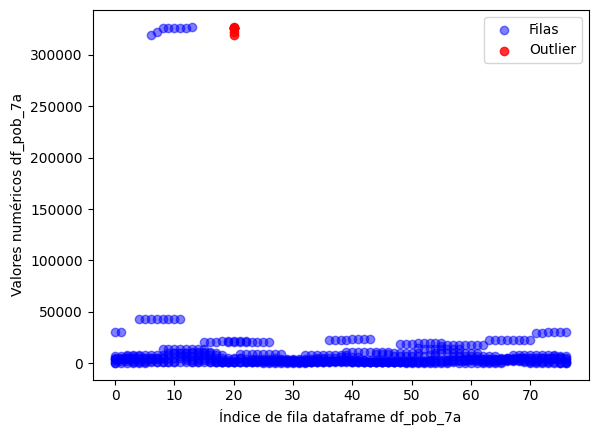

In [41]:
# busca_outliers_zscore (argu1 -> dataframe
#                       ,argu2 -> umbral para Z-score
#                       ,argu3 -> normalización de los datos

busca_outliers_zscore (df_pob_7a, 
                       "df_pob_7a",
                       3,
                       'N')

Gráfico de dispersión con datos normalizados

Dataframe df_pob_7a: filas outliers tras normalización Index([20], dtype='int64')


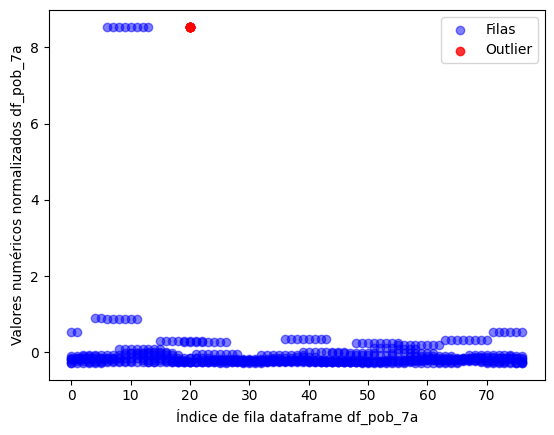

In [42]:
busca_outliers_zscore (df_pob_7a, 
                       "df_pob_7a",
                       3,
                       'S')

Diagramas de caja incluyendo outliers

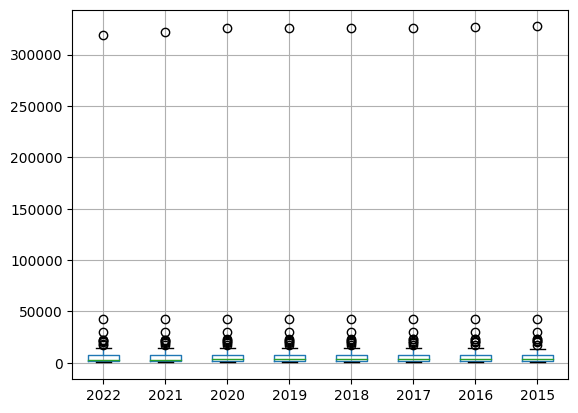

In [43]:
col_num_pob = df_pob_7a.select_dtypes (include = [np.number]).columns
df_pob_7a[col_num_pob].boxplot()
plt.show()

Comprobación de la fila seleccionada como outlier, que se corresponde con la entidad Córdoba, capital de provincia, y que no se incluirá en este estudio por no tener los datos económicos. Eliminación de la misma y comprobación posterior de outliers.

In [44]:
filas_seleccionadas = df_pob_7a.iloc[17:24]
print (filas_seleccionadas)

   esquema     cp         entidad    2022    2021    2020    2019    2018   
17    1018  14018       El Carpio    4353    4382    4363    4383    4457  \
18    1019  14019  Castro del Río    7711    7740    7767    7809    7834   
19    1020  14020       Conquista     380     372     366     379     401   
20    1021  14021         Córdoba  319515  322071  326039  325701  325708   
21    1022  14022     Doña Mencía    4583    4603    4615    4638    4684   
22    1023  14023      Dos Torres    2402    2399    2394    2411    2416   
23    1024  14024  Encinas Reales    2266    2256    2254    2254    2285   

      2017    2016    2015  
17    4480    4500    4496  
18    7881    7917    7972  
19     418     430     438  
20  325916  326609  327362  
21    4718    4789    4882  
22    2426    2453    2457  
23    2297    2324    2343  


Eliminación del outlier y comprobación de las gráficas con el nuevo dataframe

In [45]:
df_pob_7a = df_pob_7a.drop (20)

Dataframe df_pob_7a: filas outliers Index([39, 57], dtype='int64')


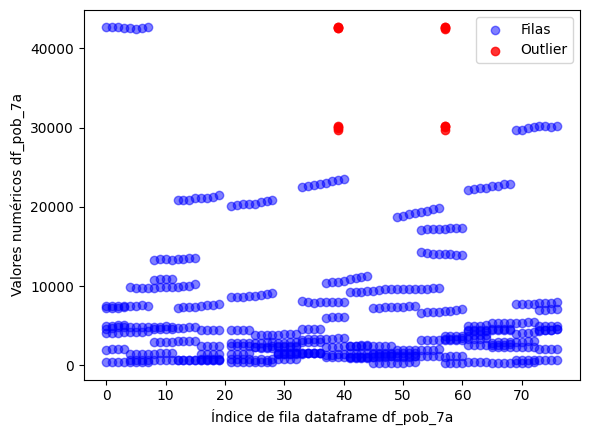

In [46]:
busca_outliers_zscore (df_pob_7a, 
                       "df_pob_7a",                
                       3,
                       'N')

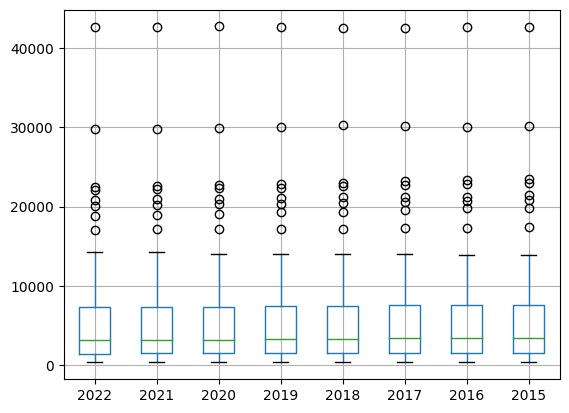

In [47]:
df_pob_7a[col_num_pob].boxplot()
plt.show()

**Outliers de datos económicos**

Se elimina la columna índice con la que se han cargado los 2 grupos de datos económicos para trabajar más fácilmente con ellos.

In [48]:
df_apli_gastos = df_apli_gastos.reset_index() 
df_apli_ingresos = df_apli_ingresos.reset_index() 

Dataframe df_apli_gastos: filas outliers tras normalización Index([   156,    190,    191,    231,    233,    358,    376,    421,    455,
          497,
       ...
       185442, 185443, 185444, 185458, 185478, 185488, 185493, 185538, 185544,
       185545],
      dtype='int64', length=8152)


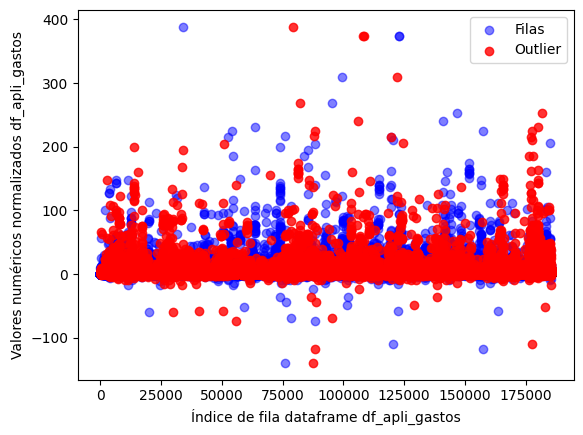

In [49]:
busca_outliers_zscore (df_apli_gastos, 
                       "df_apli_gastos",
                       3,
                       'S')

Dataframe df_apli_gastos: filas outliers tras normalización Index([  2732,   6961,   7513,  15747,  15889,  16118,  16557,  23089,  26205,
        26746,
       ...
       184698, 184699, 184719, 184812, 184815, 184853, 185037, 185074, 185101,
       185493],
      dtype='int64', length=165)


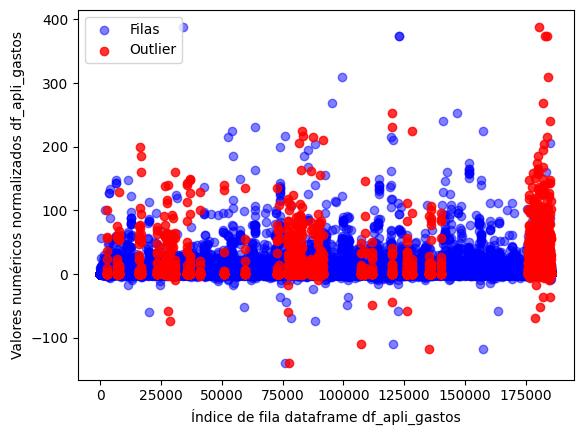

In [50]:
busca_outliers_zscore (df_apli_gastos, 
                       "df_apli_gastos",
                       50,
                       'S')

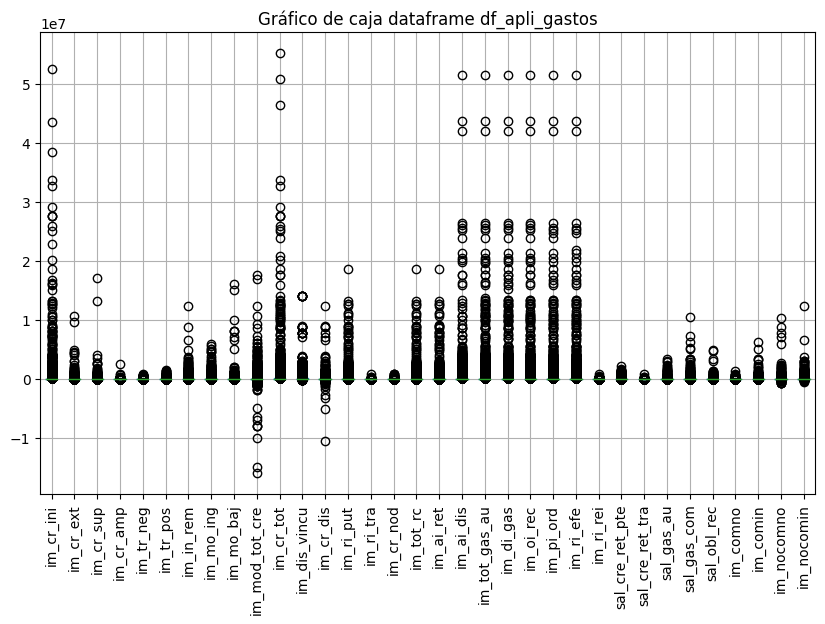

In [51]:
col_num_gas = df_apli_gastos.select_dtypes (include = [np.number]).columns
plt.figure (figsize = (10, 6))
df_apli_gastos[col_num_gas].boxplot()
plt.xticks (rotation=90)
plt.title ("Gráfico de caja dataframe df_apli_gastos")
plt.show ()

Dataframe df_apli_ingresos: filas outliers Index([ 3656, 10231, 12801, 16161, 20955, 21089, 21269, 22041, 22708, 24769,
       27657, 33704, 35999, 43526, 43574, 43623, 43624, 43670, 43711, 43761,
       43808, 43873, 43895, 43943, 43983, 44070, 44164, 44219, 44261, 44270,
       44309],
      dtype='int64')


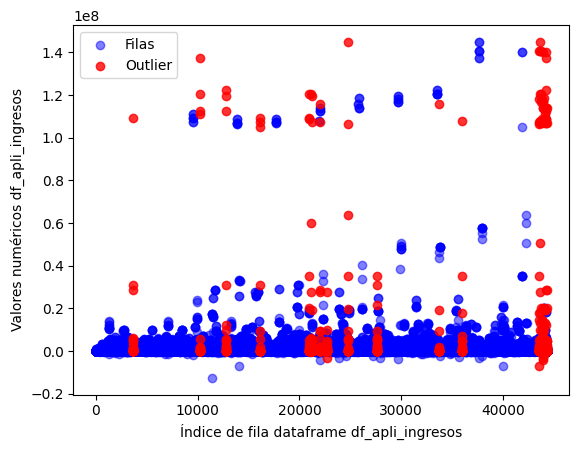

In [52]:
busca_outliers_zscore (df_apli_ingresos,
                       "df_apli_ingresos",   
                       50,
                       'N')

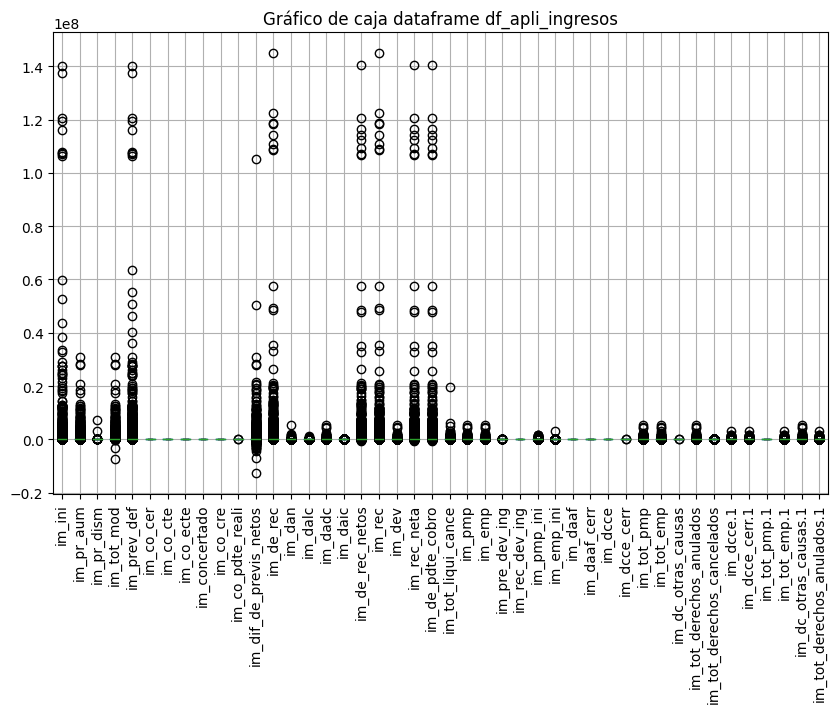

In [53]:
col_num_ing = df_apli_ingresos.select_dtypes (include = [np.number]).columns
plt.figure (figsize = (10, 6))
df_apli_ingresos[col_num_ing].boxplot()
plt.xticks (rotation = 90)
plt.title ("Gráfico de caja dataframe df_apli_ingresos")
plt.show ()

**Inconsistencias en datos económicos**

*Ejercicios fuera del período de estudio*

El período de estudio es del 2015 al 2022. Un análisis de los datos nos hace ver que se han incluido filas con el ejercicio contable 2023, no cerrado contablemente hablando. Se eliminan estas filas. Para ello  y para otros trabajos, fue necesario eliminar el índice del atributo id_eje en sentencias anteriores. Se eliminan las filas, y se vuelven a establecer id_eje como índice en ambos dataframes.

In [54]:
# Elimina las filas con los valores del ejercicio 2023
df_apli_gastos = df_apli_gastos.drop (df_apli_gastos[df_apli_gastos['id_eje'] == '2023'].index)  
df_apli_ingresos = df_apli_ingresos.drop (df_apli_ingresos[df_apli_ingresos['id_eje'] == '2023'].index)  

In [55]:
# Se restablece la columna a índice
df_apli_gastos = df_apli_gastos.set_index ('id_eje')  
df_apli_ingresos = df_apli_ingresos.set_index ('id_eje')

*Estudio de las filas con objetivos y/o metas con valor nulo*

Se realiza un estudio cualitativo de las filas que no poseen objetivos. Como los objetivos están asociados al programa de gasto, se determina que todas las filas que no tienen objetivos se corresponden con el programa de gasto 0, denominado "Deuda Pública". En España, por ejemplo, la clasificación presupuestaria utilizada por las entidades locales se rige por el Real Decreto 500/1990, de 20 de abril, por el que se desarrolla la estructura orgánica básica del Ministerio de Economía y Hacienda, y en el cual se establecen los códigos numéricos de los programas presupuestarios.

En esta clasificación, el código numérico para la Deuda Pública en los presupuestos municipales sería el 161, correspondiente al programa presupuestario "Servicio de la Deuda Pública", dentro de la función económica "Servicio de la Deuda Pública" (código 16). Tras entrevista con personal técnico cualificado, se opta por asignar el mismo objetivo y meta del programa Servicio de la Deuda Pública al programa Deuda Pública.

In [56]:
df_apli_gastos.loc [df_apli_gastos['objetivo'].isnull(), 
                    ['id_entidad', 
                     'entidad',  
                     'id_clasp', 
                     'ds_clasp', 
                     'id_clase']
                   ]

id_entidad                           entidad id_clasp   
id_eje                                                             
2015-01-01        001                            ADAMUZ      011  \
2015-01-01        001                            ADAMUZ      011   
2015-01-01        001                            ADAMUZ      011   
2015-01-01        001                            ADAMUZ      011   
2015-01-01        001                            ADAMUZ      011   
...               ...                               ...      ...   
2018-01-01       2000  DIPUTACIÓN PROVINCIAL DE CÓRDOBA     0111   
2018-01-01       2000  DIPUTACIÓN PROVINCIAL DE CÓRDOBA     0111   
2018-01-01       2000  DIPUTACIÓN PROVINCIAL DE CÓRDOBA     0111   
2018-01-01       2000  DIPUTACIÓN PROVINCIAL DE CÓRDOBA     0111   
2018-01-01       2000  DIPUTACIÓN PROVINCIAL DE CÓRDOBA     0110   

                 ds_clasp id_clase  
id_eje                              
2015-01-01  DEUDA PÚBLICA    31000  
2015-01-01  DEUDA PÚBLICA    31001  
2015-01-01  DEUDA PÚBLICA    31900  
2015-01-01  DEUDA PÚBLICA    35200  
2015-01-01  DEUDA PÚBLICA    91301  
...                   ...      ...  
2018-01-01  DEUDA PUBLICA    91306  
2018-01-01  DEUDA PUBLICA    91307  
2018-01-01  DEUDA PUBLICA    91308  
2018-01-01  DEUDA PUBLICA    91309  
2018-01-01  DEUDA PUBLICA    35200  

[2666 rows x 5 columns]

Obtención del valor del objetivo relativo al Servicio de Deuda Pública.

In [57]:
aux_objetivo161 = df_apli_gastos.loc [df_apli_gastos['id_clasp'].str.startswith ('161'), 
                                      'objetivo'].values[0] 
aux_objetivo161

'11'

Obtención del valor de la meta relativa al Servicio de Deuda Pública.

In [58]:
aux_meta161 = df_apli_gastos.loc [df_apli_gastos['id_clasp'].str.startswith ('161'), 
                                  'meta'].values[0] 
aux_meta161

'1'

Asignación de objetivo del programa de gasto 16 al objetivo del programa de gasto 0.

In [59]:
df_apli_gastos.loc[df_apli_gastos['id_clasp'].str.startswith ('0'), 
                   'objetivo'] = aux_objetivo161

Asignación de la meta del programa de gasto 16 a la meta del programa de gasto 0.

In [60]:
df_apli_gastos.loc[df_apli_gastos['id_clasp'].str.startswith ('0'), 
                   'meta'] = aux_meta161

### 3.2.4. Creación de nuevos atributos.

**Métodos a utilizar**

In [61]:
"""
    Nombre: print_frec_atributo
    Función: imprime la tabla de frecuencias en el dataframe argu_df de un atributo dado en argu_nom_atributo
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_nom_df (carácter): nombre del dataframe a tratar
        argu_nom_atributo (carácter): nombre del atributo para calcular su tabla de frecuencias. 
        argu_umbral_rel (float): umbral sobre el que se quieren mostrar las frecuencias de los atributos más usados.
"""
def print_frec_atributo (argu_df, argu_nom_df, argu_nom_atributo, argu_umbral_rel):
    try:
        # Calculo de frecuencias atributo objetivo
        t_frec_obj = argu_df[argu_nom_atributo].value_counts()
        t_frec_obj = pd.DataFrame ({argu_nom_atributo: t_frec_obj.index,
                                    'Frecuencia absoluta': t_frec_obj.values,
                                    'Frecuencia relativa': t_frec_obj.values / len(argu_df)})

        # Filtro de las frecuencias que superan el umbral argu_umbral_rel
        umbral_abs = len(argu_df) * argu_umbral_rel
        frec_superan_umbral = t_frec_obj[t_frec_obj['Frecuencia absoluta'] > umbral_abs]

        # Agrupamos bajo la leyenda "Resto"
        frec_restantes = t_frec_obj[t_frec_obj['Frecuencia absoluta'] <= umbral_abs].sum()
        frec_restantes[argu_nom_atributo] = 'Resto'
        frec_restantes = pd.DataFrame(frec_restantes).transpose()

        # Concatenamos las frecuencias que superan el umbral con las que no
        t_frec_obj = pd.concat ([frec_superan_umbral, 
                                 frec_restantes], 
                                ignore_index = True)

        t_frec_obj['Frecuencia relativa'] = t_frec_obj['Frecuencia relativa'].apply(lambda x: format(x, 
                                                                                                     '.2%'))

        pd.set_option ('display.max_colwidth', 
                       None)
        pd.set_option ('display.width', 
                       1000)

        t_frec_str = tabulate (t_frec_obj,
                               headers = 'keys',
                               tablefmt = 'fancy_grid',
                               showindex = False)
        
        # Se muestra la tabla de frecuencias obtenida
        print (t_frec_str)

        # Diagrama de barras
        plt.figure (figsize = (10, 6))
        plt.bar (t_frec_obj[argu_nom_atributo], 
                 t_frec_obj['Frecuencia absoluta'], 
                 color = 'skyblue')
        plt.xlabel (f'{argu_nom_atributo}')
        plt.ylabel ('Frecuencia absoluta')
        plt.title  (f'Diagrama de barras de frecuencias de {argu_nom_atributo}')
        plt.xticks (rotation = 45)
        plt.show ()

    except Exception as e:
        print("Error cod 100. Método print_frec_atributo: ", 
              str(e))

**Nuevos atributos en datos de población**

Realizada la limpieza de los datos de población, se introduce el atributo de la media poblacional en el período contemplado, que será el atributo referencia de población.

In [62]:
df_pob_7a = df_pob_7a.assign (pob_media = df_pob_7a.select_dtypes (include = ['int']).mean (axis = 1))

In [63]:
df_pob_7a['may_5000'] = df_pob_7a['pob_media'].apply(lambda x: 'S' if x >= 5000 else 'N')

In [64]:
df_pob_7a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 76
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   esquema    76 non-null     object 
 1   cp         76 non-null     object 
 2   entidad    76 non-null     object 
 3   2022       76 non-null     int64  
 4   2021       76 non-null     int64  
 5   2020       76 non-null     int64  
 6   2019       76 non-null     int64  
 7   2018       76 non-null     int32  
 8   2017       76 non-null     int32  
 9   2016       76 non-null     int32  
 10  2015       76 non-null     int32  
 11  pob_media  76 non-null     float64
 12  may_5000   76 non-null     object 
dtypes: float64(1), int32(4), int64(4), object(4)
memory usage: 7.1+ KB


In [65]:
df_pob_7a.sample (n = 5)

esquema     cp                entidad  2022  2021  2020  2019  2018  2017   
24    1025  14025                 Espejo  3245  3272  3289  3329  3333  3375  \
18    1019  14019         Castro del Río  7711  7740  7767  7809  7834  7881   
71    1070  14070   Villanueva del Duque  1431  1451  1448  1461  1494  1504   
70    1069  14069  Villanueva de Córdoba  8587  8662  8671  8729  8774  8886   
19    1020  14020              Conquista   380   372   366   379   401   418   

    2016  2015  pob_media may_5000  
24  3410  3443   3337.000        N  
18  7917  7972   7828.875        S  
71  1520  1553   1482.750        N  
70  9005  9141   8806.875        S  
19   430   438    398.000        N

╒════════════╤═══════════════════════╤═══════════════════════╕
│ may_5000   │   Frecuencia absoluta │ Frecuencia relativa   │
╞════════════╪═══════════════════════╪═══════════════════════╡
│ N          │                    51 │ 67.11%                │
├────────────┼───────────────────────┼───────────────────────┤
│ S          │                    25 │ 32.89%                │
├────────────┼───────────────────────┼───────────────────────┤
│ Resto      │                     0 │ 0.00%                 │
╘════════════╧═══════════════════════╧═══════════════════════╛


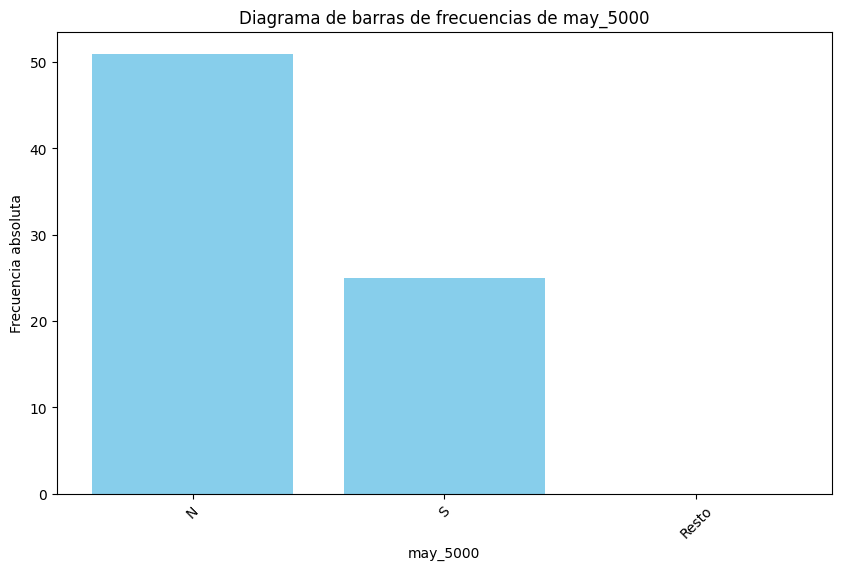

In [66]:
print_frec_atributo (df_pob_7a, "df_pob_7a", "may_5000", 0)

**Nuevos atributos en datos geográficos**

No se ve la necesidad de crear nuevos atributos en el caso de los datos geográficos. Solo se establecen el estudio de frecuencias de los atributos actuales. El umbral se pone a 0 para forzar que salgan todas las poblaciones agrupadas, tengan la frecuencia que tengan.

╒══════════════════════════════╤═══════════════════════╤═══════════════════════╕
│ Comarca                      │   Frecuencia absoluta │ Frecuencia relativa   │
╞══════════════════════════════╪═══════════════════════╪═══════════════════════╡
│ Los Pedroches                │                    17 │ 22.08%                │
├──────────────────────────────┼───────────────────────┼───────────────────────┤
│ Subbética                    │                    14 │ 18.18%                │
├──────────────────────────────┼───────────────────────┼───────────────────────┤
│ Campiña Sur                  │                    12 │ 15.58%                │
├──────────────────────────────┼───────────────────────┼───────────────────────┤
│ Valle del Guadiato           │                    11 │ 14.29%                │
├──────────────────────────────┼───────────────────────┼───────────────────────┤
│ Valle Medio del Guadalquivir │                     9 │ 11.69%                │
├───────────────────────────

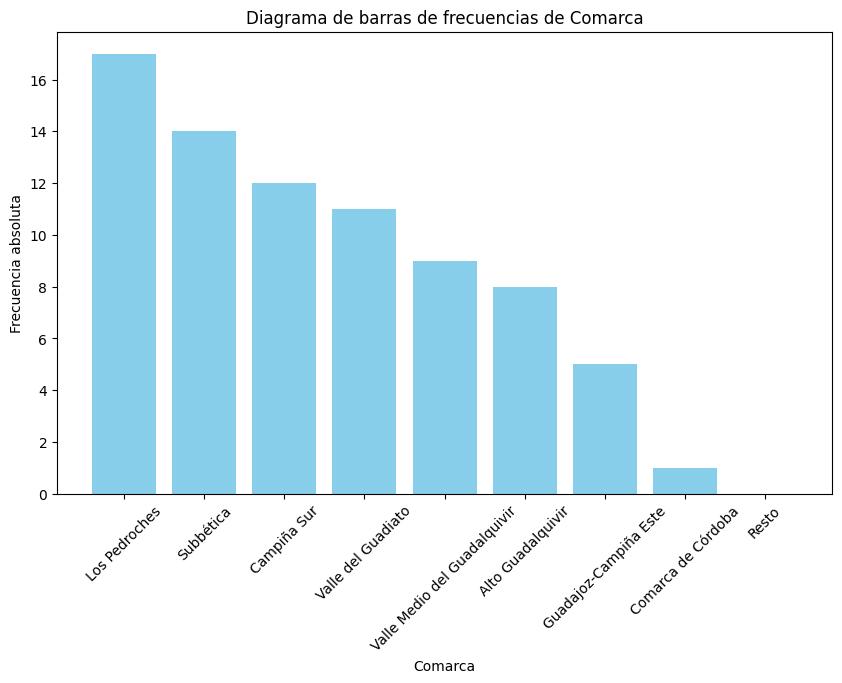

In [67]:
print_frec_atributo (df_comarca, "df_comarca", "Comarca", 0)

**Nuevos atributos en datos económicos**

Para el estudio de la frecuencia de objetivos/metas en los valores de la provincia, se crea un nuevo atributo en el dataframe, resultado de la concatenación de ambos.

In [68]:
df_apli_gastos['obj_meta'] = df_apli_gastos.apply (lambda x: str(x['objetivo']) + '.' + str(x['meta']), 
                                                   axis=1)

Se realiza la tabla de frecuencias de los objetivos y de objetivos/metas, respectivamente.

╒════════════╤═══════════════════════╤═══════════════════════╕
│ objetivo   │   Frecuencia absoluta │ Frecuencia relativa   │
╞════════════╪═══════════════════════╪═══════════════════════╡
│ 11         │                 93022 │ 53.25%                │
├────────────┼───────────────────────┼───────────────────────┤
│ 16         │                 21950 │ 12.56%                │
├────────────┼───────────────────────┼───────────────────────┤
│ 10         │                 19737 │ 11.30%                │
├────────────┼───────────────────────┼───────────────────────┤
│ 1          │                 11908 │ 6.82%                 │
├────────────┼───────────────────────┼───────────────────────┤
│ 8          │                  8737 │ 5.00%                 │
├────────────┼───────────────────────┼───────────────────────┤
│ Resto      │                 19348 │ 11.07%                │
╘════════════╧═══════════════════════╧═══════════════════════╛


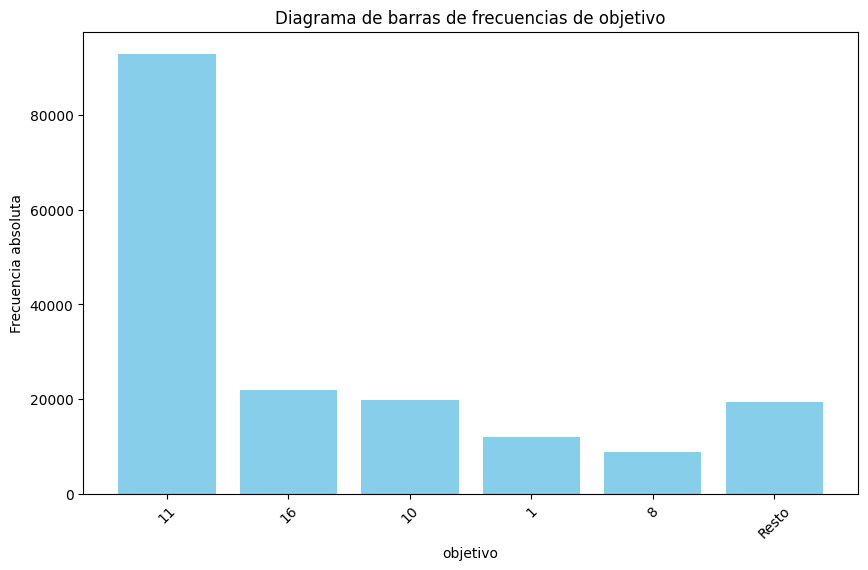

In [69]:
print_frec_atributo (df_apli_gastos, "df_apli_gastos", "objetivo", 0.05)

╒════════════╤═══════════════════════╤═══════════════════════╕
│ obj_meta   │   Frecuencia absoluta │ Frecuencia relativa   │
╞════════════╪═══════════════════════╪═══════════════════════╡
│ 11.1       │                 33647 │ 19.26%                │
├────────────┼───────────────────────┼───────────────────────┤
│ 11.2       │                 27957 │ 16.00%                │
├────────────┼───────────────────────┼───────────────────────┤
│ 11.4       │                 20303 │ 11.62%                │
├────────────┼───────────────────────┼───────────────────────┤
│ 10.1       │                 16912 │ 9.68%                 │
├────────────┼───────────────────────┼───────────────────────┤
│ 16.7       │                 13706 │ 7.85%                 │
├────────────┼───────────────────────┼───────────────────────┤
│ 1.4        │                 11365 │ 6.51%                 │
├────────────┼───────────────────────┼───────────────────────┤
│ Resto      │                 50812 │ 29.08%          

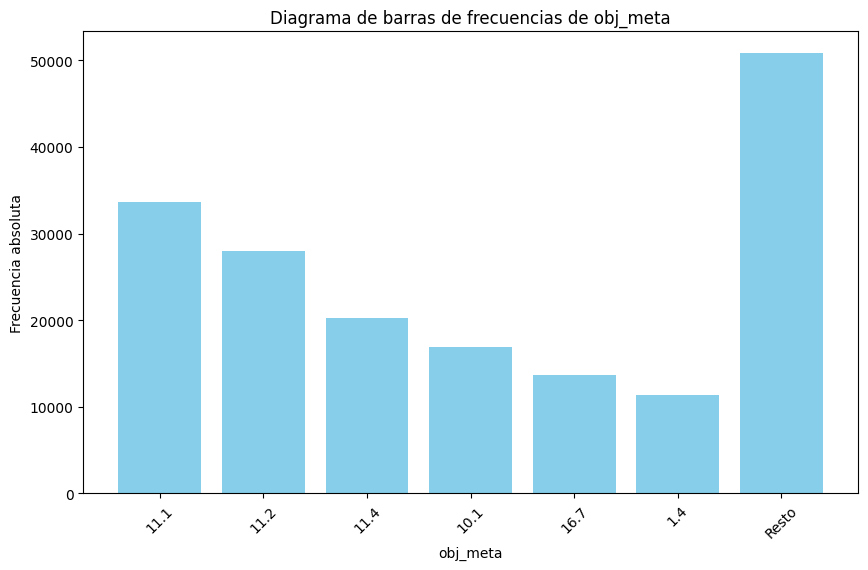

In [70]:
print_frec_atributo (df_apli_gastos, "df_apli_gastos", "obj_meta", 0.05)

## 3.3. Análisis de los datos (memoria y notebook)

### 3.3.1. Características del análisis (memoria)

### 3.3.2. Definición de variables objetivo

Las variables objetivo son aquellas que se quieren predecir o modelar a partir de otras variables explicativas o independientes.

##### Gastos: Gasto Presupuestado, Gasto Ejecutado y Desviación Presupuestaria.

**Gasto Presupuestado**. Esta variable se basa en la definición del presupuesto de gastos como el conjunto de los créditos necesarios para atender las obligaciones que se prevén realizar durante el ejercicio. Los créditos aprobados definitivamente son los que se establecen en el presupuesto inicial, mientras que las modificaciones de crédito son las alteraciones que se producen durante la ejecución del presupuesto por diversas causas. Los créditos extraordinarios y los suplementos de crédito son modificaciones que se realizan para atender gastos no previstos o insuficientemente dotados. Las ampliaciones y las transferencias de crédito son modificaciones que se realizan para reforzar o redistribuir los créditos existentes. Los remanentes de crédito son los créditos no utilizados en el ejercicio anterior que se incorporan al presupuesto del ejercicio corriente. Las bajas por anulación son las cancelaciones totales o parciales de los créditos que no se van a utilizar.

Gasto presupuestado (Créditos totales consignados) =     
Importe de créditos aprobados definitivos   
\+ Importe de modificaciones de crédito generadas por ingreso  
\+ Importe de créditos extraordinarios  
\+ Importe de suplementos de crédito  
\+ Importe de ampliaciones de crédito  
\+ Importe de transferencias positivas de crédito   
\- Importe de transferencias negativas de crédito  
\+ Importe de incorporación de remanentes de crédito  
\- Importe de bajas por anulación  

In [71]:
# Gasto presupuestado
df_apli_gastos['im_gas_presupuestado'] = df_apli_gastos['im_cr_ini'] + df_apli_gastos['im_mo_ing'] + df_apli_gastos['im_cr_ext'] + df_apli_gastos['im_cr_sup'] + df_apli_gastos['im_cr_amp'] + df_apli_gastos['im_tr_pos'] - df_apli_gastos['im_tr_neg'] + df_apli_gastos['im_in_rem'] - df_apli_gastos['im_mo_baj']

**Gasto Ejecutado**. Este atributo refleja el importe de las obligaciones reconocidas que han sido satisfechas en el ejercicio económico. Es decir, el gasto ejecutado muestra la cantidad de recursos económicos que se han destinado para cubrir las obligaciones contraídas por la entidad en un periodo determinado. Con este indicador se evalúa la gestión financiera de la entidad, mostrando qué grado de eficiencia existe en la utilización de los recursos disponibles.

Gasto Ejecutado =   
Importe de obligaciones reconocidas

In [72]:
# Gasto ejecutado
df_apli_gastos = df_apli_gastos.rename (columns = {'im_oi_rec': 'im_gas_ejecutado'})

**Desviación presupuestaria de gastos**. Este atributo mide la diferencia entre el gasto ejecutado y el gasto presupuestado para cada período.

Desviación presupuestaria de gastos =   
Gasto ejecutado - Gasto presupuestado

In [73]:
# Desviación presupuestaria de gastos
df_apli_gastos['im_desv_ppria_gas'] = df_apli_gastos['im_gas_ejecutado'] - df_apli_gastos['im_gas_presupuestado'] 

##### Ingresos: Ingresos Previstos e Ingresos Realizados.

**Ingresos Previstos**. El atributo de ingresos previstos indicaría las estimaciones de los ingresos que se espera recibir durante el período presupuestario en cuestión.

Ingresos previstos =     
Importe de previsiones definitivas.

In [74]:
# Ingreso previsto

df_apli_ingresos = df_apli_ingresos.rename (columns = {'im_prev_def': 'im_ing_previstos'})

**Ingresos Realizados**. El atributo de ingresos realizados indicaría el total de ingresos que se han llevado a cabo durante el período presupuestario en cuestión.

Ingresos realizados =     
Importe de derechos reconocidos netos.

In [75]:
# Ingresos realizados

df_apli_ingresos = df_apli_ingresos.rename (columns = {'im_de_rec_netos': 'im_ing_realizados'})

**Desviación presupuestaria de ingresos**. Este atributo mide la diferencia entre el ingreso realizado y el ingreso previsto para cada período. Se calcula de la misma manera que en el caso de los gastos.

Desviación presupuestaria de ingresos =   
Ingresos realizado - Ingresos previstos

In [76]:
# Desviación presupuestaria de ingresos
df_apli_ingresos['im_desv_ppria_ing'] = df_apli_ingresos['im_ing_realizados'] - df_apli_ingresos['im_ing_previstos'] 

### 3.3.3. Correlación entre variables

**Métodos a utilizar**

In [77]:
"""
    Nombre: dsp_dendo_y_matriz_corr
    Función: dibuja el dendograma si argu_dendograma es 'S' y 
             realiza la matriz de correlación con el disp que se indique en argu_tipo_dsp
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_dendograma (carácter S/N): Muestra el dendograma
        argu_tipo_dsp (entero): 1 Muestra la matriz de correlación con solo los colores, sin valores
                                2 Muestra la matriz de correlación con los colores y los valores
                                3 Muestra la matriz de correlación solo con los colores y valores 
                                  que superen en valor absoluto argu_thresold
        argu_threshold (float): umbral de índice de correlación. Recomendado 0.5
"""
def dsp_dendo_y_matriz_corr (argu_df, argu_dendograma, argu_tipo_dsp, argu_threshold):
    try:
        col_num = argu_df.select_dtypes (include = ['int', 'float']).columns
        
        # Control de valores nan e infinitos
        col_importe = [col for col in col_num]
        argu_df[col_importe] = argu_df[col_importe].fillna(0)
        argu_df[col_importe] = argu_df[col_importe].replace([np.inf, -np.inf], 0)

        # Cálculo de la matriz de correlación
        m_corr = argu_df[col_num].corr()
        
        # Reordenación de los atributos en función de su correlación
        # Uso de técnicas de clustering para mejorar el display de la matriz
    
        # Cálculo del clustering
        Z = hierarchy.linkage (m_corr, 
                               # method = 'ward')
                               method = 'weighted')
        # dendograma
        if argu_dendograma == 'S':
            fig, ax = plt.subplots (figsize = (10, 
                                               10))
            hierarchy.dendrogram (Z, 
                                  labels = m_corr.columns, 
                                  ax = ax, 
                                  leaf_rotation = 90)
    
        # Se reordenan los atributos según el resultado del cálculo del clustering
        order = m_corr.columns[hierarchy.leaves_list(Z)]
        df_order = argu_df[order]
  
        m_corr_ord = df_order.corr()
        plt.figure (figsize = (15, 
                               15))
   
        # Visualización de la matriz de correlación
        if argu_tipo_dsp == 1:
            # Mostrar la matriz de correlación
            plt.imshow (m_corr_ord, 
                        cmap = 'coolwarm', 
                        vmin = -1, 
                        vmax = 1)
            plt.colorbar ()
        elif argu_tipo_dsp == 2:
            # Mostrar los índices de correlación en los cuadrados de la matriz
            sns.heatmap(m_corr_ord,
                        annot = True, 
                        cmap = 'coolwarm', 
                        vmin = -1, 
                        vmax = 1, 
                        square = True)
        
        else:
            # Filtrar y resaltar los valores de correlación significativos
            m_corr_filtered = m_corr_ord[(m_corr_ord > argu_threshold) | (m_corr_ord < -argu_threshold)]
      
            # Utilizar una escala de colores divergente
            sns.heatmap (m_corr_filtered, 
                         annot = True, 
                         cmap = 'coolwarm', 
                         vmin = -1, 
                         vmax = 1,
                         square = True)
        
        plt.xticks (range (len (m_corr_ord.columns)), 
                    m_corr_ord.columns, 
                    rotation = 90)
    
        plt.yticks (range (len (m_corr_ord.columns)), 
                    m_corr_ord.columns)
        
        # Ajusta automáticamente los espacios entre subtramas
        plt.tight_layout()
        
        plt.show ()
    except Exception as e:
        print("Error cod 110. Método dsp_dendo_y_matriz_corr: ", 
              str(e))

In [78]:
"""
    Nombre: dsp_grafico_dispersion
    Función: dibuja el gráfico de dispersión de la matriz de correlación
    Args:
        argu_df (dataframe): dataframe a tratar
        argu_threshold (float): umbral de índice de correlación. Recomendado 0.5
"""
def dsp_grafico_dispersion (argu_df, argu_threshold):
    try:
        col_num = argu_df.select_dtypes (include = ['int', 'float']).columns
        # Obtención de matriz de correlación
        m_corr = argu_df[col_num].corr()

        # Filtrar y obtener las correlaciones de interés 
        m_corr_filtered = m_corr[(m_corr > argu_threshold) | (m_corr < -argu_threshold)]
    
        # Obtener las correlaciones en formato de pares (atributo1, atributo2, correlación)
        correlaciones = []
        for col in m_corr_filtered.columns:
            correlaciones.extend([(col, 
                                   corr_col, 
                                   m_corr_filtered.loc[col, 
                                                       corr_col]) 
                                  for corr_col in m_corr_filtered.index if col != corr_col])
    
        # DataFrame con las correlaciones
        df_correlaciones = pd.DataFrame (correlaciones, 
                                         columns = ['Atributo 1', 
                                                    'Atributo 2', 
                                                    'Correlación'])
    
        # Ordenación de las correlaciones por valor absoluto
        df_correlaciones['Abs Correlación'] = np.abs (df_correlaciones['Correlación'])
        df_correlaciones = df_correlaciones.sort_values ('Abs Correlación', 
                                                         ascending = False)
    
        # Tamaño del gráfico
        plt.figure (figsize = (10, 
                                6))
    
        # Gráfico de dispersión
        sns.scatterplot ( data = df_correlaciones, 
                         x = 'Atributo 1', 
                         y = 'Atributo 2', 
                         hue = 'Correlación', 
                         palette = 'plasma', 
                         legend = True)
    
        plt.xticks (rotation = 90)
        plt.xlabel ('Atributo 1')
        plt.ylabel ('Atributo 2')
        plt.title ('Gráfico de Dispersión de Correlaciones')
        
        # Ajusta automáticamente los espacios entre subtramas
        plt.tight_layout()
        
        plt.show ()
    except Exception as e:
        print("Error cod 120. Método dsp_grafico_dispersion: ", 
              str(e))        

#### Estudio de la correlación entre atributos.

Dimensiones actuales de los dataframes tras preprocesamiento y la creación de variables objetivo.

In [79]:
print ("DATOS DE POBLACIÓN, Dataframe df_pob_7a ---- con (filas, columnas): ", df_pob_7a.shape)
print ("DATOS GEOGRÁFICOS, Dataframe df_comarca ---- con (filas, columnas): ", df_comarca.shape)
print ("DATOS ECONÓMICOS DE GASTOS, Dataframe df_apli_gastos ---- con (filas, columnas): ", df_apli_gastos.shape)
print ("DATOS ECONÓMICOS DE INGRESOS, Dataframe df_apli_ingresos ---- con (filas, columnas): ", df_apli_ingresos.shape)

DATOS DE POBLACIÓN, Dataframe df_pob_7a ---- con (filas, columnas):  (76, 13)
DATOS GEOGRÁFICOS, Dataframe df_comarca ---- con (filas, columnas):  (77, 2)
DATOS ECONÓMICOS DE GASTOS, Dataframe df_apli_gastos ---- con (filas, columnas):  (174702, 53)
DATOS ECONÓMICOS DE INGRESOS, Dataframe df_apli_ingresos ---- con (filas, columnas):  (40469, 55)


Cálculo de la matriz de correlación, para determinar qué atributos están altamente correlacionados. Los valores van desde -1 (correlación negativa perfecta) hasta 1 (correlación positiva perfecta). Los valores cercanos a cero indican una correlación débil o nula entre los atributos.

Se aplican técnicas de clustering para agrupar los atributos que se encuentran más correlacionados.

*Datos de población*

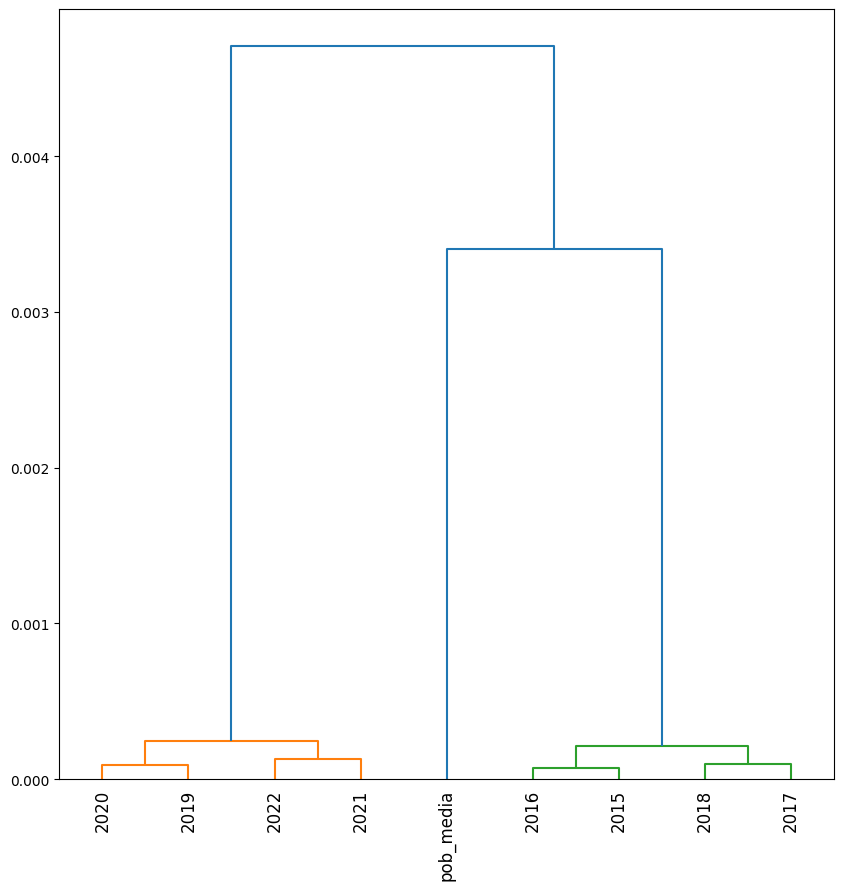

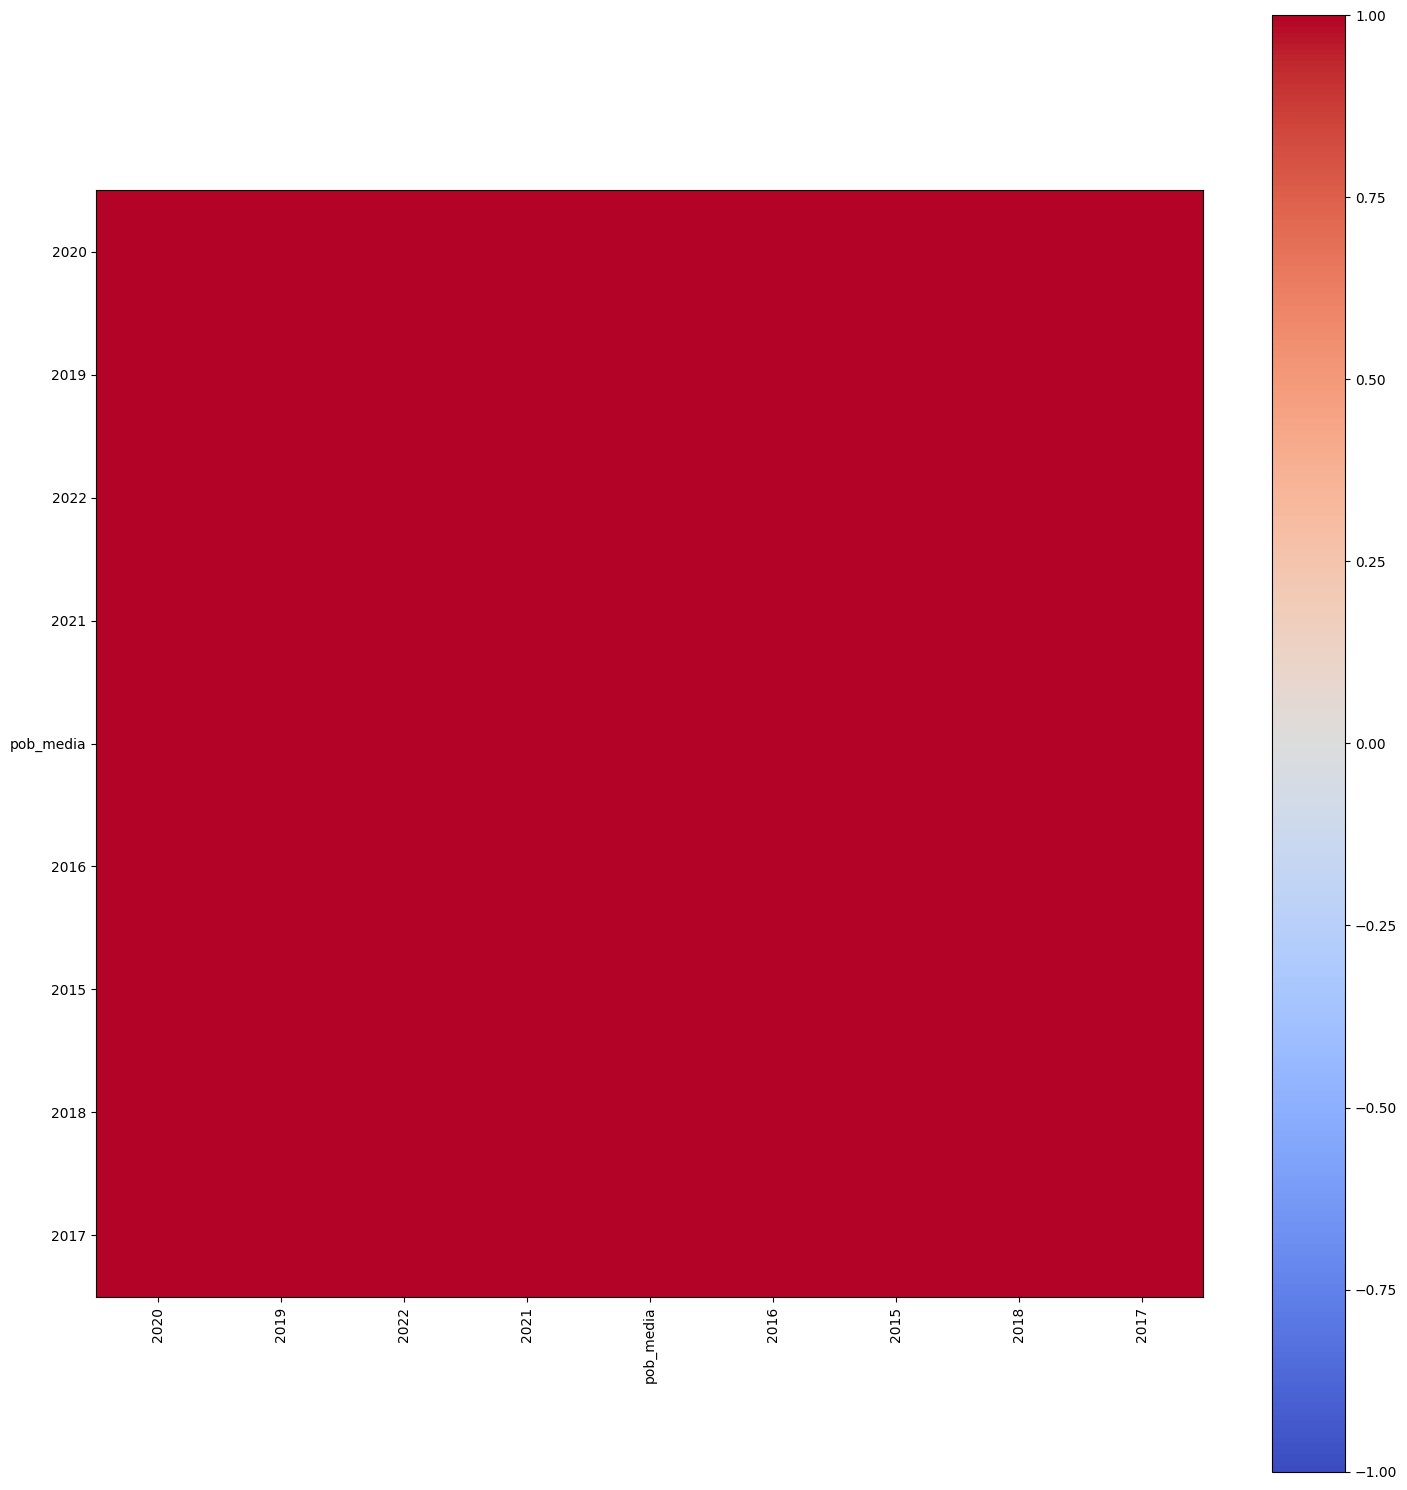

In [80]:
dsp_dendo_y_matriz_corr (df_pob_7a, 'S', 1, 0.5)

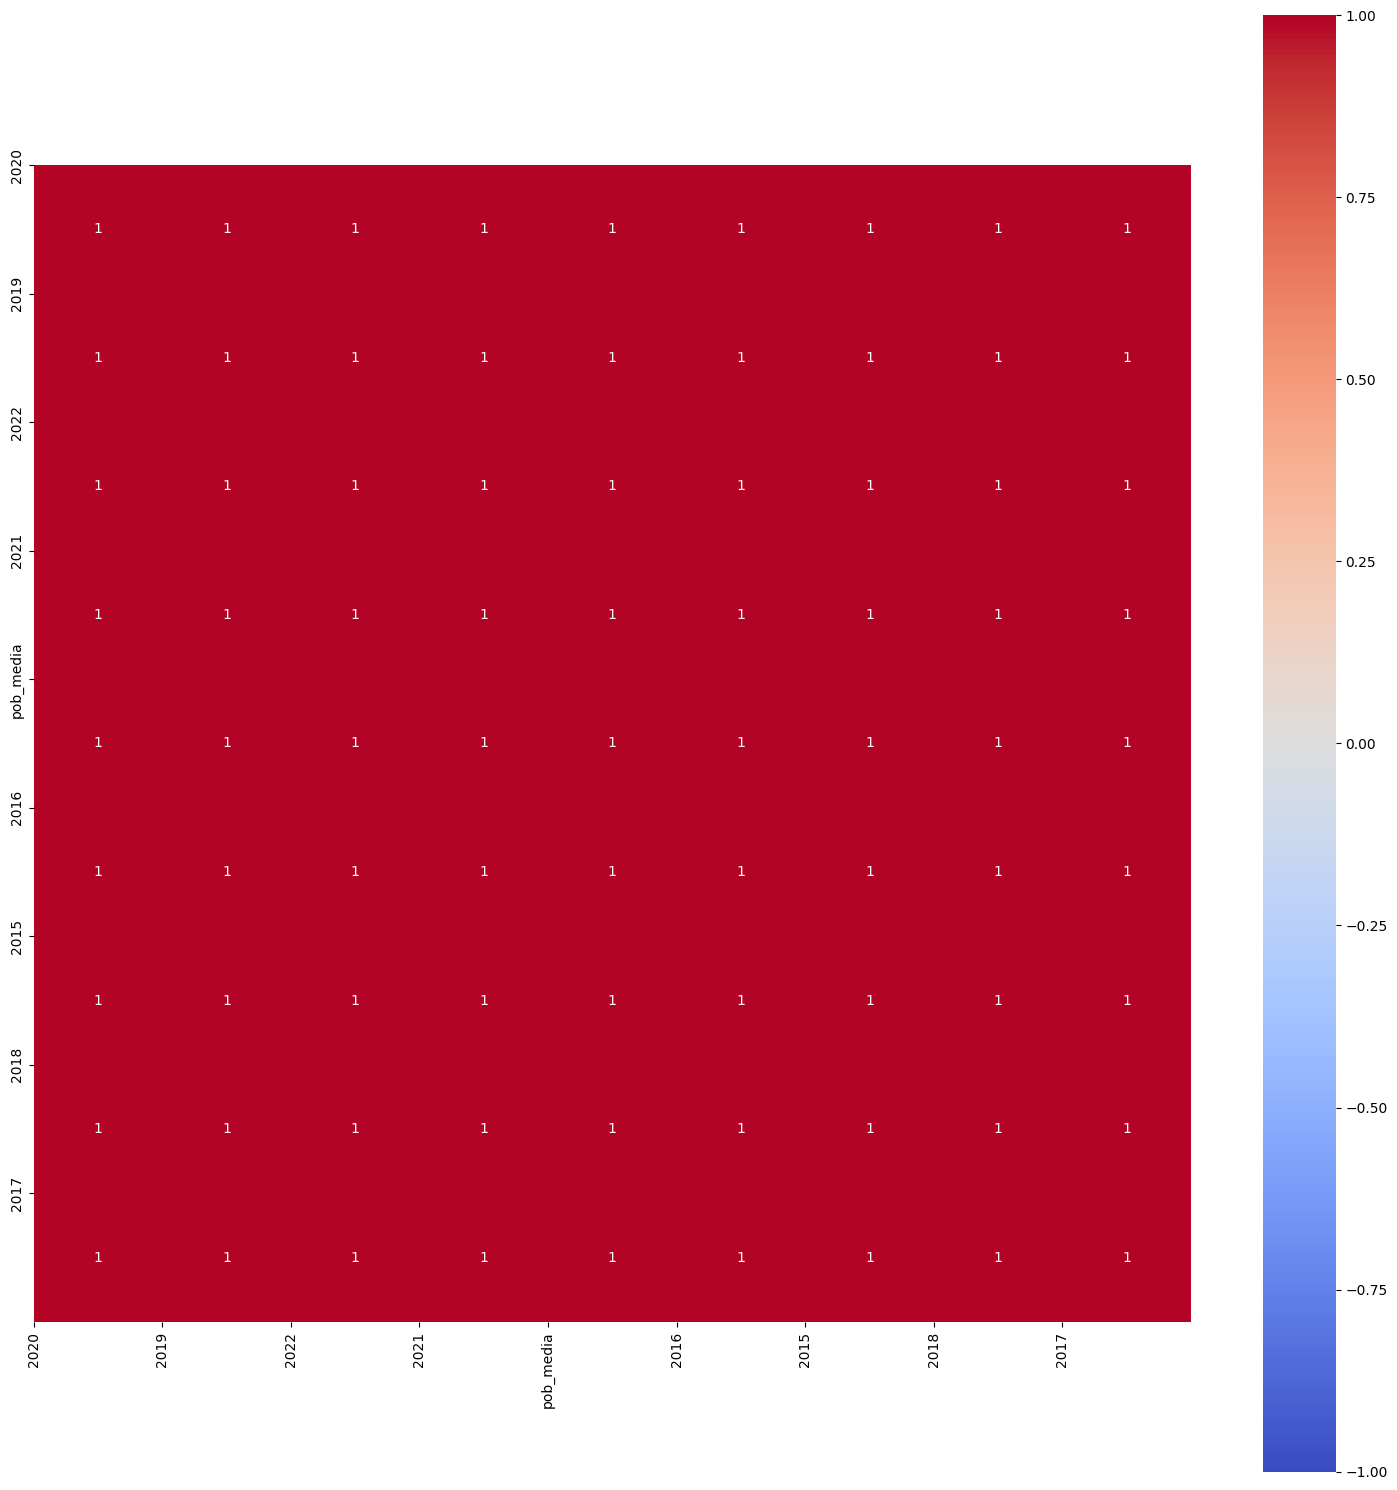

In [81]:
dsp_dendo_y_matriz_corr (df_pob_7a, 'N', 3, 0.5)

*Datos económicos Gastos*

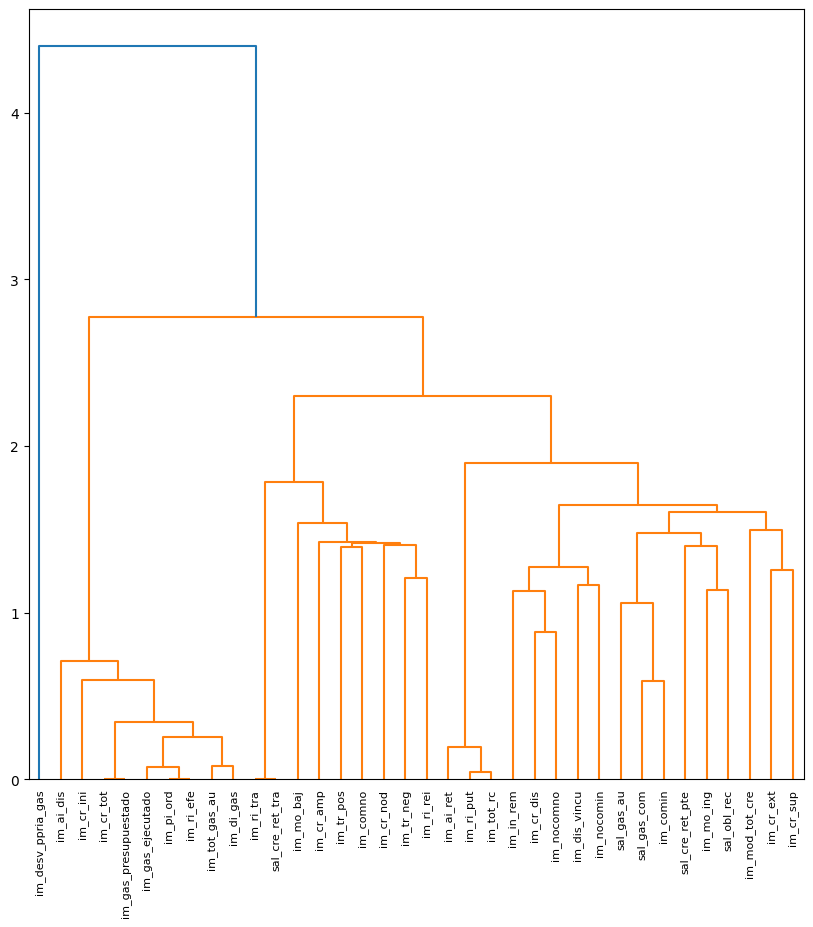

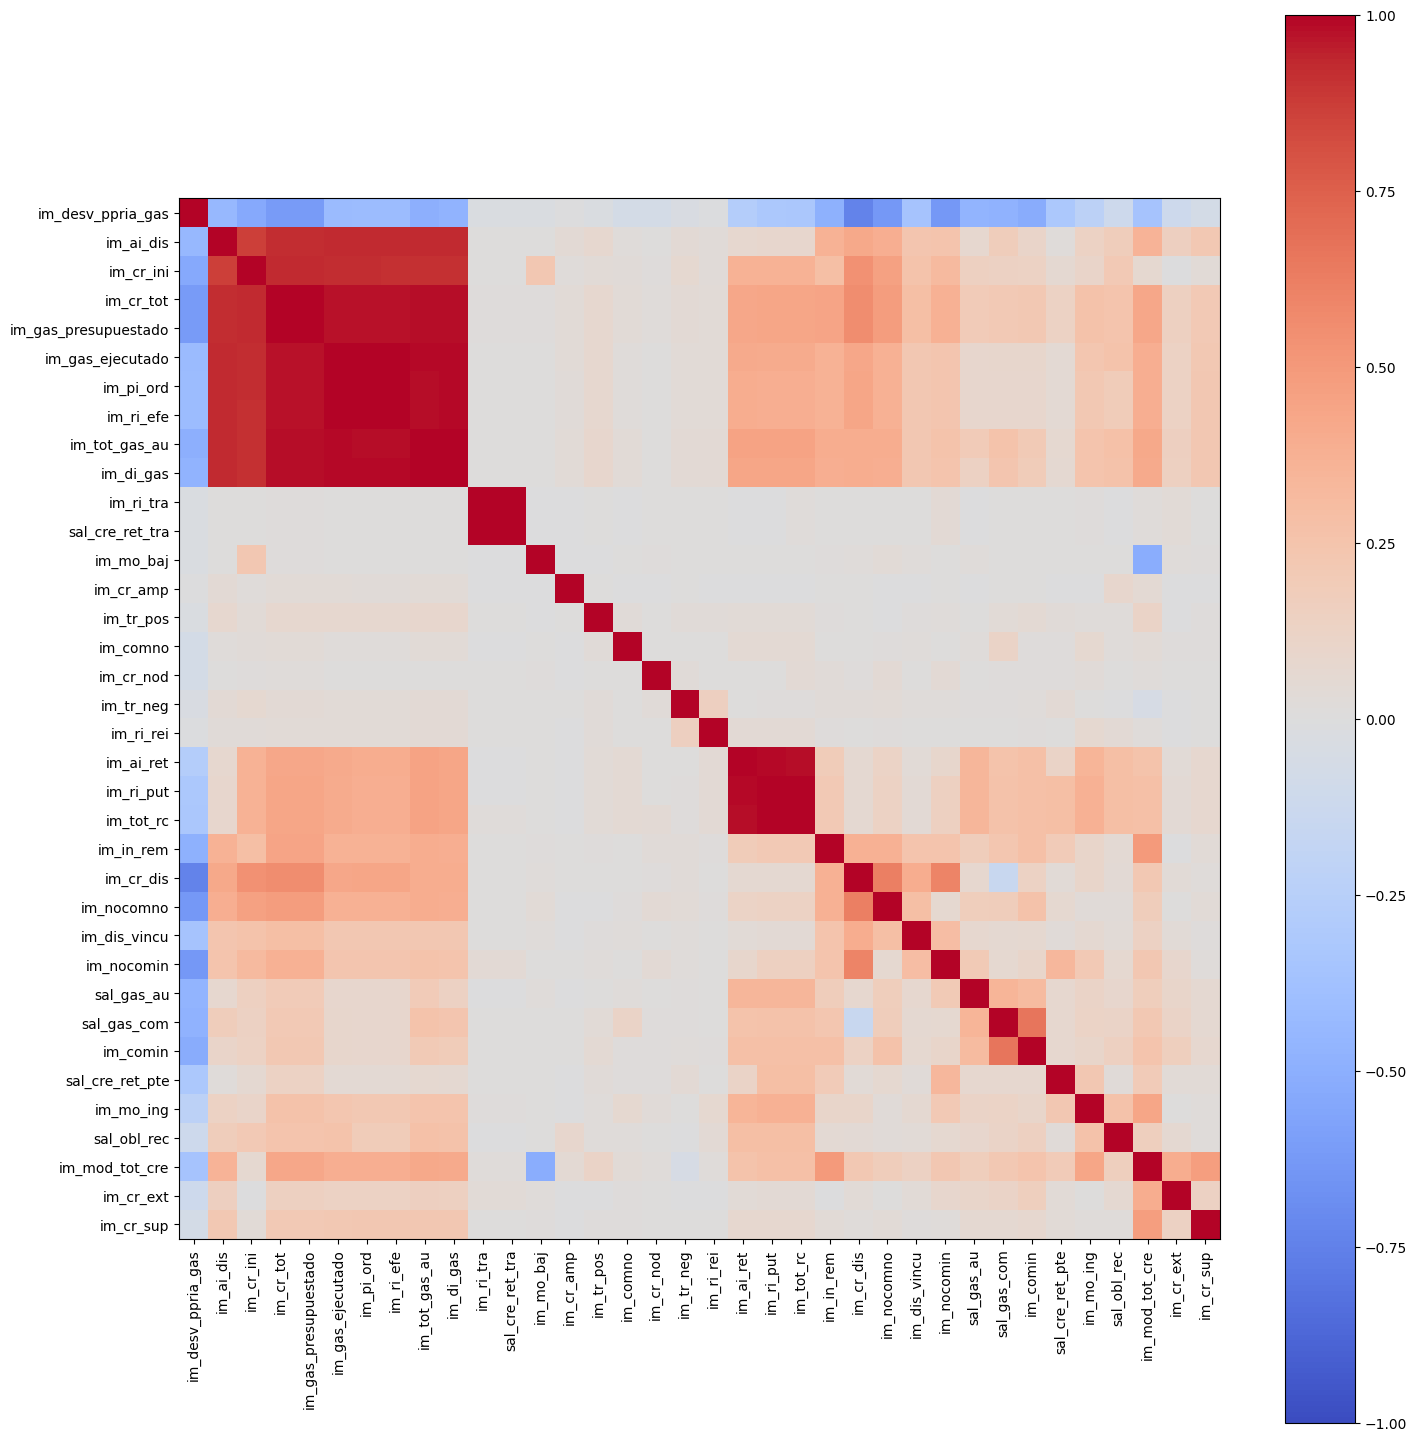

In [82]:
dsp_dendo_y_matriz_corr (df_apli_gastos, 'S', 1, 0.5)

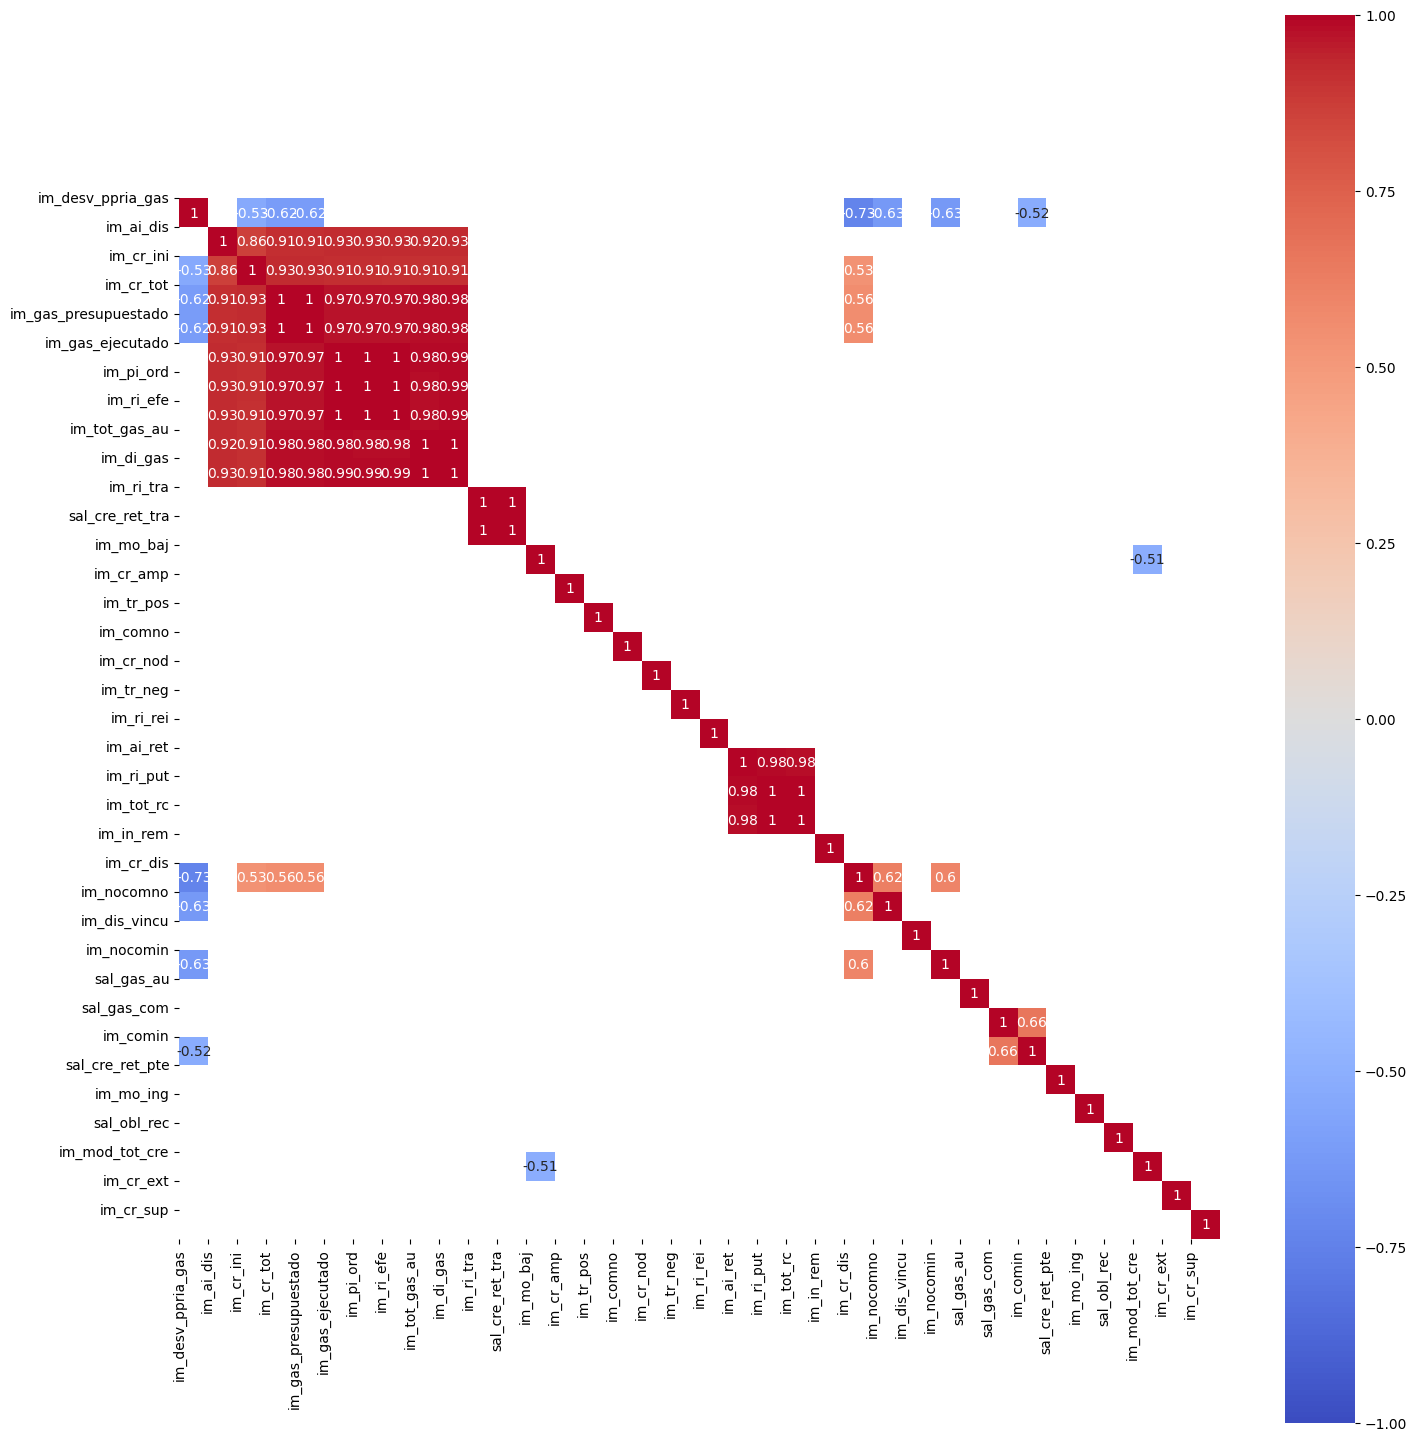

In [83]:
dsp_dendo_y_matriz_corr (df_apli_gastos, 'N', 3, 0.5)

*Datos económicos Ingresos*

En el caso del dataframe de ingresos, seguimos un tratamiento parecido al de gastos. Como se detectan atributos duplicados, se eliminan estos con el fin de reducir el procesamiento y la posible falta de memoria. También se eliminan aquellos atributos cuya varianza es 0.    

In [84]:
df_apli_ingresos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40469 entries, 2015-01-01 to 2022-01-01
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   esquema                     40469 non-null  object 
 1   id_entidad                  40469 non-null  object 
 2   entidad                     40469 non-null  object 
 3   id_claso                    1068 non-null   object 
 4   ds_claso                    1068 non-null   object 
 5   id_clase                    40469 non-null  object 
 6   ds_clase                    40469 non-null  object 
 7   ds_apli                     40469 non-null  object 
 8   im_ini                      40469 non-null  float64
 9   im_pr_aum                   40469 non-null  float64
 10  im_pr_dism                  40469 non-null  float64
 11  im_tot_mod                  40469 non-null  float64
 12  im_ing_previstos            40469 non-null  float64
 13  im_co_cer     

In [85]:
try:
    # Duplicidad de atributos: filtrado y eliminado de las columnas que terminan en ".1"
    atrib_dup = df_apli_ingresos.filter(like = ".1").columns
    df_apli_ingresos = df_apli_ingresos.drop (columns = atrib_dup)
    df_apli_ingresos = df_apli_ingresos.drop ('finalidad contable',
                                              axis = 1)
    df_apli_ingresos = df_apli_ingresos.drop ('Unnamed: 54',
                                              axis = 1)
    col_num = df_apli_ingresos.select_dtypes(include=['float']).columns

    # Procedimiento de reducción por varianza 0
    #     Cálculo de la varianza de cada columna numérica
    #     Se seleccionan las columnas con varianza distinta de cero (no todos los valores serían 0)
    #     Actualizamos el dataframe con solo las columnas con varianza distinta de 0

    col_varianza = df_apli_ingresos[col_num].var()
    col_var_no_cero = col_varianza[col_varianza != 0].index
    df_aux = df_apli_ingresos.loc[:, col_var_no_cero]
    # actualizamos la lista de columnas
    col_num = df_aux.loc[:, df_aux.select_dtypes (include = ['float']).columns]
    
except Exception as e:
        print("Error cod 130. Al extraer atributos para dendograma y matriz de correlación en ingresos: ", 
              str(e))         

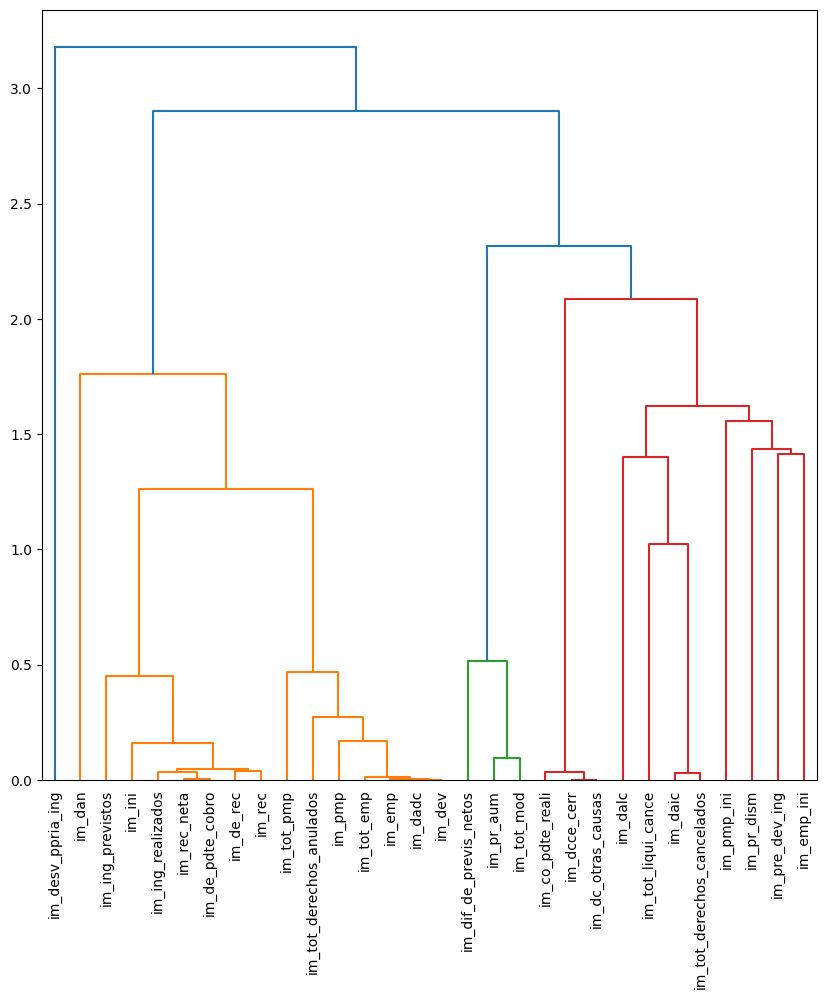

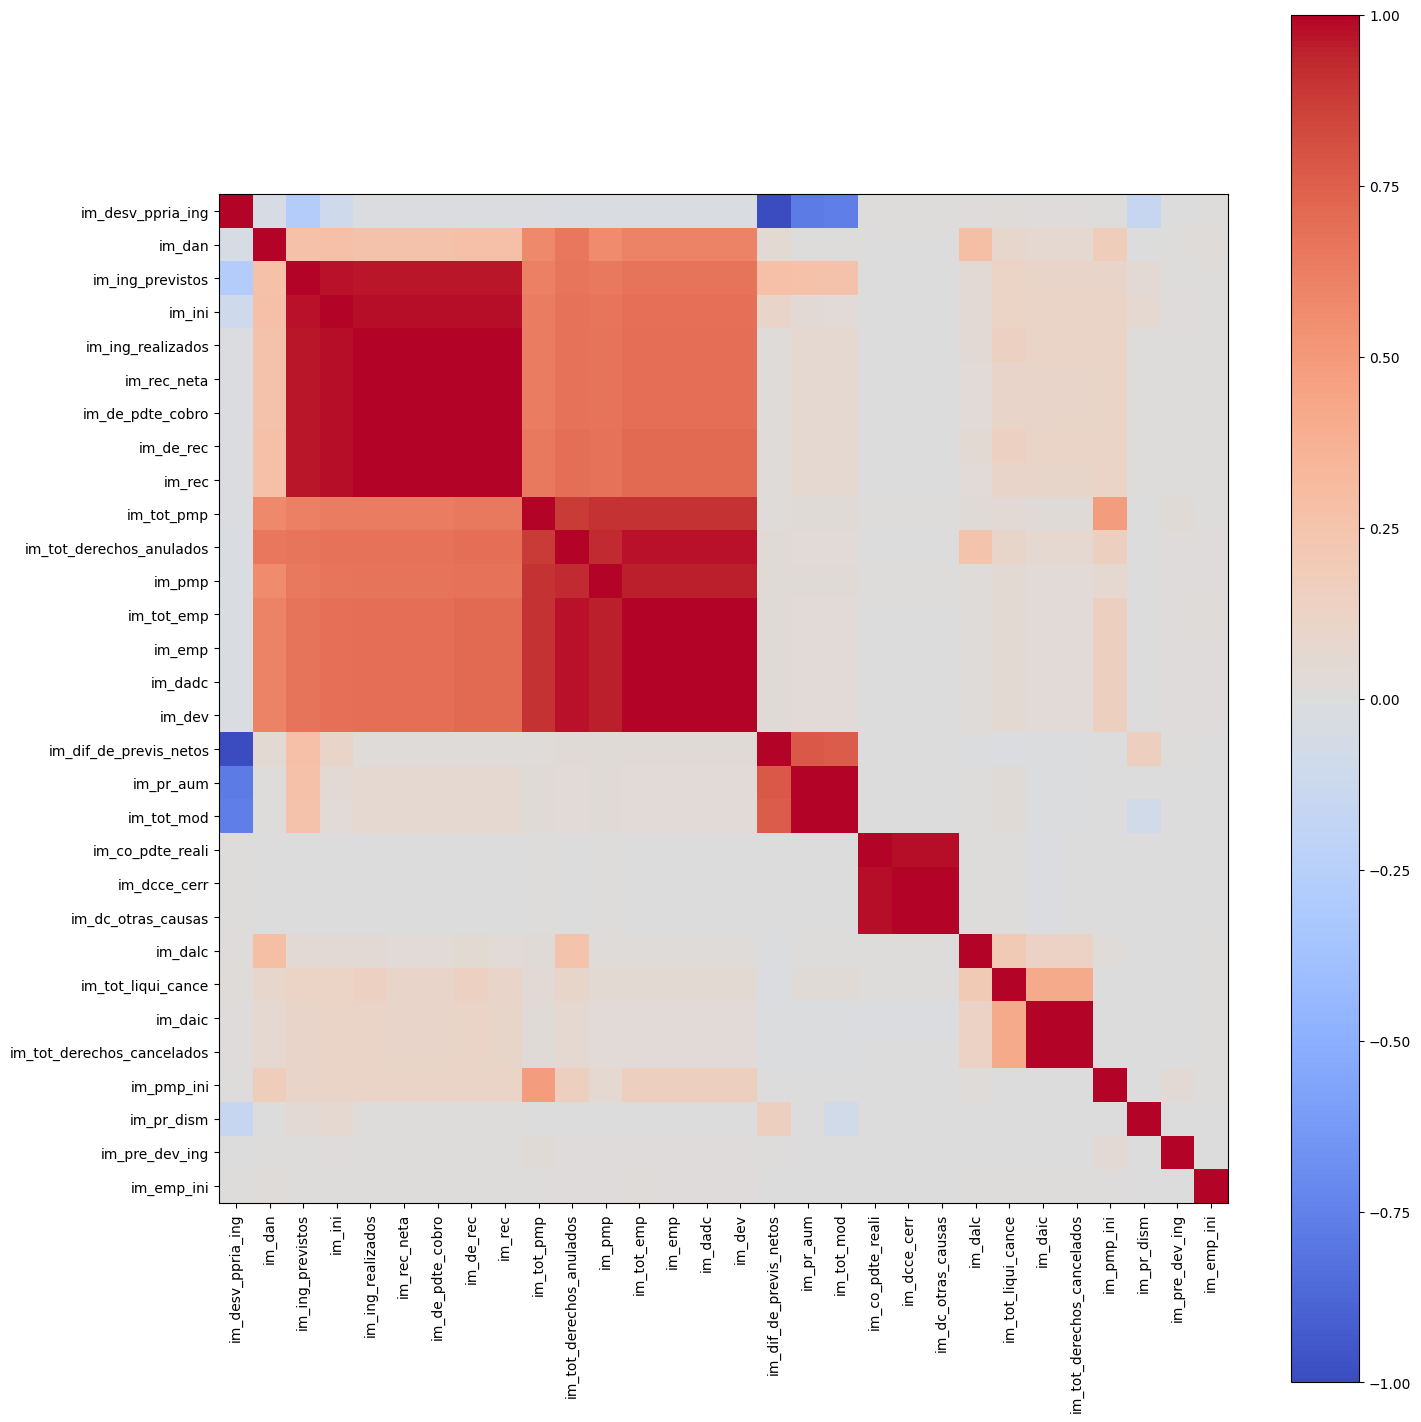

In [86]:
dsp_dendo_y_matriz_corr (df_aux, 'S', 1, 0.5)

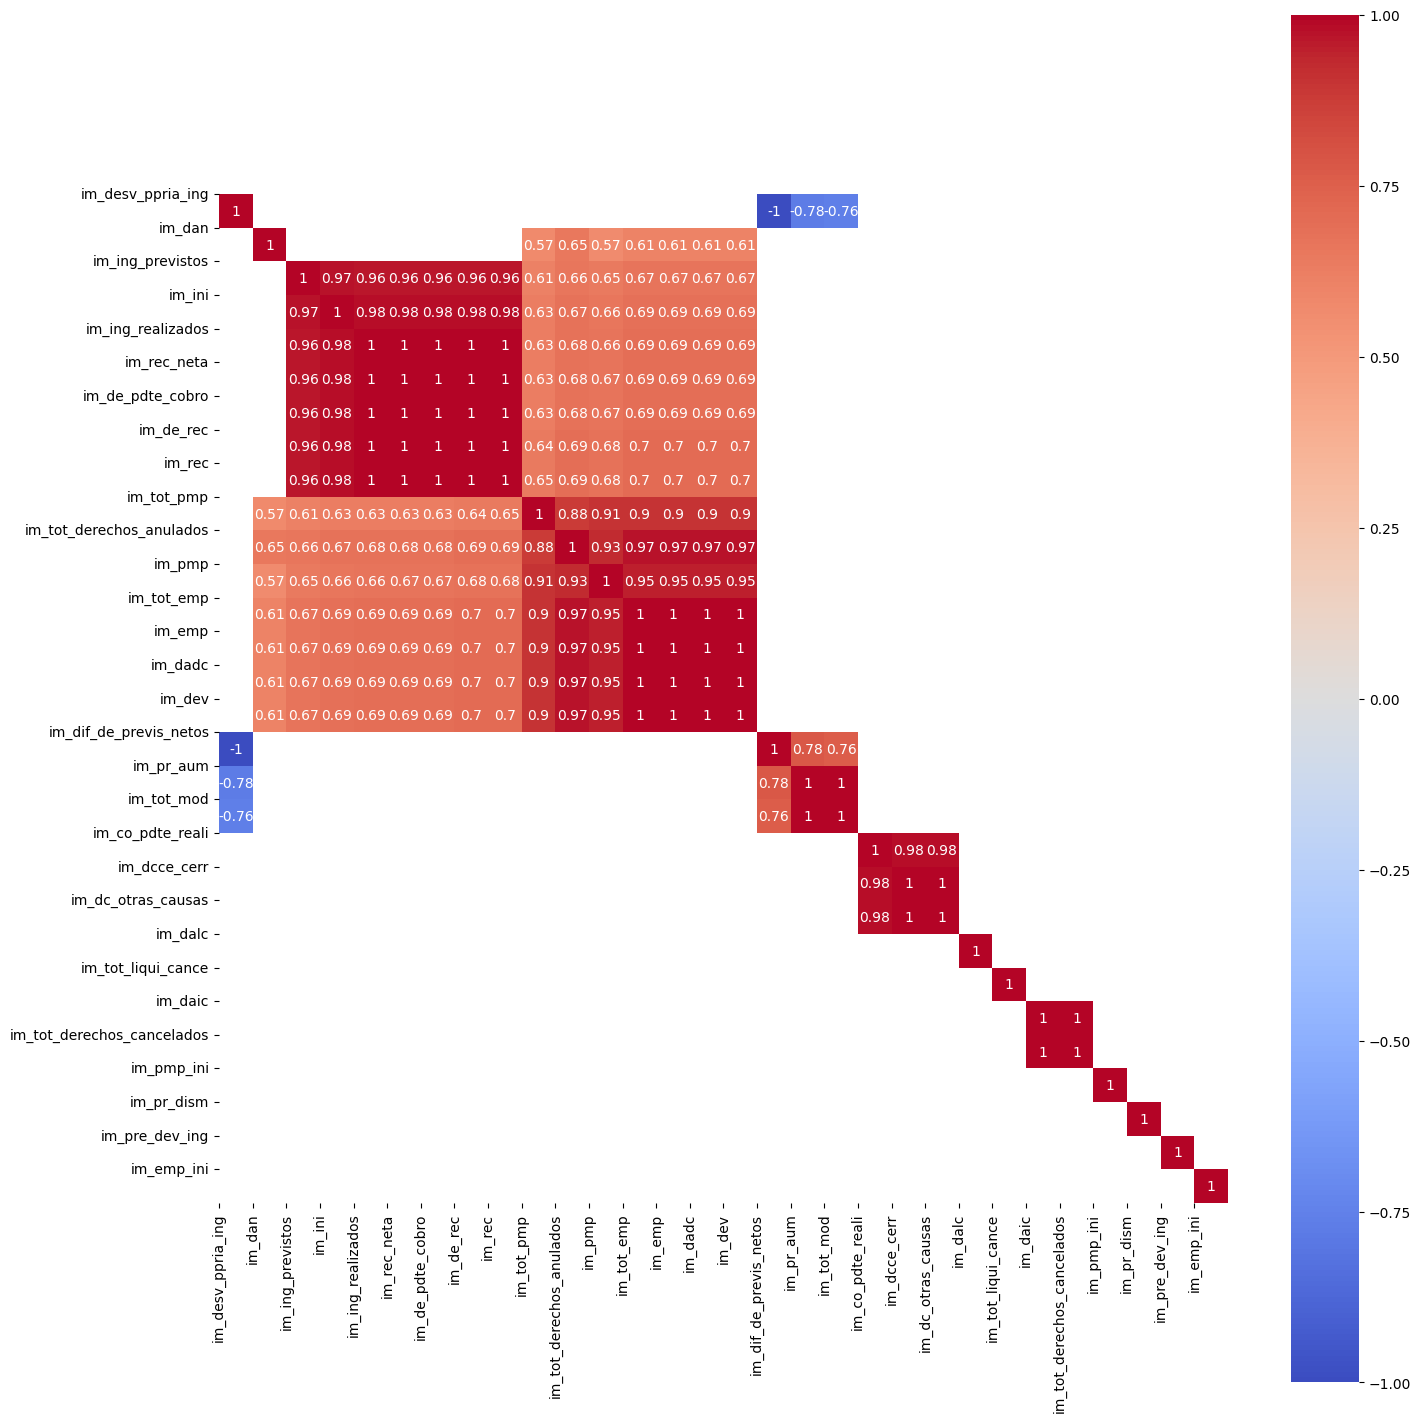

In [87]:
dsp_dendo_y_matriz_corr (df_aux, 'N', 3, 0.5)

### 3.3.4. Selección de atributos

**Datos de población**

Se sabe que en los datos de población solo interesan los nuevos atributos: la población media de los 7 años y la variable discreta de mayor/menor de 5000 habitantes. Por tanto se eliminan el resto de atributos. Se renombra el dataframe.

In [88]:
df_pob = df_pob_7a.drop (['2015',
                          '2016',
                          '2017',
                          '2018',
                          '2019',
                          '2020',
                          '2021',
                          '2022'],
                          axis = 1)

Por homogeneización de valores, se pone a mayúsculas el campo entidad.

In [89]:
df_pob['entidad'] = df_pob['entidad'].str.upper()

In [90]:
df_pob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 76
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   esquema    76 non-null     object 
 1   cp         76 non-null     object 
 2   entidad    76 non-null     object 
 3   pob_media  76 non-null     float64
 4   may_5000   76 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.6+ KB


Diccionario del dataframe final de población: df_pob

|Dataframe|Descripción|
|:-------|:----------|
|df_pob|Población media de los municipios cordobeses desde el año 2015 al 2022|    

|Atributo|Tipo|Descripción|
|:-------|:---|:----------|
|esquema|cadena de caracteres|Identificación del esquema de base de datos|
|cp|cadena de caracteres|Código postal de la entidad. Unívoco|
|entidad|cadena de caracteres|Identificación de la entidad local|
|pob_media|decimal|Media aritmética de la población entre los años 2015 - 2022|
|may_5000|carácter|(S/N) Según la entidad tenga una media igual o superior a 5000 habitantes (S), o no (N)|


**Datos geográficos**

En el caso de los datos geográficos no se elimina ni modifica ningún atributo.

Por homogeneización de valores, se ponen a mayúsculas el campo Comarca y Municipio.

In [91]:
df_comarca['Comarca'] = df_comarca['Comarca'].str.upper()
df_comarca['Municipio'] = df_comarca['Municipio'].str.upper()

In [92]:
df_comarca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comarca    77 non-null     object
 1   Municipio  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


Diccionario del dataframe final de datos geográficos: df_comarca

|Dataframe|Descripción|
|:-------|:----------|
|df_comarca|Relación de entidades presentes en la provincia de Córdoba y comarca a la que pertenecen|    


|Atributo|Tipo|Descripción|
|:-------|:---|:----------|
|Comarca|cadena de caracteres|Zona geográfica cordobesa que agrupa una relación de entidades próximas|
|Municipio|cadena de caracteres|Identificación del municipio|

**Datos económicos**

*Gastos*

En función de las correlaciones vistas anteriormente, y del análisis sobre el conjunto de datos, se deciden eliminar los siguientes atributos, renombrando también el data frame:

In [93]:
df_gastos = df_apli_gastos.drop (['im_pi_ord', # similitud con im_ri_efe
                                  'im_cr_tot', # similitud con gasto presupuestado
                                  'im_tot_gas_au',  # similitud con im_di_gas
                                  'im_ri_put', # similitud con im_tot_rc
                                  'im_dis_vincu', # no se está considerando las bolsas de vinculación
                                  'sal_cre_ret_pte', # los atributos sal- son vble intermedias
                                  'sal_cre_ret_tra', 
                                  'sal_gas_au',
                                  'sal_gas_com',
                                  'sal_obl_rec', # de evolución a lo largo del ejercicio
                                  'vi_org', # no se están considerando las bolsas de vinculación
                                  'vi_pro', # no se están considerando las bolsas de vinculación
                                  'vi_eco', # no se están considerando las bolsas de vinculación
                                  'finalidad_contable' # no se encuentra la semántica de este atributo
                                 ], 
                                 axis = 1)

Por homogeneización de valores, se pone a mayúsculas el campo entidad. Correciones ortográficas.

In [94]:
df_gastos['entidad'] = df_gastos['entidad'].str.upper()

In [95]:
df_gastos['entidad'] = df_gastos['entidad'].replace('LOZ BLAZQUEZ', 'LOS BLAZQUEZ')
df_gastos['entidad'] = df_gastos['entidad'].replace('FUENTE TOJAR', 'FUENTE-TOJAR')
df_gastos['entidad'] = df_gastos['entidad'].replace('VILLAFRANCA', 'VILLAFRANCA DE CORDOBA')

In [96]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174702 entries, 2015-01-01 to 2022-01-01
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   esquema               174702 non-null  object 
 1   id_entidad            174702 non-null  object 
 2   entidad               174702 non-null  object 
 3   id_claso              33543 non-null   object 
 4   ds_claso              33543 non-null   object 
 5   id_clasp              174702 non-null  object 
 6   ds_clasp              174702 non-null  object 
 7   id_clase              174702 non-null  object 
 8   ds_clase              174702 non-null  object 
 9   objetivo              174702 non-null  object 
 10  meta                  174702 non-null  object 
 11  ds_apli               174702 non-null  object 
 12  im_cr_ini             174702 non-null  float64
 13  im_cr_ext             174702 non-null  float64
 14  im_cr_sup             174702 non-nul

Diccionario del dataframe final de aplicaciones de gastos

|Dataframe|Descripción|
|:-------|:----------|
|df_gastos|Conjunto de datos económicos de las entidades de la provincia de Córdoba, por aplicaciones presupuestarias de gastos, durante el período 2015 2022|    


|Atributo|Tipo|Descripción|
|:-------|:---|:----------|
|id_eje|fecha|Ejercicio contable. Índice para el estudio de series temporales|


|Atributo|Tipo|Descripción|
|:-------|:---|:----------|
|esquema|cadena de caracteres|Identificación del esquema de base de datos|
|id_entidad|cadena de caracteres|Identificación de la entidad local|
|entidad|cadena de caracteres|Descripción de la entidad local|
|id_claso|cadena de caracteres|Código clasificación orgánica|
|ds_claso|cadena de caracteres|Descripción clasificación orgánica|
|id_clasp|cadena de caracteres|Código clasificación programa de gasto|
|ds_clasp|cadena de caracteres|Descripción clasificación programa de gasto|
|id_clase|cadena de caracteres|Código clasificación económica|
|ds_clase|cadena de caracteres|Descripción clasificación económica|
|objetivo |cadena de caracteres|Objetivo de desarrollo sostenible|
|meta|cadena de caracteres|Meta del objetivo de desarrollo sostenible|
|ds_apli |cadena de caracteres|Descripción de la aplicación presupuestaria|
|im_cr_ini|número decimal|Importe de créditos aprobados definitivos|
|im_cr_ext|número decimal|Importe de créditos extraordinarios|
|im_cr_sup|número decimal|Importe de suplementos de crédito|
|im_cr_amp|número decimal|Importe de ampliaciones de crédito´|
|im_tr_neg|número decimal|Importe de transferencias negativas de crédito|
|im_tr_pos|número decimal|Importe de transferencias positivas de crédito|
|im_in_rem|número decimal|Importe de incorporación de remanentes de crédito|
|im_mo_ing|número decimal|Importe de modificaciones de crédito generadas por ingresos|
|im_mo_baj|número decimal|Importe de bajas por anulación|
|im_mod_tot_cre|número decimal|Importe total de modificaciones de crédito|
|im_cr_dis|número decimal|Importe de crédito disponible|
|im_ri_tra|número decimal|Importe de créditos retenidos para transferencias|
|im_cr_nod|número decimal|Importe de créditos no disponibles|
|im_tot_rc|número decimal|Importe total de créditos retenidos|
|im_ai_ret|número decimal|Importe de autorizado sobre retenido|
|im_ai_dis|número decimal|Importe de autorizado sobre disponible|
|im_di_gas|número decimal|Importe de gastos comprometidos|
|im_gas_ejecutado|número decimal|Variable objetivo. Importe total de los gastos ejecutados|
|im_ri_efe|número decimal|Importe de pagos efectuados|
|im_ri_rei|número decimal|Importe de reintegros|
|im_comno|número decimal|Importe de remanentes comprometidos no incorporables|
|im_comin|número decimal|Importe de remanentes comprometidos incorporables|
|im_nocomno|número decimal|Importe de remanentes no comprometidos no incorporables|
|im_nocomin|número decimal|Importe de remanentes no comprometidos incorporables|
|obj_meta|cadena de caracteres|Concatenación del objetivo y la meta|
|im_gas_prespuestado|número decimal|Variable objetivo. Importe total del gasto presupuestado|
|im_desv_ppria_gas|número decimal|Variable objetivo. Importe de la desviación presupuestaria de gastos producida en el ejercicio|

*Ingresos*

En función de las correlaciones vistas anteriormente, y del análisis sobre el conjunto de datos, se deciden eliminar los siguientes atributos, renombrando también el data frame:

In [97]:
df_ingresos = df_apli_ingresos.drop (['im_dadc', # similitud con im_tot_emp
                                      'im_daic', # similitud con im_tot_derechos_cancelados
                                      'im_dev',  # similitud con im_tot_emp
                                      'im_emp',  # similitud con im_tot_emp
                                      'im_dcce_cerr', # similitud con im_dc_otras_causas
                                      'im_dif_de_previs_netos'
                                     ], 
                                     axis = 1)

Por homogeneización de valores, se pone a mayúsculas el campo entidad. Correcciones ortográficas.

In [98]:
df_ingresos['entidad'] = df_ingresos['entidad'].str.upper()

In [99]:
df_ingresos['entidad'] = df_ingresos['entidad'].replace('LOZ BLAZQUEZ', 'LOS BLAZQUEZ')
df_ingresos['entidad'] = df_ingresos['entidad'].replace('FUENTE TOJAR', 'FUENTE-TOJAR')
df_ingresos['entidad'] = df_ingresos['entidad'].replace('VILLAFRANCA', 'VILLAFRANCA DE CORDOBA')

In [100]:
df_ingresos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40469 entries, 2015-01-01 to 2022-01-01
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   esquema                     40469 non-null  object 
 1   id_entidad                  40469 non-null  object 
 2   entidad                     40469 non-null  object 
 3   id_claso                    1068 non-null   object 
 4   ds_claso                    1068 non-null   object 
 5   id_clase                    40469 non-null  object 
 6   ds_clase                    40469 non-null  object 
 7   ds_apli                     40469 non-null  object 
 8   im_ini                      40469 non-null  float64
 9   im_pr_aum                   40469 non-null  float64
 10  im_pr_dism                  40469 non-null  float64
 11  im_tot_mod                  40469 non-null  float64
 12  im_ing_previstos            40469 non-null  float64
 13  im_co_cer     

Diccionario del dataframe final de aplicaciones de ingresos

|Dataframe|Descripción|
|:-------|:----------|
|df_ingresos|Conjunto de datos económicos de las entidades de la provincia de Córdoba, por aplicaciones presupuestarias de ingresos, durante el período 2015 2022|    


|Atributo|Tipo|Descripción|
|:-------|:---|:----------|
|id_eje|fecha|Ejercicio contable. Índice para el estudio de series temporales|


|Atributo|Tipo|Descripción|
|:-------|:---|:----------|
|esquema|cadena de caracteres|Identificación del esquema de base de datos|
|id_entidad|cadena de caracteres|Identificación de la entidad local|
|entidad|cadena de caracteres|Descripción de la entidad local|
|id_claso|cadena de caracteres|Código clasificación orgánica|
|ds_claso|cadena de caracteres|Descripción clasificación orgánica|
|id_clase|cadena de caracteres|Código clasificación económica|
|ds_clase|cadena de caracteres|Descripción clasificación económica|
|ds_apli |cadena de caracteres|Descripción de la aplicación presupuestaria de ingresos|
|im_ini|Número decimal|Importe de previsiones iniciales de ingresos|
|im_pr_aum|Número decimal|Importe de aumento sobre las previsiones iniciales |
|im_pr_dism|Número decimal|Importe de disminuciones sobre las previsiones iniciales  |
|im_ing_previstos|Número decimal|Variable objetivo. Importe total de los ingresos previstos|
|im_co_cer|Número decimal|Importe de compromisos concertados de presupuestos cerrados|
|im_co_cte|Número decimal|Importe de compromisos imputables al presupuesto corriente|
|im_co_ecte|Número decimal|Importe de compromisos ejecutados en el presupuesto corriente|
|im_concertado|Número decimal|Importe concertado|
|im_co_cre|Número decimal|Importe de compromisos realizados |
|im_co_pdte_reali|Número decimal|Importe de compromisos pendientes de realizar|
|im_de_rec|Número decimal|Importe de derechos reconocidos|
|im_dan|Número decimal|Importe de derechos anulados|
|im_dalc|Número decimal|Importe de derechos anulados de liquidaciones|
|im_ing_realizados|Número decimal|Variable objetivo. Importe total de los ingresos realizados|
|im_rec|Número decimal|Importe de recaudado |
|im_rec_neta|Número decimal|Importe de la recaudacion neta|
|im_de_pdte_cobro|Número decimal|Importe de derechos pendientes de cobro|
|im_tot_liqui_cance|Número decimal|Importe de total de liquidaciones canceladas |
|im_pmp|Número decimal|Importe de propuestas de mandamiento de pago |
|im_pre_dev_ing|Número decimal|Importe de previsión de devolucion de ingresos|
|im_rec_dev_ing|Número decimal|Importe de recaudacion por devolución de ingresos|
|im_pmp_ini|Número decimal|Importe de inicial de propuesta de mandamiento de pago|
|im_emp_ini|Número decimal|Importe de inicial de expediente de mandamiento de pago|
|im_daaf|Número decimal|Importe *no facilitado* |
|im_daaf_cerr|Número decimal|Importe *no facilitado*|
|im_dcce|Número decimal|Importe *no facilitado*|
|im_dcce_cerr|Número decimal|Importe *no facilitado*|
|im_tot_pmp|Número decimal|Importe total de propuesta de mandamiento de pago|
|im_tot_emp|Número decimal|Importe total de expediente de mandamiento de pago|
|im_dc_otras_causas|Número decimal|Importe de devolución por otras causas|
|im_tot_derechos_anulados|Número decimal|Importe total de derechos anulados|
|im_tot_derechos_cancelados|Número decimal|Importe total de derechos cancelados|
|im_dcce|Número decimal|Importe *no facilitado*|
|im_tot_pmp|Número decimal|Importe total de propuesta de mandamiento de pago|
|im_tot_emp|Número decimal|Importe total de expediente de mandamiento de pago|
|im_dc_otras_causas|Número decimal|Importe de devolución por otras causas|
|im_tot_derechos_anulados|Número decimal|Importe total de derechos anulados|
|im_tot_derechos_cancelados|Número decimal|Importe total de derechos cancelados|
|im_desv_ppria_ing|Número decimal|Variable objetivo. Importe de la desviación presupuestaria de ingresos producida en el ejercicio|

### 3.3.5. Integración de datos

Se completa la información con respecto la población: la Diputación Provincial, en las entregas de cuentas al Ministerio, presenta como población la totalidad de la población de la provincia. Para el caso que nos ocupa, se asume la suma de las medias de los municipios como población para este estudio.

In [101]:
df_pob.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 76
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   esquema    76 non-null     object 
 1   cp         76 non-null     object 
 2   entidad    76 non-null     object 
 3   pob_media  76 non-null     float64
 4   may_5000   76 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.6+ KB


In [102]:
try:
    # Solo se van a tener en cuenta las entidades fuera de la capital de provincia Y la Diputación
    
    df_pob = df_pob.drop (df_pob[df_pob['esquema'] == '1021'].index)
    df_comarca = df_comarca.drop (df_comarca[df_comarca['Municipio'] == 'CÓRDOBA'].index)
    
    suma_pob_media = df_pob['pob_media'].sum()
    
    ent_diputacion = pd.DataFrame({'esquema': ['2000'],
                                   'cp': ['14000'],
                                   'entidad': ['DIPUTACIÓN PROVINCIAL DE CÓRDOBA'],
                                   'pob_media': [suma_pob_media],
                                   'may_5000': ['S']
                                  })
    
    df_pob = pd.concat([df_pob, ent_diputacion], 
                       ignore_index = True)
    
except Exception as e:
    print("Error cod 140. Error al añadir la entidad Diputación al dataframe df_pob: ",           
          str(e))    

In [103]:
# Unión de ambos dataframes por los campos 'Municipio' y 'entidad'
# Se renombra el atributo pob_media a pob_media_entidad
# Se crea un nuevo atributo que sea el de la población media de la comarca: pob_media_comarca
try: 
    df_com_pob = df_pob.merge(df_comarca[['Comarca', 'Municipio']], 
                              left_on = 'entidad',
                              right_on = 'Municipio', 
                              how = 'left')

    df_com_pob.drop ('Municipio', 
                     axis = 1, 
                     inplace = True)
    df_com_pob.rename (columns = {'pob_media': 'pob_media_entidad'}, 
                       inplace = True)
    df_com_pob['pob_media_comarca'] = df_com_pob.groupby('Comarca')['pob_media_entidad'].transform('sum')
    
    ## tratamiento de la fila de Diputación
    df_com_pob.loc[df_com_pob['esquema'] == '2000', 
                   'Comarca'] = 'DIPUTACIÓN PROVINCIAL DE CÓRDOBA'

    df_com_pob.loc[df_com_pob['esquema'] == '2000', 'pob_media_comarca'] = df_com_pob.loc[df_com_pob['esquema'] == '2000', 'pob_media_entidad'].values[0]
    
    df_com_pob = df_com_pob.drop ('esquema',
                                  axis = 1)
    
except Exception as e:
    print("Error cod 150. Error al crear dataframe df_com_pob: ",           
          str(e))    

Se escoge desnormalizar completamente la estructura de datos a tratar por cuestión de tiempo. Una línea de mejora sería integrar los dataframes en un diccionario y trabajar con él. Se unen en un mismo dataframe los datos de población, geográficos y económicos de gastos. Se actuaría igual para el dataframe de ingresos. Se desactiva el índice para mejorar el tratamiento en el merge. Posteriormente se vuelve a activar.

In [104]:
df_gastos = df_gastos.reset_index() 
df_ingresos = df_ingresos.reset_index()

In [105]:
try: 
    # Se eliminan tildes
    df_com_pob['entidad'] = df_com_pob['entidad'].apply(unidecode)
    df_gastos['entidad'] = df_gastos['entidad'].apply(unidecode)
    
    df_gastosf = df_com_pob.merge (df_gastos, 
                                   on = 'entidad',
                                   how = 'outer')
    
    # Verificar si hay inconsistencias en la unión
    num_rows_original = len (df_com_pob) + len(df_gastos)
    num_rows_final = len (df_gastosf)
    
    # verificación básica
    if num_rows_final > num_rows_original:
        print ("Se han encontrado inconsistencias al crear el dataframe df_gastosf.")       
    else:
        print ("No se han encontrado inconsistencias al crear el dataframe df_gastosf.")       

except Exception as e:
    print ("Error cod 160. Error al crear dataframe df_gastosf: ",    
           str(e))    

No se han encontrado inconsistencias al crear el dataframe df_gastosf.


In [106]:
try:
    # Se eliminan tildes
    
    df_ingresos['entidad'] = df_ingresos['entidad'].apply(unidecode)
    
    df_ingresosf = df_com_pob.merge (df_ingresos, 
                                     on = 'entidad', 
                                     how = 'outer')
    
    # Verificar si hay inconsistencias en la unión
    num_rows_original = len (df_com_pob) + len (df_ingresos)
    num_rows_final = len (df_ingresosf)
    
    # verificación básica
    if num_rows_final > num_rows_original:
        print ("Se han encontrado inconsistencias al crear el dataframe df_ingresosf.")       
    else:
        print ("No se han encontrado inconsistencias al crear el dataframe df_ingresosf.")       

except Exception as e:
    print ("Error cod 170. Error al crear dataframe df_ingresosf: ",           
           str(e))    

No se han encontrado inconsistencias al crear el dataframe df_ingresosf.


In [107]:
df_gastos = df_gastos.set_index ('id_eje')  
df_gastosf = df_gastosf.set_index ('id_eje') 
df_ingresos = df_ingresos.set_index ('id_eje')  
df_ingresosf = df_ingresosf.set_index ('id_eje')  

Se depuran las filas que tienen a nulo el atributo esquema. Se detecta que se corresponden con Montalbán de Córdoba y Villanueva de Córdoba, que son dos entidades de las que no se tienen datos de contabilidad.     
Se rellenan con un valor no significativo los atributos de la clasificación orgánica que están a nulo.     
Se ordenan los dataframes.     

In [108]:
try: 
    aux_nulos = df_gastosf[df_gastosf['esquema'].isnull()]
    print(aux_nulos)
    
    # Eliminación de filas con atributo esquema a null
    df_gastosf = df_gastosf.dropna(subset=['esquema'])
    df_ingresosf = df_ingresosf.dropna(subset=['esquema'])

    # Asignación de un valor arbitrario a los campos de clasificación orgánica que no tienen valores
    df_gastosf['id_claso'].fillna('000', 
                                  inplace = True)
    df_gastosf['ds_claso'].fillna('Sin orgánica', 
                                  inplace = True)
    df_ingresosf['id_claso'].fillna('000', 
                                    inplace = True)
    df_ingresosf['ds_claso'].fillna('Sin orgánica', 
                                    inplace = True)

    df_gastosf.sort_index (inplace = True)
    df_ingresosf.sort_index (inplace = True)
    # Resultado final
    df_gastosf.info()
    df_ingresosf.info()
except Exception as e:
    print ("Error cod 180. Error al limpiar de valores nulos los dataframes finales: ",           
           str(e))      


           cp                entidad  pob_media_entidad may_5000        Comarca  pob_media_comarca esquema id_entidad id_claso ds_claso  ... im_gas_ejecutado im_ri_efe im_ri_rei im_comno im_comin im_nocomno im_nocomin  obj_meta  im_gas_presupuestado  im_desv_ppria_gas
id_eje                                                                                                                                   ...                                                                                                                                
NaT     14040   MONTALBAN DE CORDOBA           4476.000        N    CAMPIÑA SUR         105029.875     NaN        NaN      NaN      NaN  ...              NaN       NaN       NaN      NaN      NaN        NaN        NaN       NaN                   NaN                NaN
NaT     14069  VILLANUEVA DE CORDOBA           8806.875        S  LOS PEDROCHES          52817.375     NaN        NaN      NaN      NaN  ...              NaN       NaN       NaN      NaN      N

### 3.3.6. Análisis de los componentes de la serie temporal

Inicialización de listas.

In [109]:
# Creación de las listas de atributos que más adelante serán utilizados

# Lista de objetivos de gastos
obj_gas = ['im_gas_presupuestado', 
           'im_gas_ejecutado', 
           'im_desv_ppria_gas']
# Lista de objetivos de gastos con colores asociados para su visualización
col_gas = {'im_gas_presupuestado': 'tab:blue', 
           'im_gas_ejecutado': 'tab:red', 
           'im_desv_ppria_gas': 'tab:green'}

# Lista de atributos importe de gastos no objetivos
im_gas = ['im_cr_ini',
          'im_cr_ext',
          'im_cr_sup',
          'im_cr_amp',
          'im_tr_neg',
          'im_tr_pos',
          'im_in_rem',
          'im_mo_ing',
          'im_mo_baj',
          'im_mod_tot_cre',
          'im_cr_dis',
          'im_ri_tra',
          'im_cr_nod',
          'im_tot_rc',
          'im_ai_ret',
          'im_ai_dis',
          'im_di_gas',
          'im_ri_efe',
          'im_ri_rei',
          'im_comno',
          'im_comin',
          'im_nocomno',
          'im_nocomin',
          'im_gas_presupuestado',
          'im_gas_ejecutado',
          'im_desv_ppria_gas']

# Lista de objetivos de ingresos
obj_ing = ['im_ing_previstos', 
           'im_ing_realizados', 
           'im_desv_ppria_ing']

# Lista de objetivos de ingresos con colores asociados para su visualización
col_ing = {'im_ing_previstos': 'tab:blue', 
           'im_ing_realizados': 'tab:red', 
           'im_desv_ppria_ing': 'tab:green'}

# Lista de atributos importe de ingresos no objetivos
im_ing = ['im_ini',
          'im_pr_aum',
          'im_pr_dism',
          'im_tot_mod',
          'im_ing_previstos',
          'im_co_cer',
          'im_co_cte',
          'im_co_ecte',
          'im_concertado',
          'im_co_cre',
          'im_co_pdte_reali',
          'im_de_rec',
          'im_dan',
          'im_dalc',
          'im_ing_realizados',
          'im_rec',
          'im_rec_neta',
          'im_de_pdte_cobro',
          'im_tot_liqui_cance',
          'im_pmp',
          'im_pre_dev_ing',
          'im_rec_dev_ing',
          'im_pmp_ini',
          'im_emp_ini',
          'im_daaf',
          'im_daaf_cerr',
          'im_dcce',
          'im_tot_pmp',
          'im_tot_emp',
          'im_dc_otras_causas',
          'im_tot_derechos_anulados',
          'im_tot_derechos_cancelados',
          'im_desv_ppria_ing']

# índice de transparencia en los colores usados
transparencia = 0.7

**Tendencia general**

La tendencia representa la dirección general y sostenida en el tiempo de una serie temporal. Puede ser ascendente, descendente o constante. La tendencia ayuda a identificar el comportamiento a largo plazo de la serie, mostrando la evolución general y a largo plazo de la serie temporal, eliminando las variaciones estacionales y cíclicas.

*Gastos*

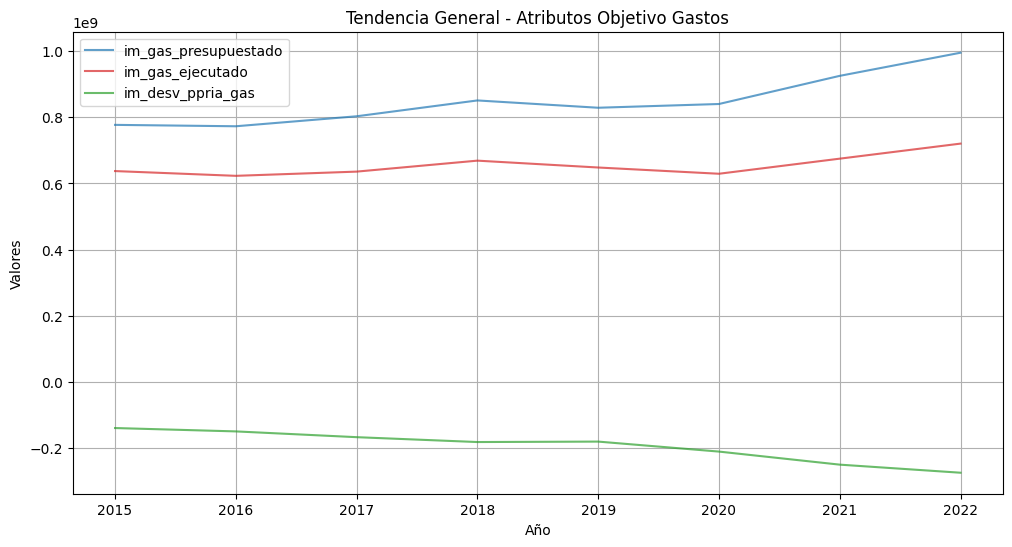

In [110]:
try: 
    df_aux_gas = df_gastosf.copy()
    # tratamiento del atributo índice
    df_aux_gas.index = df_aux_gas.index.to_period('A').strftime('%Y')
    # Cálculo de la suma de cada objetivo por año
    sum_anno_gas = df_aux_gas.groupby(df_aux_gas.index)[obj_gas].sum()
    
    plt.figure (figsize = (12, 
                           6))
    ax = plt.gca()

    # bucle para los 3 atributos objetivo. Crear las líneas en la gráfica
    for atributo in obj_gas:
        ax.plot(df_aux_gas.index.unique(), 
                sum_anno_gas[atributo], 
                label = atributo, 
                color = col_gas[atributo], 
                alpha = transparencia)

    # Configurar el título, etiquetas de ejes y leyenda
    plt.xlabel ('Año')
    plt.ylabel ('Valores')
    plt.title ('Tendencia General - Atributos Objetivo Gastos')
    plt.legend ()
    plt.grid (True)
    plt.show ()
    
except Exception as e:
    print ("Error cod 190. Error al visualizar las tendencias en gastos: ",           
           str(e))          

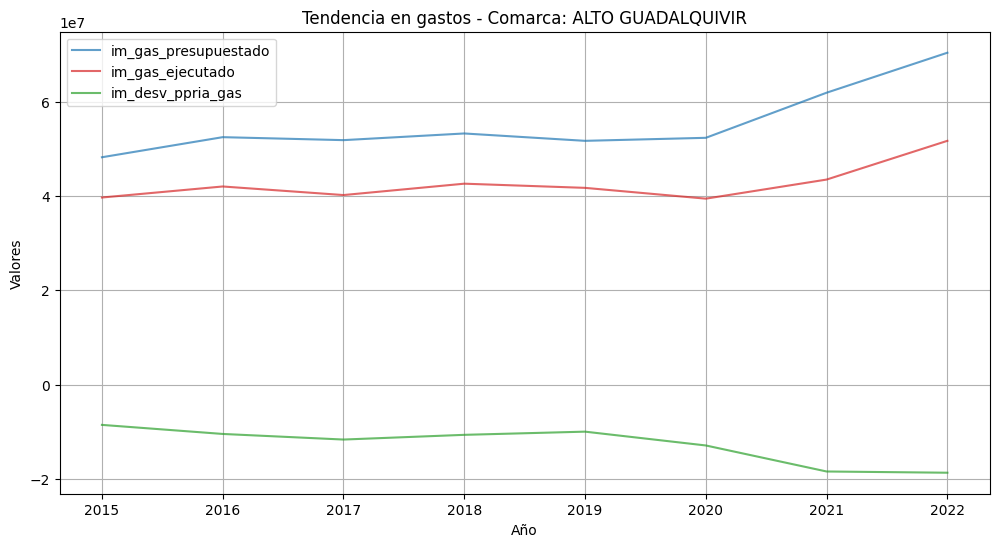

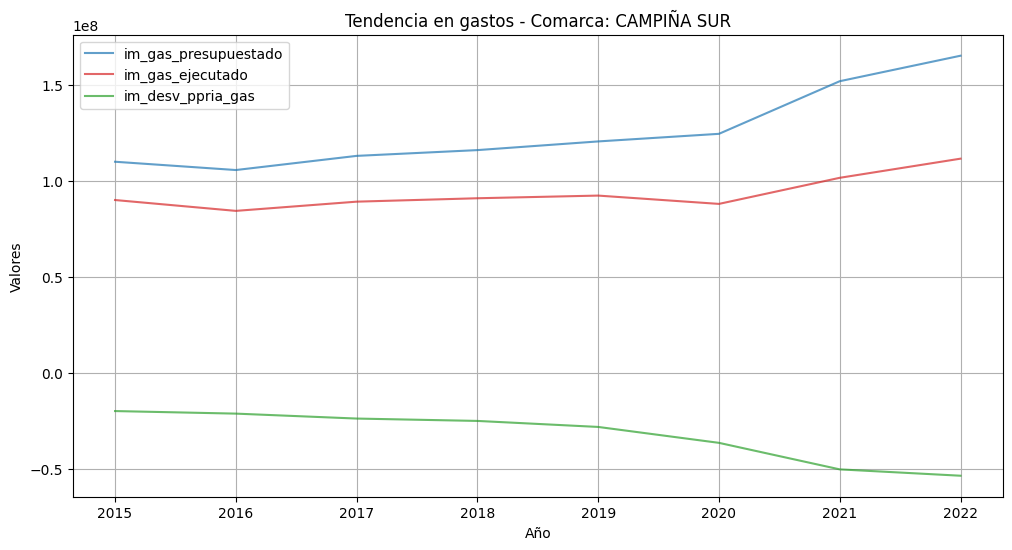

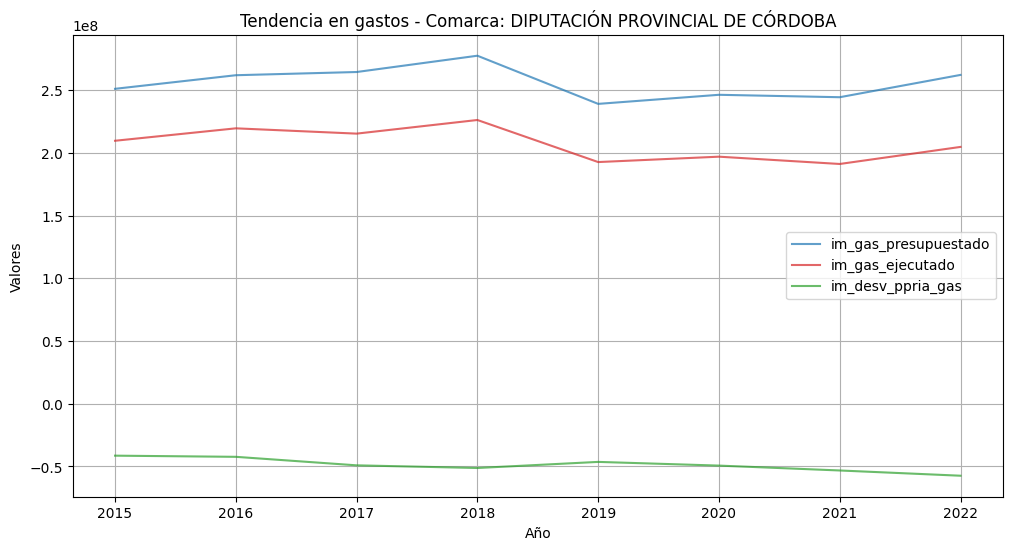

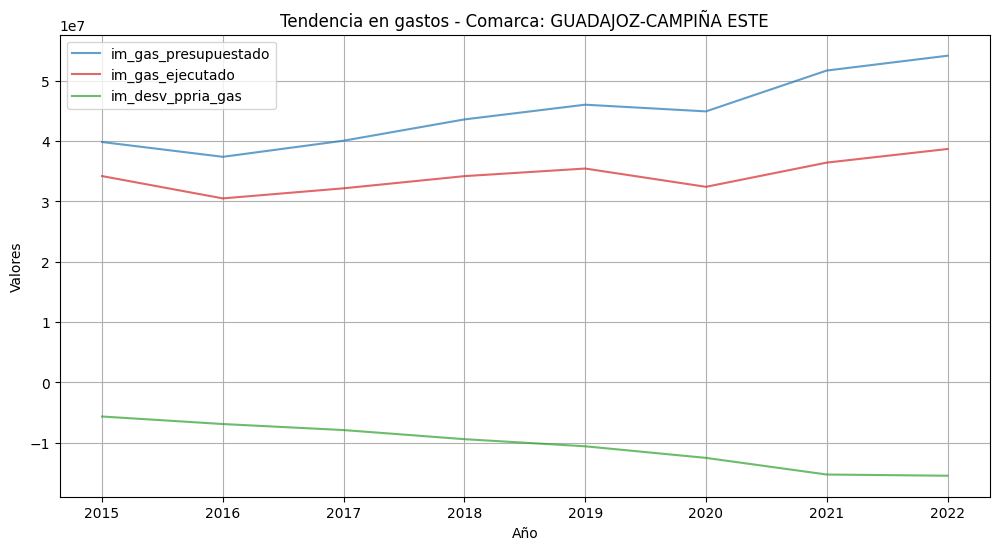

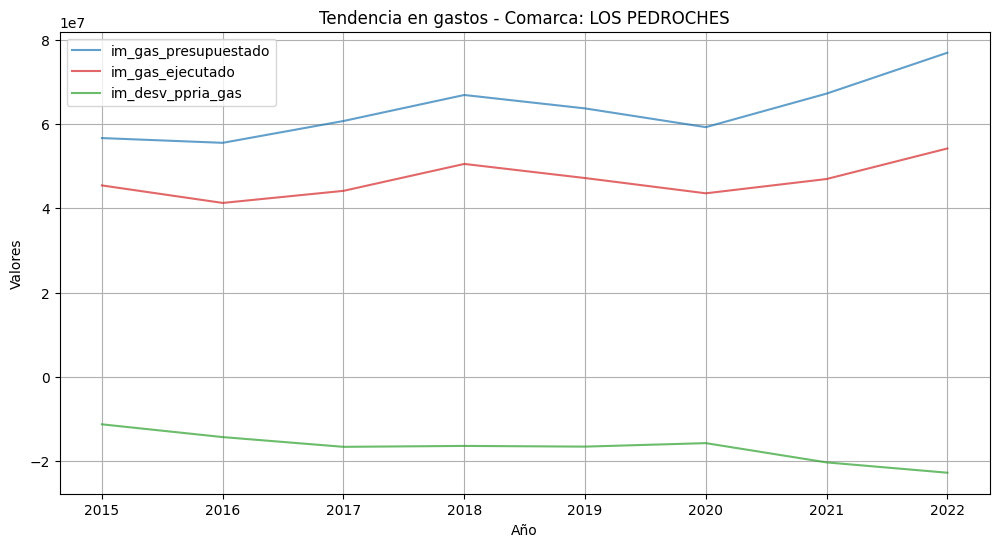

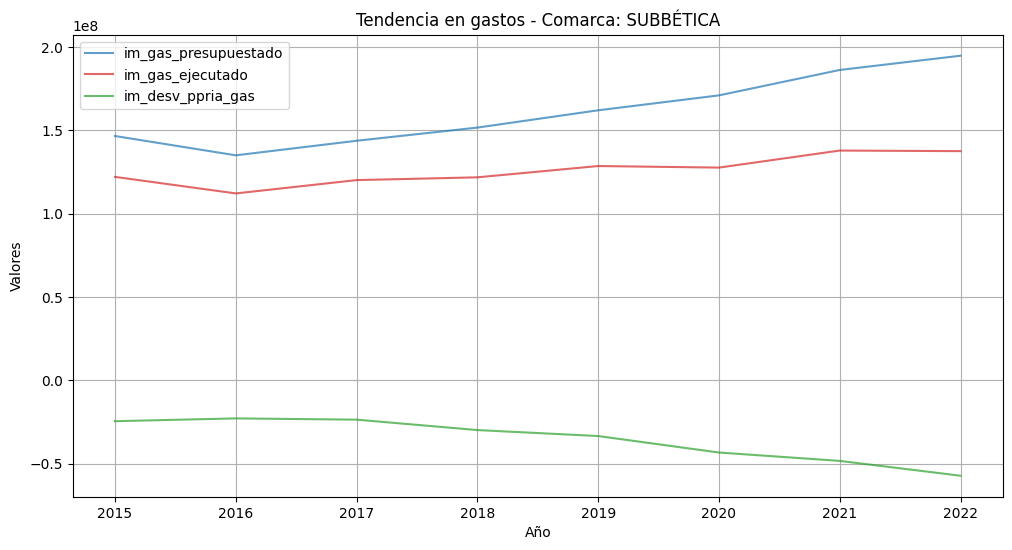

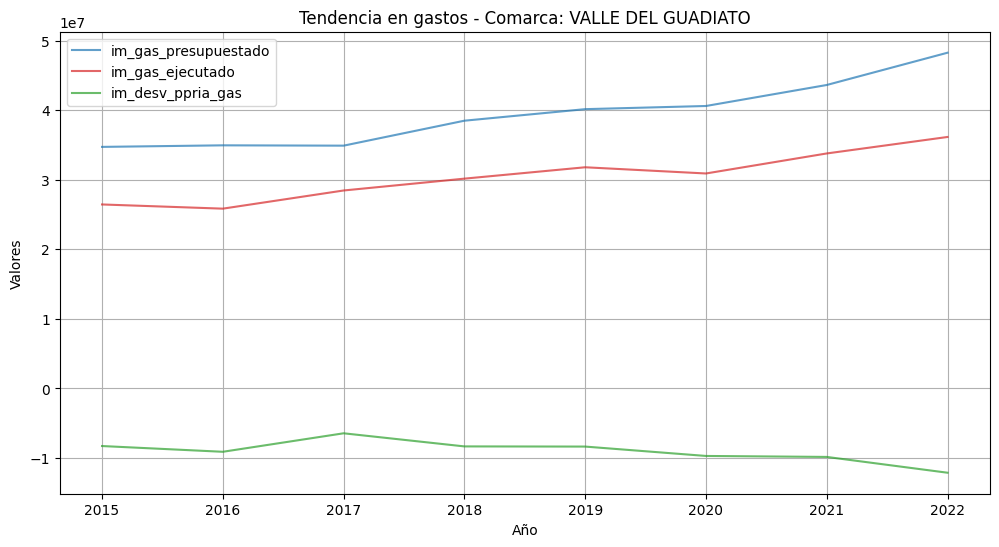

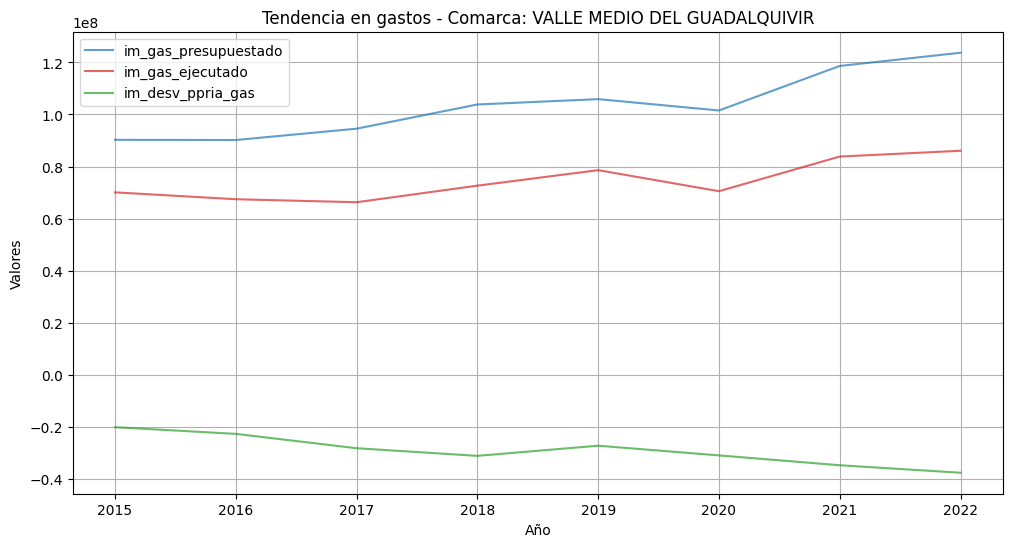

In [111]:
try:
    # Agrupación por comarca
    comarcas_grouped = df_aux_gas.groupby ('Comarca')

    # Bucle por comarca para el estudio individual de cada una
    for comarca, data in comarcas_grouped:
        plt.figure (figsize = (12, 
                               6))
        ax = plt.gca()

        # Iterar sobre los atributos objetivo y crear las líneas en la gráfica
        for atributo in obj_gas:
            ax.plot (data.index.unique(), 
                     data.groupby(data.index)[atributo].sum(), 
                     label = atributo, 
                     color = col_gas[atributo], 
                     alpha = transparencia)

        # Configurar el título, etiquetas de ejes y leyenda para cada gráfica
        plt.xlabel ('Año')
        plt.ylabel ('Valores')
        plt.title (f'Tendencia en gastos - Comarca: {comarca}')
        plt.legend ()
        plt.grid (True)
        plt.show ()

except Exception as e:
    print ("Error cod 200. Error al visualizar las tendencias en gastos por comarcas: ", 
           str(e))

*Ingresos*

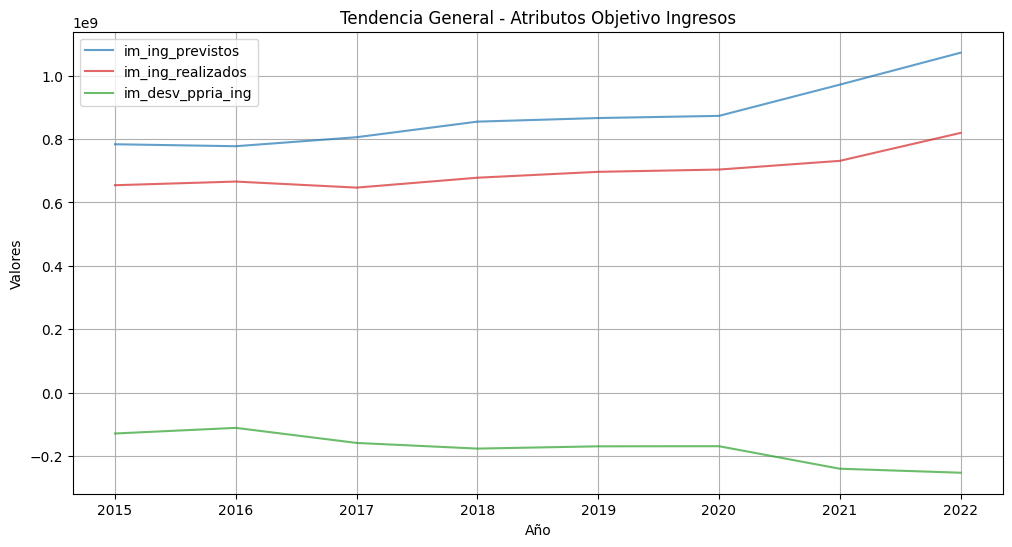

In [112]:
try: 
    df_aux_ing = df_ingresosf.copy()
    # tratamiento del atributo índice
    df_aux_ing.index = df_aux_ing.index.to_period('A').strftime('%Y')
    # Cálculo de la suma de cada objetivo por año
    sum_anno_ing = df_aux_ing.groupby(df_aux_ing.index)[obj_ing].sum()
    
    plt.figure (figsize = (12, 
                           6))
    ax = plt.gca()

    # bucle para los 3 atributos objetivo. Crear las líneas en la gráfica
    for atributo in obj_ing:
        ax.plot (df_aux_ing.index.unique(),                 
                 sum_anno_ing[atributo], 
                 label = atributo, 
                 color = col_ing[atributo], 
                 alpha = transparencia)

    # Configurar el título, etiquetas de ejes y leyenda
    plt.xlabel ('Año')
    plt.ylabel ('Valores')
    plt.title ('Tendencia General - Atributos Objetivo Ingresos')
    plt.legend ()
    plt.grid (True)
    plt.show ()
    
except Exception as e:
    print ("Error cod 205. Error al visualizar las tendencias en ingresos: ",           
           str(e))          

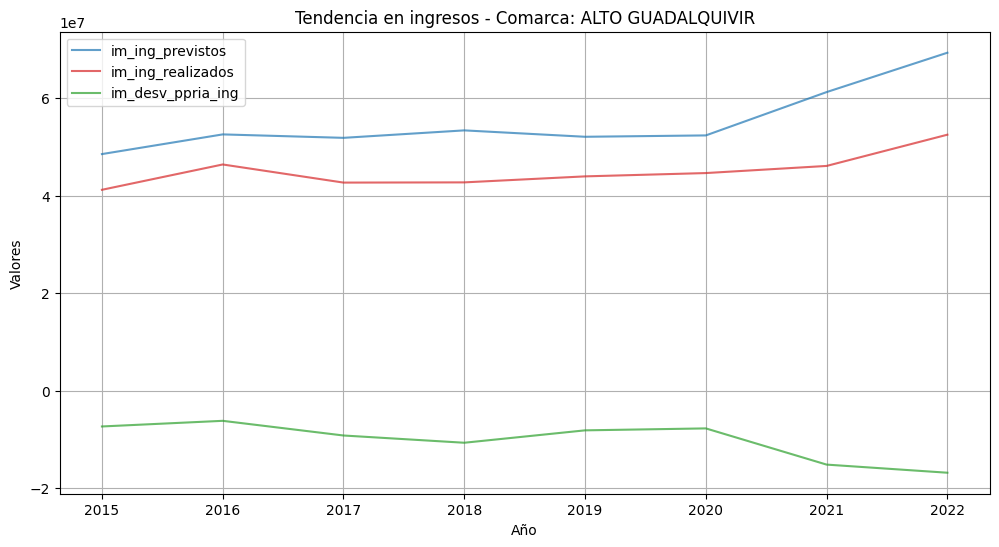

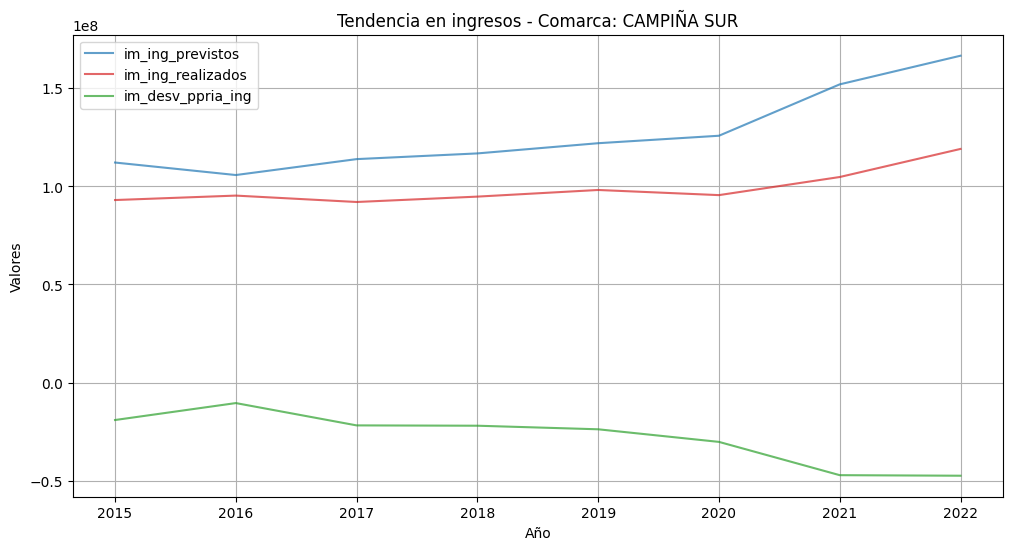

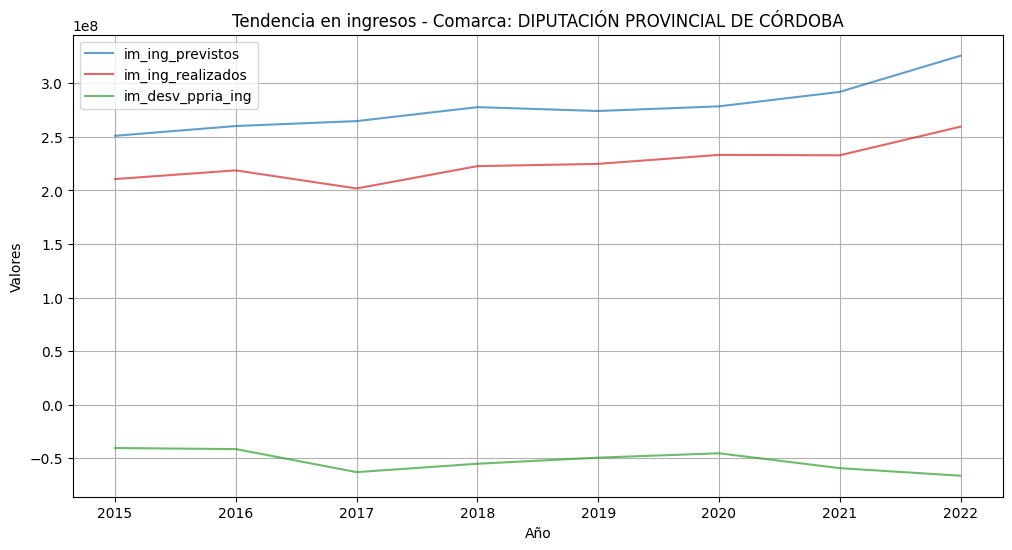

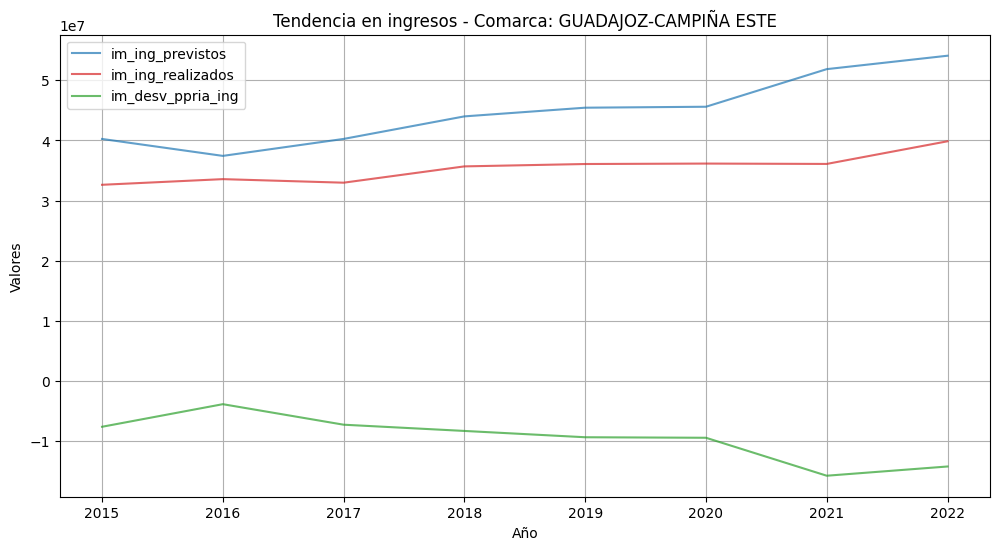

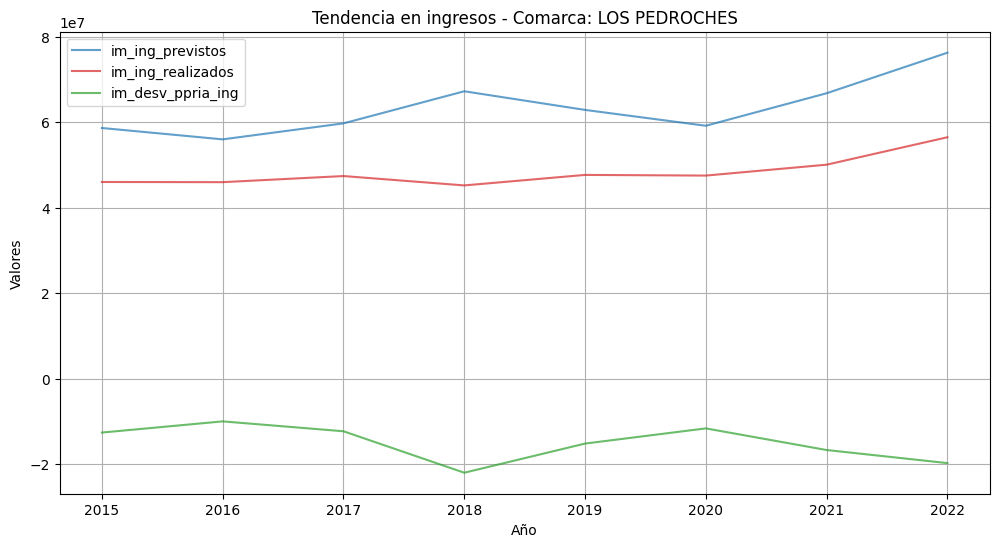

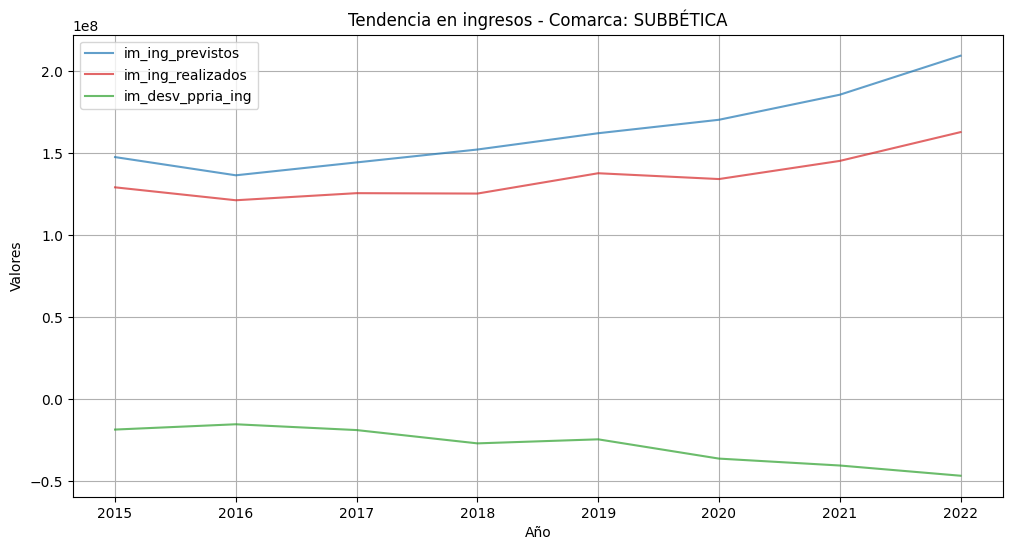

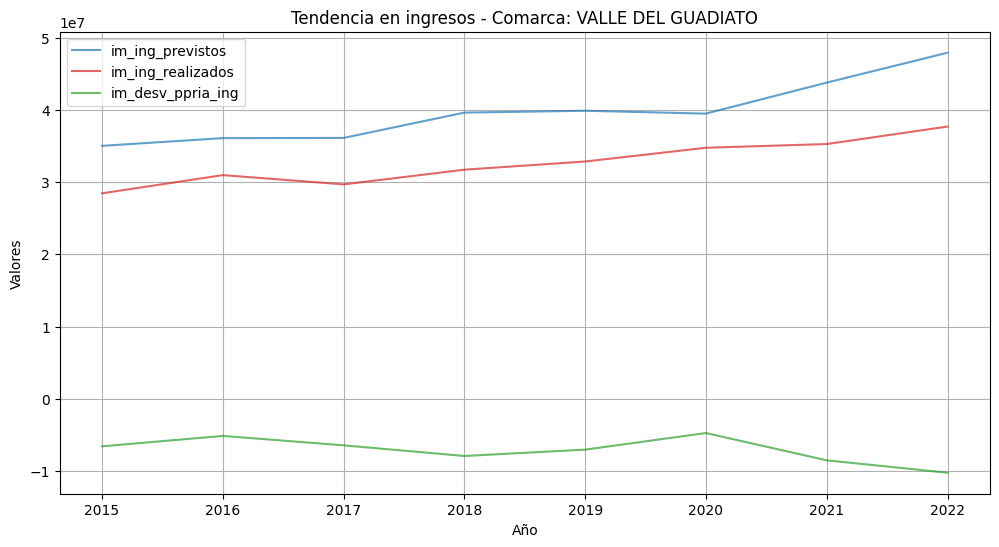

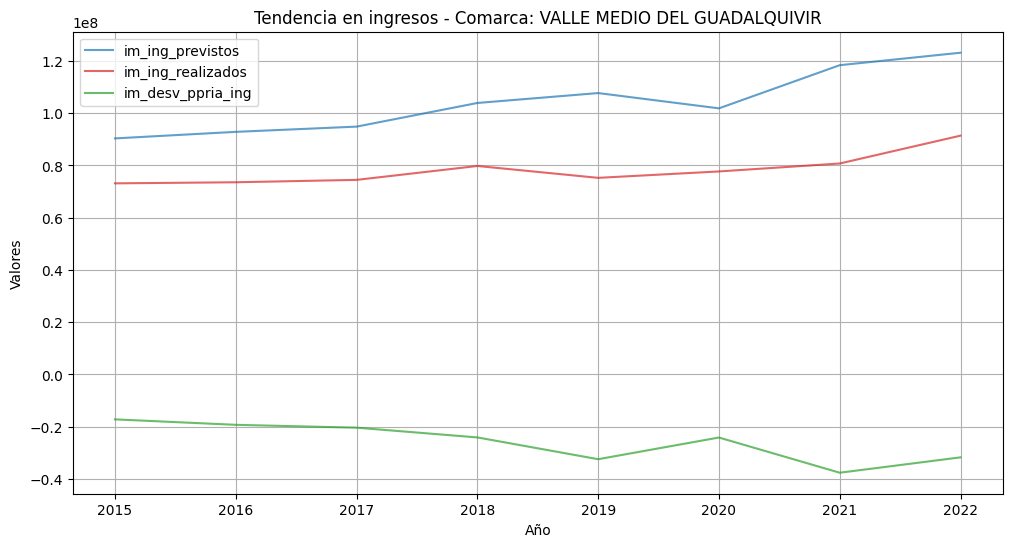

In [113]:
try:
    # Agrupación por comarca
    comarcas_grouped = df_aux_ing.groupby ('Comarca')

    # Bucle por comarca para el estudio individual de cada una
    for comarca, data in comarcas_grouped:
        plt.figure (figsize = (12, 
                               6))
        ax = plt.gca()

        # Iterar sobre los atributos objetivo y crear las líneas en la gráfica
        for atributo in obj_ing:
            ax.plot(data.index.unique(), 
                    data.groupby(data.index)[atributo].sum(), 
                    label = atributo, 
                    color = col_ing[atributo], 
                    alpha = transparencia)

        # Configurar el título, etiquetas de ejes y leyenda para cada gráfica
        plt.xlabel ('Año')
        plt.ylabel ('Valores')
        plt.title (f'Tendencia en ingresos - Comarca: {comarca}')
        plt.legend ()
        plt.grid (True)
        plt.show ()

except Exception as e:
    print ("Error cod 206. Error al visualizar las tendencias en gastos por comarcas: ", 
           str(e))

## ----------

## ATENCIÓN: 




En este punto se realiza un *cambio de criterio*. Se decide agrupar los datos por año y calcular la suma de los valores para cada atributo objetivo en cada año. Se usarán estas agregaciones para realizar la descomposición estacional. El objetivo principal es identificar patrones de tendencia y estacionalidad en la serie temporal. Se prescinde de patrones específicos por comarca. El conjunto de datos iniciales presenta una serie de problemas que, a estas alturas del desarrollo del trabajo, se hacen difíciles de corregir. Entre otras:    
    
* No hay una serie temporal propiamente dicha en los datos iniciales. En cualquier caso, se podrían establecer una serie temporal para los años del período a tratar, pero resulta un número de filas mínimo, que hace no viable el entrenamiento y test de un modelo predictivo.    
* La serie temporal podría obtenerse de la fuente original, pero el proceso es largo, costoso, y se descarta por motivos de tiempo. Implicaría el replanteamiento de todo el trabajo hecho hasta ahora.    

Por tanto, se toman las siguientes decisiones:     
    
* En base a los conjuntos iniciales de datos de gastos e ingresos, se crean dos nuevos conjuntos de datos. Se parte de la agregación de los atributos objetivo agrupados por los años. Se realiza una interpolación de datos mensuales siguiendo los criterios que se exponen a continuación: 
 * Se considera que las filas que resultan de la agregación de los atributos objetivos se corresponden con el 31 de diciembre del año en cuestión. 
 * El importe presupuestado tanto en gastos como en ingresos, será el mismo que aparece en la fila del 31-12 del año en cuestión para todas las filas de los meses que se interpolen.
 * El importe ejecutado o realizado, será un valor aleatorio menor al presente en la fila del 31-12 del año en cuesión, de la misma magnitud. 
 * El importe de desviación será el cálculo de lo ejecutado/realizado menos lo presupuestado para cada fila, como ya se ha explicado anteriormente.
* Con respecto todo lo visto anteriormente, se respeta para implementar futuras líneas de mejora. A partir de este punto, se realiza el estudio sobre los conjunto de datos obtenidos de la interpolación. Se procede a ello. 
* El estudio de la variable de gastos y la variable de ingresos es paralela, como se está viendo en todo el desarrollo del código. Por tanto, en un momento determinado, se opta por hacer el seguimiento a los gastos ejecutados, dejando como línea de mejora completar con los ingresos realizados (análisis univariante). Otra línea de mejora sería realizar un estudio de análisis multivariante, dadas las numerosas variables de las que se dispone.
    


## ----------

### Obtención de los conjuntos de datos sobre los que trabajar.

Interpolación de datos mensuales para favorecer el estudio de series temporales en gastos e ingresos.

In [114]:
"""
    Nombre: interpola_en_gas
    Función: las filas ya existentes de id_eje, con fecha 01-01-yyyy, pasan a ser 31-12-yyyy.
             interpola filas en el dataframe de gastos, con los siguientes criterios:
             * inserción de 11 filas por año, de enero a noviembre, con fecha el último día del mes
             * im_gas_presupuestado: valor que es común a todos los meses de un mismo año, se copia del valor 31-12-yyyy.
             * im_gas_ejecutado: valor aleatorio en la misma magnitud que tiene a 31-12-yyyy, pero siempre menor.
             * im_desv_ppria_gas: valor calculado im_gas_ejecutado-im_gas_presupuestado.
             Cambia el nombre del atributo id_eje por fecha
    Args:
        argu_ind: índice para generar valores aleatorios menores al valor 31-12-yyyy
    Retorna:
        df_gastos: dataframe tratado con filas interpoladas para tener 12 meses por cada año del período en estudio
"""
def interpola_en_gas (argu_ind = 0.9):
    try: 
        # se crea una copia con la que trabajar, y se agrupa por ejercicio
        df_anno_gas = df_gastosf.copy()
    
        # Convertir el índice a tipo DatetimeIndex
        df_anno_gas.index = pd.to_datetime (df_anno_gas.index)
    
        # Agrupar los datos solo por año y calcular la suma de los atributos objetivo
        df_anno_group_gas = df_anno_gas.groupby(['id_eje'])[obj_gas].sum()

        # Copia auxiliar para trabajar
        df_aux_gas = df_anno_group_gas.copy()
    
        # Las filas de anno, pasan a ser del último día del año en cuestión
        df_aux_gas.index = df_aux_gas.index.map(lambda x: pd.Timestamp(str(x.year) + '-12-31'))
    
        df_aux_gas.index.name = "fecha"
    
        # Generar nuevas filas para cada mes
        new_rows = []

        # cálculo de valores de las columnas en las nuevas filas
        for year in range(2015, 2023):
            for month in range(1, 13):
                last_day = pd.Timestamp (year, month, 1) + pd.DateOffset (months = 1, days = -1)
                formatted_last_day = last_day.strftime ("%Y-%m-%d")
                im_gas_presupuestado = df_aux_gas.loc[f"{year}-12-31", "im_gas_presupuestado"]
                im_gas_ejecutado = np.random.uniform(argu_ind * df_aux_gas.loc[f"{year}-12-31", "im_gas_ejecutado"], 
                                                     df_aux_gas.loc[f"{year}-12-31", "im_gas_ejecutado"])
                im_desv_ppria_gas = im_gas_ejecutado - im_gas_presupuestado
            
                new_rows.append({"im_gas_presupuestado": im_gas_presupuestado,
                                 "im_gas_ejecutado": im_gas_ejecutado,
                                 "im_desv_ppria_gas": im_desv_ppria_gas,
                                 "fecha": formatted_last_day})
    
    
        # Crear un nuevo DataFrame con las nuevas filas
        new_df = pd.DataFrame (new_rows)
        new_df["fecha"] = pd.to_datetime (new_df["fecha"]) 

        # Concatenar el DataFrame original y el nuevo DataFrame
        df_aux_gas = pd.concat ([df_aux_gas, new_df], 
                                ignore_index = True)
    
        # Establecer la columna "fecha" como el índice
        df_aux_gas = df_aux_gas.set_index ("fecha")

        # Ordenar el DataFrame por fecha
        df_aux_gas = df_aux_gas.sort_index()

        # limpieza de valores not a time
        df_aux_gas = df_aux_gas[df_aux_gas.index.notna()]

        df_gastos = df_aux_gas.copy()
    
        # Se añaden atributos para favorece el estudio estacional
        df_gastos['Anno'] = df_gastos.index.year
        df_gastos['Mes'] = df_gastos.index.month
    
        return df_gastos

    except Exception as e:
        print ("Error cod 210. Error en interpola_en_gas: ", 
               str(e))

In [115]:
"""
    Nombre: interpola_en_ing
    Función: las filas ya existentes de id_eje, con fecha 01-01-yyyy, pasan a ser 31-12-yyyy.
             interpola filas en el dataframe de ingresos, con los siguientes criterios:
             * inserción de 11 filas por año, de enero a noviembre, con fecha el último día del mes
             * im_ing_previsto: valor que es común a todos los meses de un mismo año, se copia del valor 31-12-yyyy.
             * im_ing_realizado: valor aleatorio en la misma magnitud que tiene a 31-12-yyyy, pero siempre menor.
             * im_desv_ppria_ing: valor calculado im_ing_realizado-im_ing_previsto.
             Cambia el nombre del atributo id_eje por fecha
    Args:
        argu_ind: índice para generar valores aleatorios menores al valor 31-12-yyyy
    Retorna:
        df_gastos: dataframe tratado con filas interpoladas para tener 12 meses por cada año del período en estudio
"""
def interpola_en_ing (argu_ind = 0.9):
    try: 
        # se crea una copia con la que trabajar, y se agrupa por ejercicio
        df_anno_ing = df_ingresosf.copy()
        
        # Convertir el índice a tipo DatetimeIndex
        df_anno_ing.index = pd.to_datetime (df_anno_ing.index)
        
        # Agrupar los datos solo por año y calcular la suma de los atributos objetivo
        df_anno_group_ing = df_anno_ing.groupby(['id_eje'])[obj_ing].sum()
        
        # Copia auxiliar para trabajar
        df_aux_ing = df_anno_group_ing.copy()
        
        # Las filas de anno, pasan a ser del último día del año en cuestión
        df_aux_ing.index = df_aux_ing.index.map(lambda x: pd.Timestamp(str(x.year) + '-12-31'))
        df_aux_ing.index.name = "fecha"
        
        # Generar nuevas filas para cada mes
        new_rows = []
        
        # cálculo de valores de las columnas en las nuevas filas
        for year in range(2015, 2023):
            for month in range(1, 13):
                last_day = pd.Timestamp (year, month, 1) + pd.DateOffset (months = 1, days = -1)
                formatted_last_day = last_day.strftime ("%Y-%m-%d")
                im_ing_previstos = df_aux_ing.loc[f"{year}-12-31", "im_ing_previstos"]
                im_ing_realizados = np.random.uniform(argu_ind * df_aux_ing.loc[f"{year}-12-31", "im_ing_realizados"], 
                                                     df_aux_ing.loc[f"{year}-12-31", "im_ing_realizados"])
                im_desv_ppria_ing = im_ing_realizados - im_ing_previstos
            
                new_rows.append({"im_ing_previstos": im_ing_previstos,
                                 "im_ing_realizados": im_ing_realizados,
                                 "im_desv_ppria_ing": im_desv_ppria_ing,
                                 "fecha": formatted_last_day})
    
    
        # Crear un nuevo DataFrame con las nuevas filas
        new_df = pd.DataFrame (new_rows)
        new_df["fecha"] = pd.to_datetime (new_df["fecha"]) 

        # Concatenar el DataFrame original y el nuevo DataFrame
        df_aux_ing = pd.concat ([df_aux_ing, new_df], 
                                ignore_index = True)
        
        # Establecer la columna "fecha" como el índice
        df_aux_ing = df_aux_ing.set_index ("fecha")

        # Ordenar el DataFrame por fecha
        df_aux_ing = df_aux_ing.sort_index()

        # limpieza de valores not a time
        df_aux_ing = df_aux_ing[df_aux_ing.index.notna()]

        df_ingresos = df_aux_ing.copy()
    
        # Se añaden atributos para favorece el estudio estacional 
        df_ingresos['Anno'] = df_ingresos.index.year
        df_ingresos['Mes'] = df_ingresos.index.month
        
        return df_ingresos

    except Exception as e:
        print ("Error cod 215. Error en interpola_en_ing: ", 
               str(e))

*Gastos*

In [116]:
# Se puede interpolar o se puede leer por haber grabado las interpolaciones previas

csv_path = os.path.join (current_directory, 
                         'data_interpola_gas.csv')


# Interpolación
#df_gas = interpola_en_gas (0.9)
#df_gas.to_csv(csv_path, 
#              index = True)

# Lectura de una interpolación previa
df_gas = pd.read_csv (csv_path, 
                      index_col = 'fecha',
                      parse_dates = True)

In [117]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-01-31 to 2022-12-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   im_gas_presupuestado  96 non-null     float64
 1   im_gas_ejecutado      96 non-null     float64
 2   im_desv_ppria_gas     96 non-null     float64
 3   Anno                  96 non-null     int64  
 4   Mes                   96 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 4.5 KB


In [118]:
# se guardan los datos en un fichero, para volver a ser leídos y no depender del random
#df_gas.to_csv (csv_path, 
#               index = True)

In [119]:
df_gas.head()

im_gas_presupuestado  im_gas_ejecutado  im_desv_ppria_gas  Anno  Mes
fecha                                                                           
2015-01-31          7.772933e+08      5.835217e+08      -1.937716e+08  2015    1
2015-02-28          7.772933e+08      6.083011e+08      -1.689922e+08  2015    2
2015-03-31          7.772933e+08      5.856972e+08      -1.915961e+08  2015    3
2015-04-30          7.772933e+08      5.916807e+08      -1.856126e+08  2015    4
2015-05-31          7.772933e+08      6.312983e+08      -1.459950e+08  2015    5

In [120]:
# Estructura del dataframe
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-01-31 to 2022-12-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   im_gas_presupuestado  96 non-null     float64
 1   im_gas_ejecutado      96 non-null     float64
 2   im_desv_ppria_gas     96 non-null     float64
 3   Anno                  96 non-null     int64  
 4   Mes                   96 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 4.5 KB


In [121]:
# Datos estadísticos básicos
df_gas.describe()

im_gas_presupuestado  im_gas_ejecutado  im_desv_ppria_gas         Anno        Mes
count          9.600000e+01      9.600000e+01       9.600000e+01    96.000000  96.000000
mean           8.494212e+08      6.226875e+08      -2.267336e+08  2018.500000   6.500000
std            7.179232e+07      3.528196e+07       4.791897e+07     2.303316   3.470174
min            7.730646e+08      5.656563e+08      -3.366886e+08  2015.000000   1.000000
25%            7.967760e+08      5.980785e+08      -2.607161e+08  2016.750000   3.750000
50%            8.347441e+08      6.159399e+08      -2.188958e+08  2018.500000   6.500000
75%            8.697680e+08      6.434824e+08      -1.901903e+08  2020.250000   9.250000
max            9.955250e+08      7.136415e+08      -1.398885e+08  2022.000000  12.000000

Visualización de los datos 

In [122]:
try: 
    for i in obj_gas:
        fig = go.Figure()
        fig.add_trace (go.Scatter (x = df_gas.index,
                                   y = df_gas[i], 
                                   mode = 'lines+markers',
                                   marker = dict (size = 4),
                                   name = 'Real',
                                   marker_color = 'blue'#'#39304A'
                          ))
        fig.update_layout (legend_orientation = "h",
                  legend = dict (x=.5, 
                                xanchor = "center"),
                  plot_bgcolor = '#FFFFFF',
                  xaxis = dict (gridcolor = 'lightgrey'),
                  yaxis = dict (gridcolor = 'lightgrey'),
                  title_text = 'Gastos', title_x = 0.5,
                   xaxis_title = "Timestep",
                   yaxis_title = i,
                   margin = dict (l = 0, 
                                  r = 0, 
                                  t = 30, 
                                  b = 0))
        
        fig.show()    
        
        
        
except Exception as e:
    print ("Error cod 216. Error al visualizar los datos de gastos: ", 
           str(e))    

*Ingresos*

In [123]:
# Se puede interpolar o se puede leer por haber grabado las interpolaciones previas
csv_path = os.path.join (current_directory, 
                         'data_interpola_ing.csv')

# Interpolación
#df_ing = interpola_en_ing (0.9)
#df_ing.to_csv(csv_path, 
#              index = True)

# Lectura de una interpolación previa
df_ing = pd.read_csv (csv_path, 
                      index_col = 'fecha',
                      parse_dates = True)

In [124]:
df_ing.head()

im_ing_previstos  im_ing_realizados  im_desv_ppria_ing  Anno  Mes
fecha                                                                        
2015-01-31      7.835520e+08       5.986050e+08      -1.849470e+08  2015    1
2015-02-28      7.835520e+08       6.321281e+08      -1.514239e+08  2015    2
2015-03-31      7.835520e+08       6.352560e+08      -1.482960e+08  2015    3
2015-04-30      7.835520e+08       6.467772e+08      -1.367748e+08  2015    4
2015-05-31      7.835520e+08       5.911015e+08      -1.924505e+08  2015    5

In [125]:
# Estructura del dataframe
df_ing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-01-31 to 2022-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   im_ing_previstos   96 non-null     float64
 1   im_ing_realizados  96 non-null     float64
 2   im_desv_ppria_ing  96 non-null     float64
 3   Anno               96 non-null     int64  
 4   Mes                96 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 4.5 KB


In [126]:
# Datos estadísticos básicos
df_ing.describe()

im_ing_previstos  im_ing_realizados  im_desv_ppria_ing         Anno        Mes
count      9.600000e+01       9.600000e+01       9.600000e+01    96.000000  96.000000
mean       8.756270e+08       6.687246e+08      -2.069024e+08  2018.500000   6.500000
std        9.501954e+07       5.389225e+07       5.279667e+07     2.303316   3.470174
min        7.773485e+08       5.829622e+08      -3.272829e+08  2015.000000   1.000000
25%        8.002280e+08       6.339879e+08      -2.413120e+08  2016.750000   3.750000
50%        8.606016e+08       6.575704e+08      -2.007621e+08  2018.500000   6.500000
75%        8.977239e+08       6.922389e+08      -1.692131e+08  2020.250000   9.250000
max        1.072425e+09       8.131767e+08      -1.132818e+08  2022.000000  12.000000

Visualización de los datos 

In [127]:
try: 
    for i in obj_ing:
        fig = go.Figure()
        fig.add_trace (go.Scatter (x = df_ing.index,
                                   y = df_ing[i], 
                                   mode = 'lines+markers',
                                   marker = dict (size = 4),
                                   name = 'Real',
                                   marker_color = 'blue'
                          ))
        fig.update_layout (legend_orientation = "h",
                  legend = dict (x=.5, 
                                xanchor = "center"),
                  plot_bgcolor = '#FFFFFF',
                  xaxis = dict (gridcolor = 'lightgrey'),
                  yaxis = dict (gridcolor = 'lightgrey'),
                  title_text = 'Ingresos', title_x = 0.5,
                   xaxis_title = "Timestep",
                   yaxis_title = i,
                   margin = dict (l = 0, 
                                  r = 0, 
                                  t = 30, 
                                  b = 0))
        
        fig.show()    
        
except Exception as e:
    print ("Error cod 217. Error al visualizar los datos de ingresos: ", 
           str(e))    

Gráfico de densidad de las variables objetivo

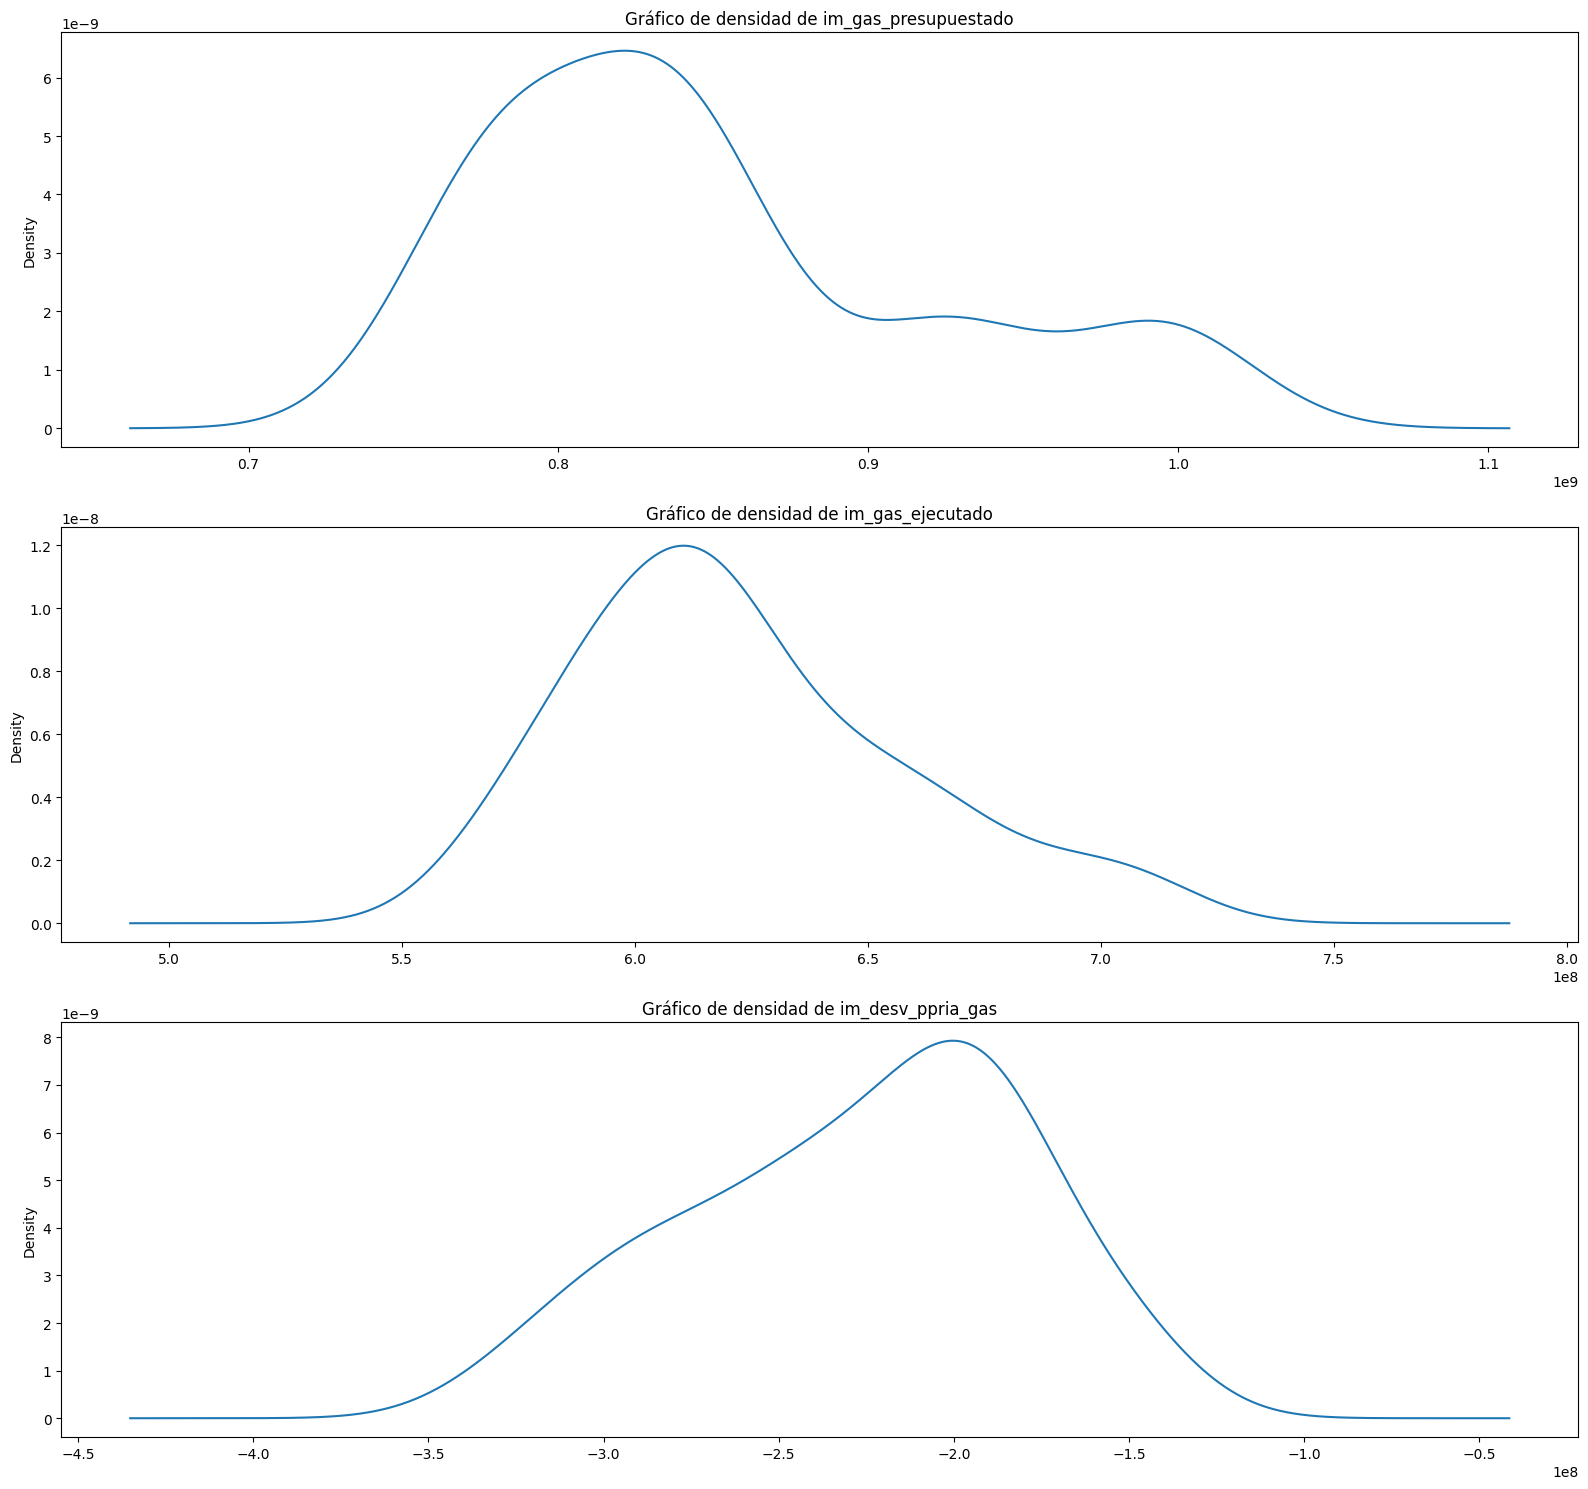

In [128]:
try:
    fig, axes = plt.subplots (nrows = 3, 
                              ncols = 1, 
                              figsize = (16,
                                         15))
    
    for i, ax in zip (obj_gas, axes):
        df_gas[i].plot (kind = 'kde', 
                        ax = ax)
        ax.set_title(f'Gráfico de densidad de {i}')
        
    # Ajuste del espacio entre las subtramas
    plt.tight_layout()  
    plt.show()
except Exception as e:
    print ("Error cod 220. Error en el gráfico de densidad para gastos: ",           
           str(e))         

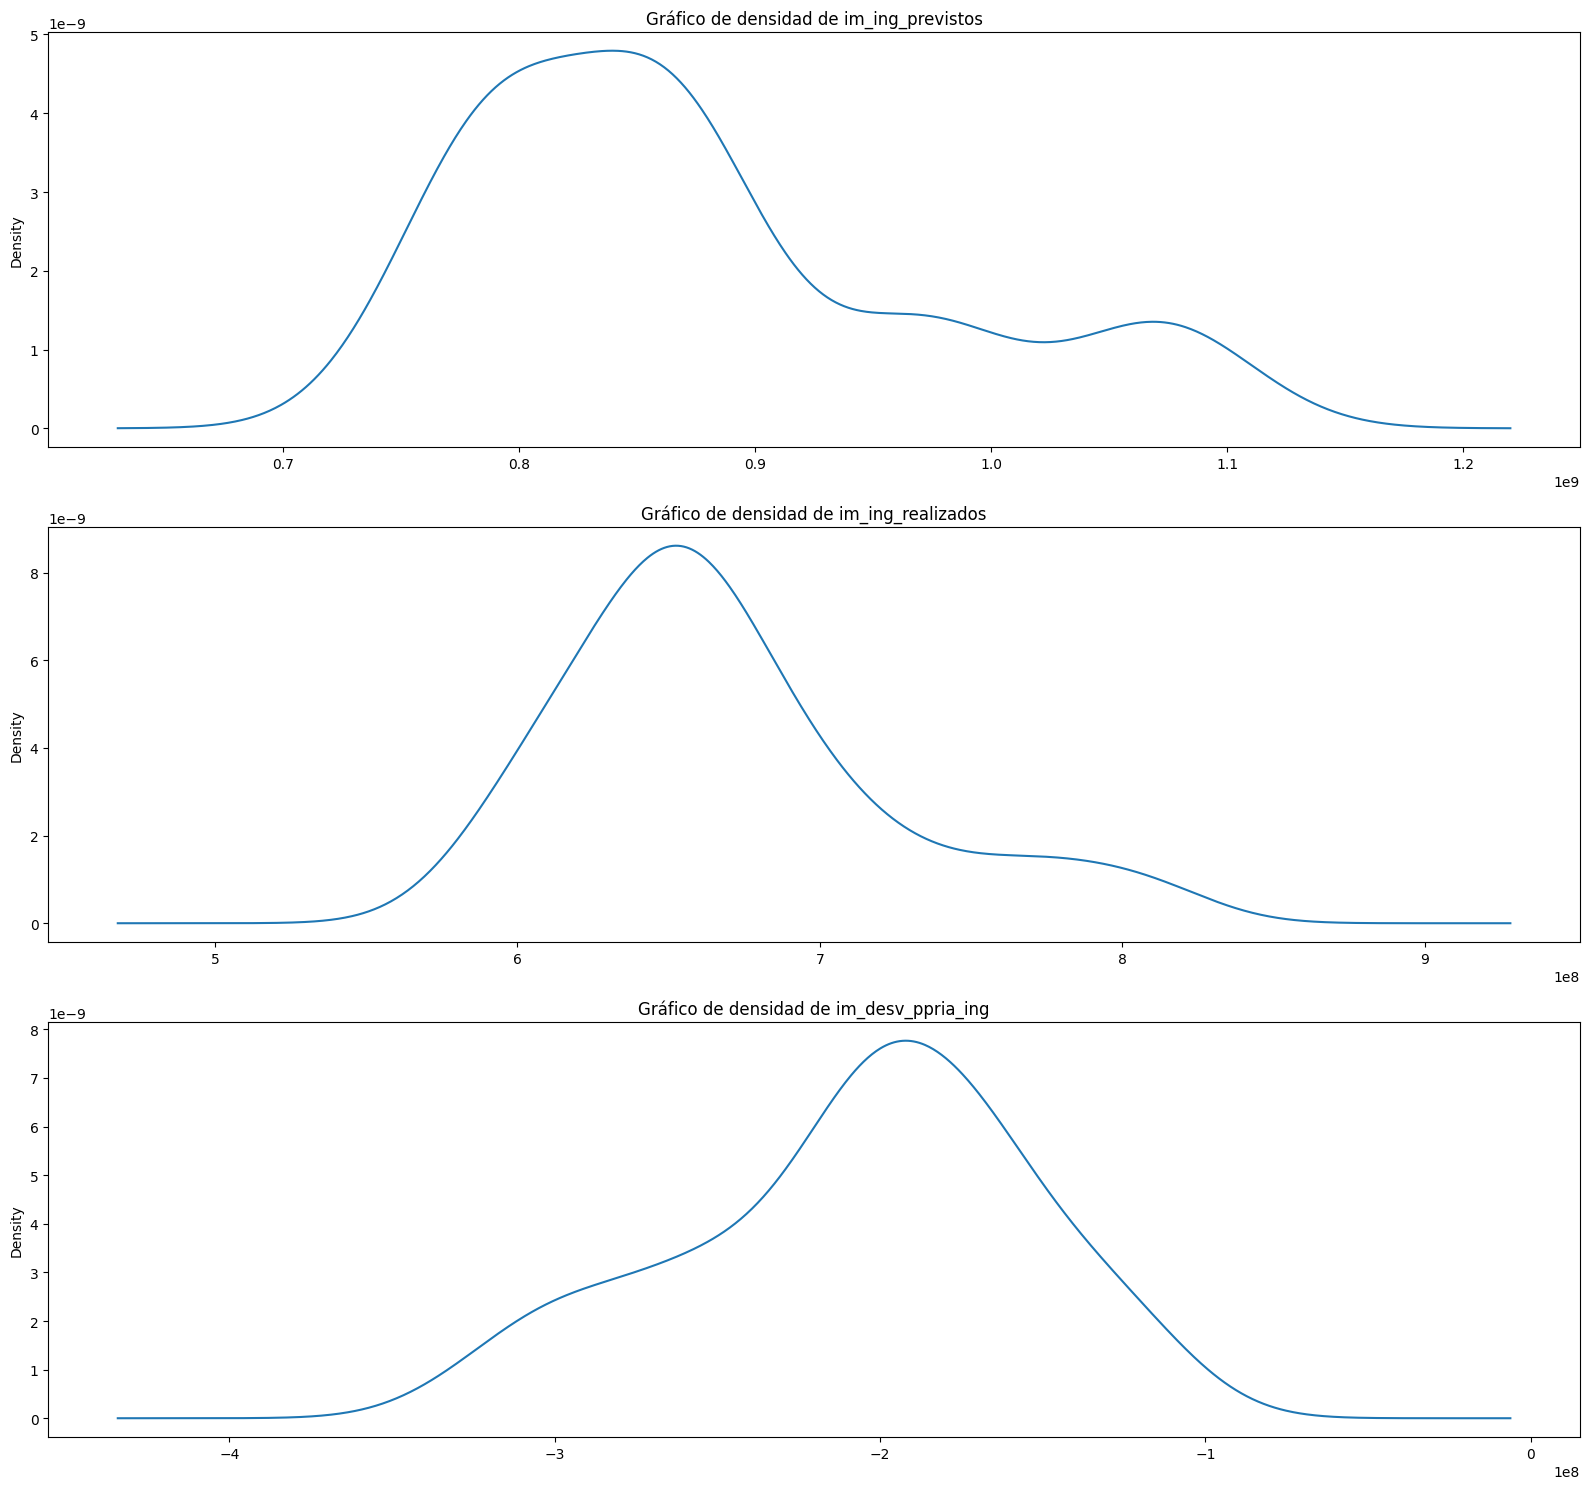

In [129]:
try:
    fig, axes = plt.subplots (nrows = 3, 
                              ncols = 1, 
                              figsize = (16, 
                                         15))
    
    for i, ax in zip (obj_ing, axes):
        df_ing[i].plot (kind = 'kde', 
                        ax = ax)
        ax.set_title(f'Gráfico de densidad de {i}')
        
    # Ajuste del espacio entre las subtramas
    plt.tight_layout()  
    plt.show()
except Exception as e:
    print ("Error cod 223. Error en el gráfico de densidad para ingresos: ",           
           str(e))         

Vistas las gráficas de densidad, se puede decir que los datos no siguen una distribución normal. Se realiza el test de Shapiro para confirmar matemáticamente lo que se ha visto en las gráficas.

In [130]:
try:
    print ('Normalidad en Gastos')
    for i in obj_gas:
        stat, p = shapiro(df_gas[i])
        print (f'   Atributo {i}: start = %.3f, p = %3f' % (stat, p))
        alpha = 0.05
        if p > alpha: 
            print ('   ------> los datos parecen normalizados, no se puede rechazar H0')
            print ()
        else:
            print ('   ------> los datos parecen no normalizados, se rechaza H0')
            print ()
except Exception as e:
    print ("Error cod 225. Error en test shapiro para gastos: ",           
           str(e))                  

Normalidad en Gastos
   Atributo im_gas_presupuestado: start = 0.842, p = 0.000000
   ------> los datos parecen no normalizados, se rechaza H0

   Atributo im_gas_ejecutado: start = 0.952, p = 0.001418
   ------> los datos parecen no normalizados, se rechaza H0

   Atributo im_desv_ppria_gas: start = 0.970, p = 0.024960
   ------> los datos parecen no normalizados, se rechaza H0



In [131]:
try:
    print ('Normalidad en Ingresos')
    for i in obj_ing:
        stat, p = shapiro (df_ing[i])
        print (f'   Atributo {i}: start = %.3f, p = %3f' % (stat, p))
        alpha = 0.05
        if p > alpha: 
            print ('   ------> los datos parecen normalizados, no se puede rechazar H0')
            print ()
        else:
            print ('   ------> los datos parecen no normalizados, se rechaza H0')
            print ()
except Exception as e:
    print ("Error cod 230. Error en test shapiro para ingresos: ",           
           str(e))                  

Normalidad en Ingresos
   Atributo im_ing_previstos: start = 0.830, p = 0.000000
   ------> los datos parecen no normalizados, se rechaza H0

   Atributo im_ing_realizados: start = 0.923, p = 0.000031
   ------> los datos parecen no normalizados, se rechaza H0

   Atributo im_desv_ppria_ing: start = 0.967, p = 0.016967
   ------> los datos parecen no normalizados, se rechaza H0



**Estacionalidad y residuos. Variaciones aleatorias o irregulares**

*Gastos*

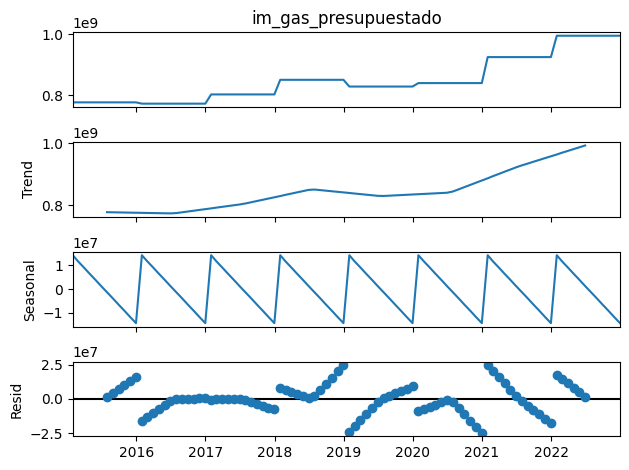

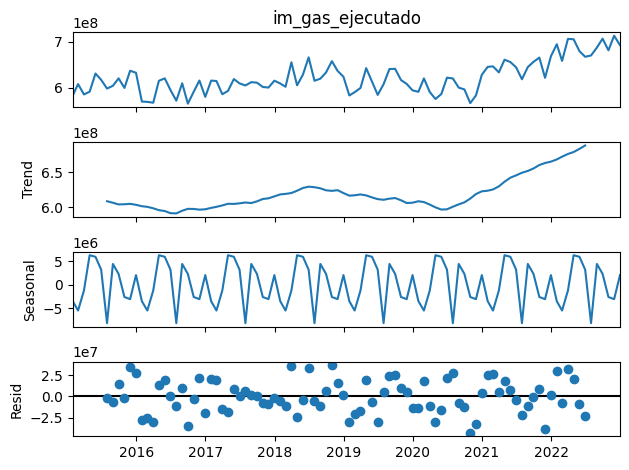

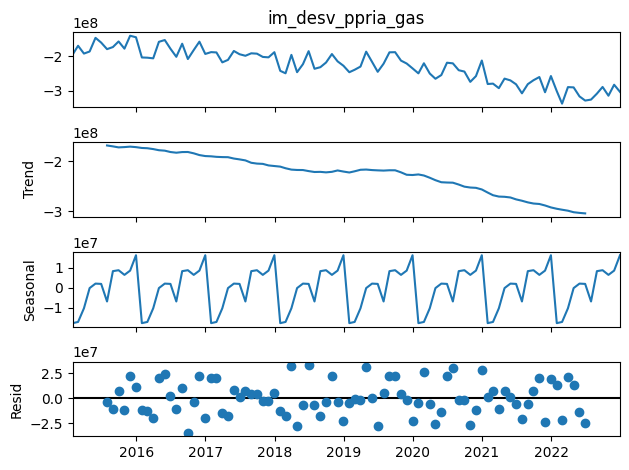

In [132]:
try:
    # Descomposición estacional y residuos por atributo
    for atributo in obj_gas:
        descomposicion = seasonal_decompose (df_gas[atributo], 
                                             model = 'additive')
        descomposicion.plot()

except Exception as e:
    print ("Error cod 240. Error al calcular la descomposición estacional en gastos: ", 
           str(e))


Análisis de autocorrelación y autocorrelación parcial, para determinar con más certeza el comportamiento de las variables.

<Figure size 1200x800 with 0 Axes>

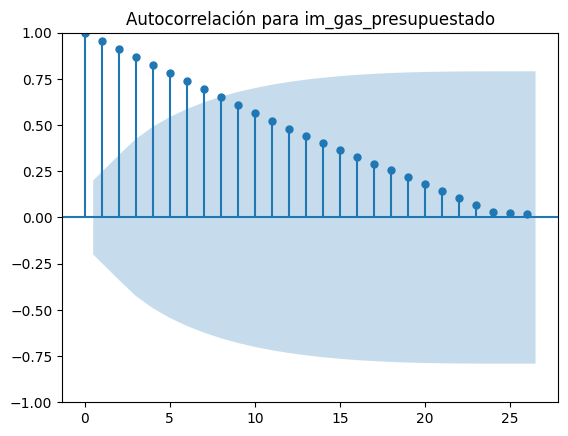

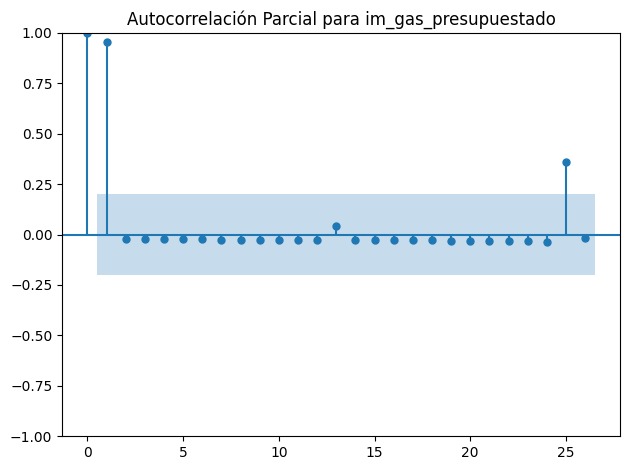

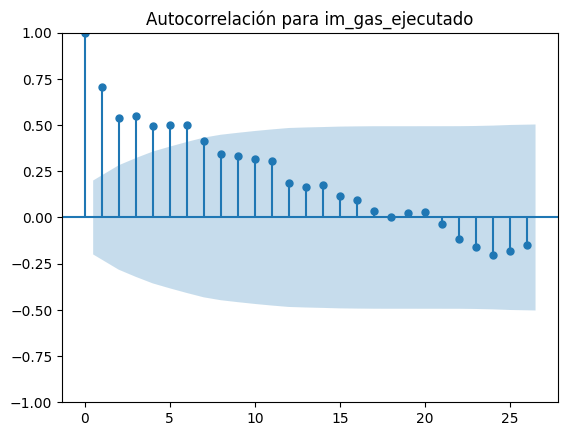

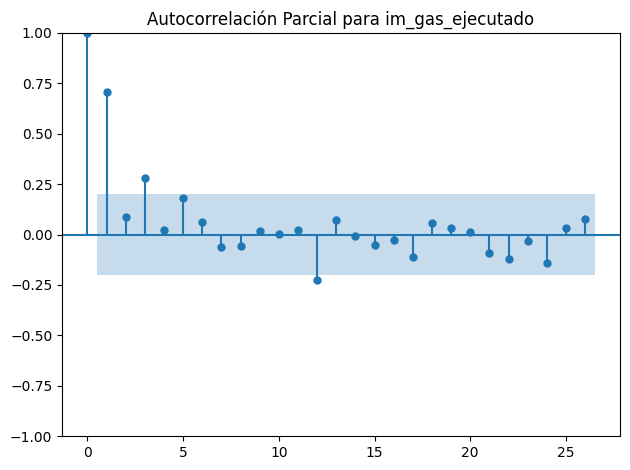

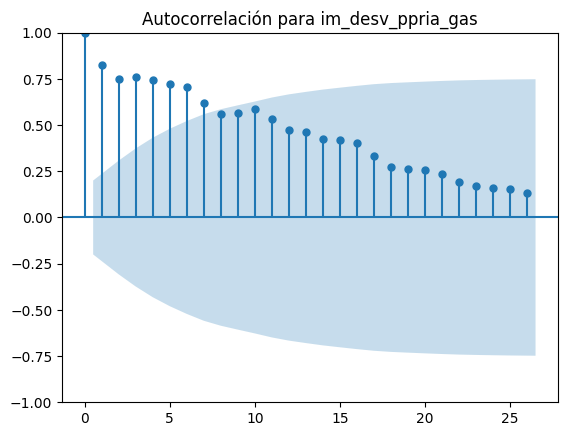

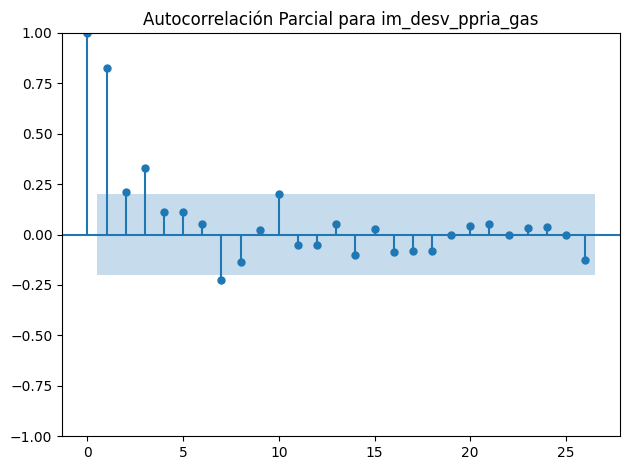

In [133]:
# Configuración del tamaño de la figura
plt.figure (figsize = (12, 
                       8))

# Realizar el análisis de autocorrelación y autocorrelación parcial para cada variable
for atributo in obj_gas:
    plot_acf (df_gas[atributo], 
              lags = 26, #más de 2 años
              title = f'Autocorrelación para {atributo}')
    
    plot_pacf (df_gas[atributo], 
               lags = 26, #más de 2 años
               title = f'Autocorrelación Parcial para {atributo}')
    
    plt.tight_layout()
    plt.show()

*Ingresos*

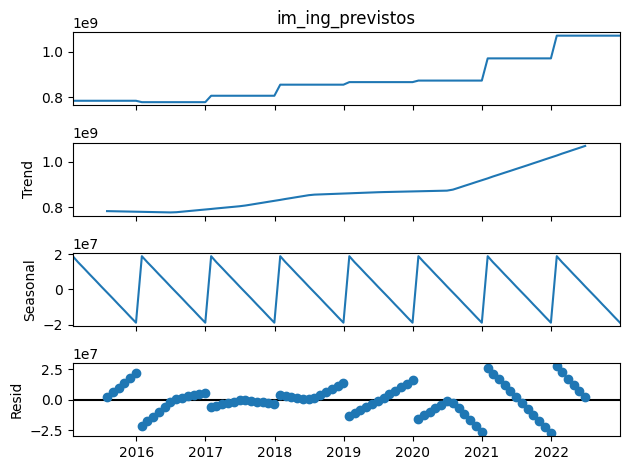

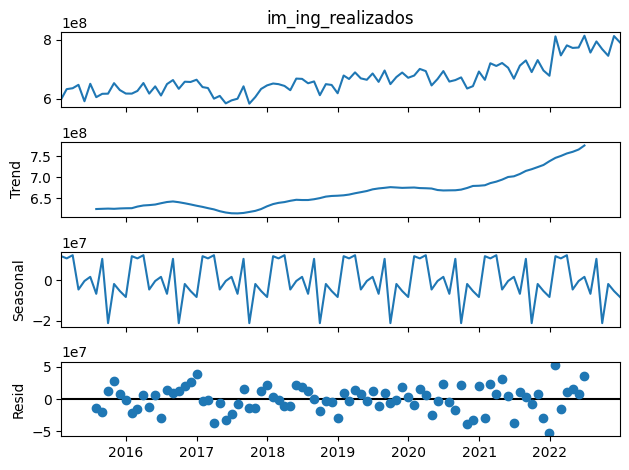

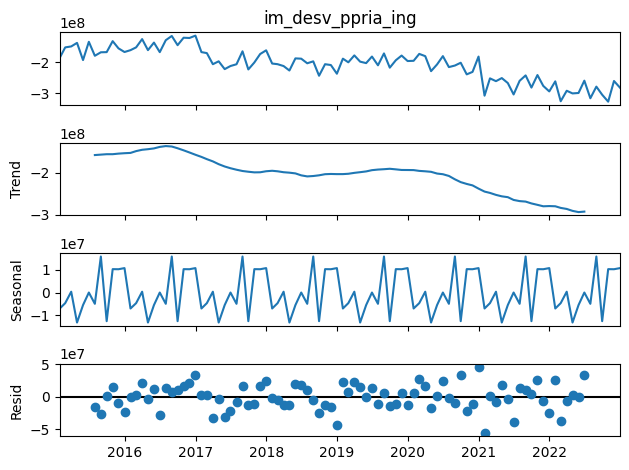

In [134]:
try: 
    # Descomposición estacional por atributo
    for atributo in obj_ing:
        descomposicion = seasonal_decompose (df_ing[atributo], 
                                             model = 'additive')
        descomposicion.plot()

except Exception as e:
    print ("Error cod 250. Error al calcular la descomposición estacional en ingresos: ", 
           str(e))


Análisis de autocorrelación y autocorrelación parcial, para determinar con más certeza el comportamiento de las variables.

<Figure size 1200x800 with 0 Axes>

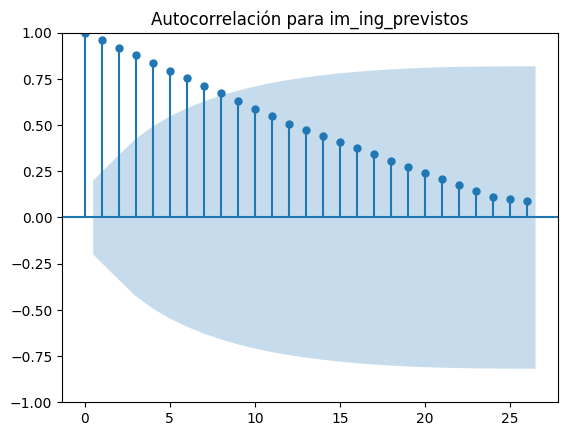

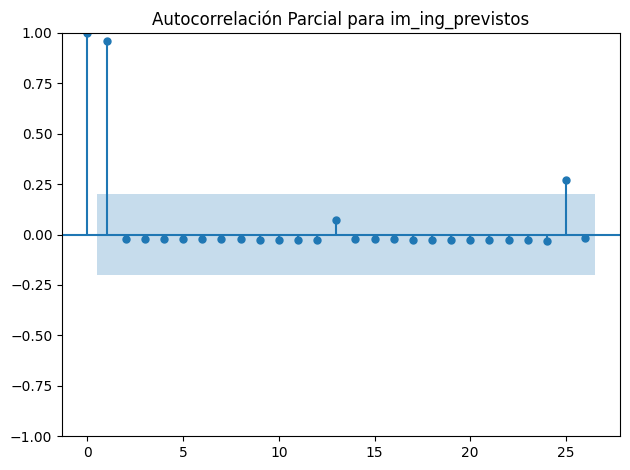

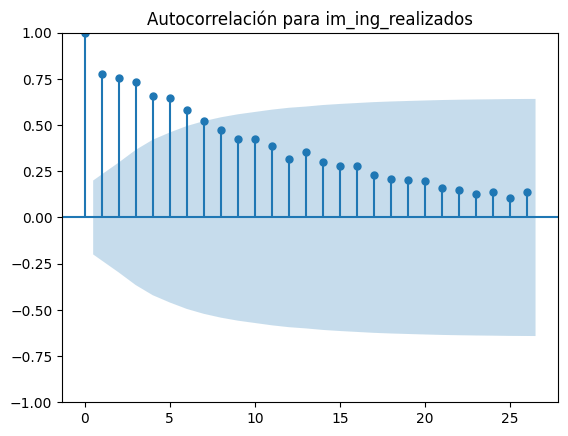

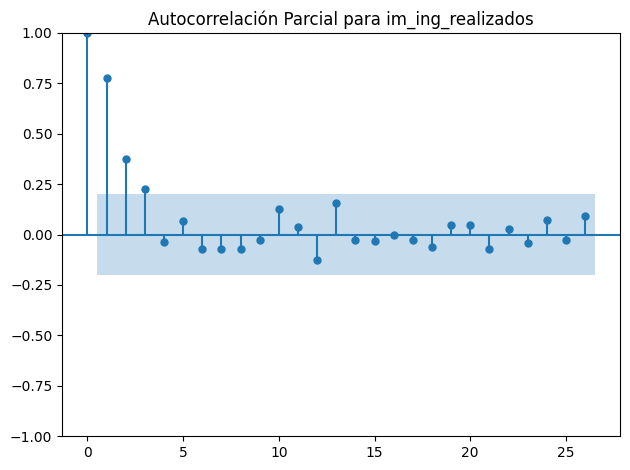

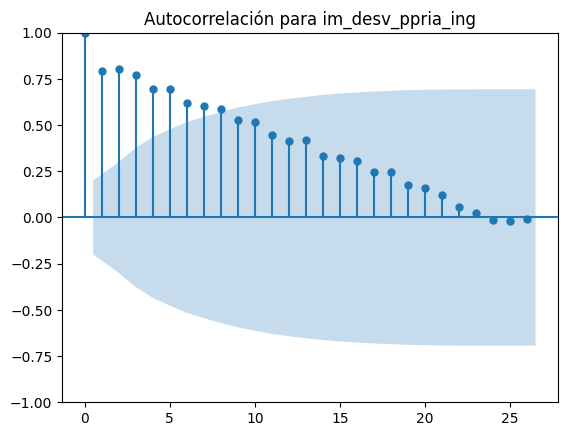

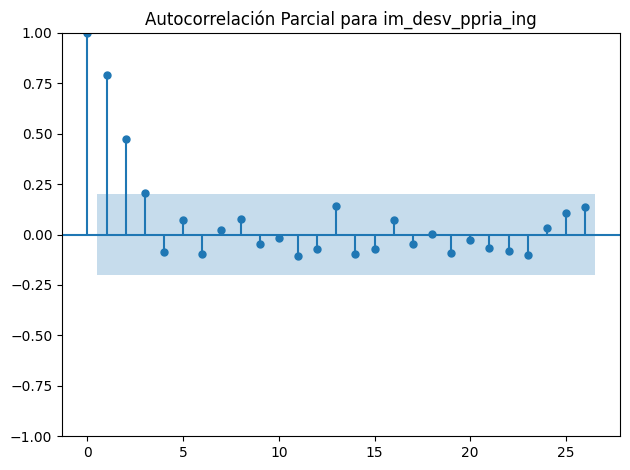

In [135]:
# Configuración del tamaño de la figura
plt.figure (figsize = (12, 
                       8))

# Realizar el análisis de autocorrelación y autocorrelación parcial para cada variable
for atributo in obj_ing:
    plot_acf (df_ing[atributo],
              lags = 26, #más de 2 años
              title = f'Autocorrelación para {atributo}')
    
    plot_pacf (df_ing[atributo],
               lags = 26, #más de 2 años
               title = f'Autocorrelación Parcial para {atributo}')
    
    plt.tight_layout ()
    plt.show ()

Los residuos representan las variaciones aleatorias. Por tanto, en este conjunto de datos se cuenta con ellas.

**Estacionariedad**

*Test de Dickey-Fuller Aumentado*

In [136]:
"""
    Nombre: adf_test
    Función: calcula para argu_atributo el test de Dickey-Fuller Aumentado
    Args:
        argu_atributo (carácter): atributo sobre el que realizar el test
"""

def adf_test (argu_atributo):
    try:
        adf_result = adfuller (argu_atributo)
        p_value = adf_result[1]
        print(f"Atributo: {argu_atributo.name}")
        print("    ADF Statistic:", adf_result[0])
        print("    p-value:", p_value)
        print("    Critical Values:")
        for key, value in adf_result[4].items():
            print(f"\t\t{key}: {float(value)}")
        if p_value <= 0.05:
            print('Se puede rechazar la hipótesis nula.')
            print(f'Los datos son estacionarios, p_value <= 0.05 ({p_value}).')
        else:
            print('No se puede rechazar la hipótesis nula.')
            print(f'Los datos no son estacionarios, p_value > 0.05 ({p_value}).')
        print()
        return p_value  # Devolver el valor de p-value
    
    except Exception as e:
        print("Error cod 260. Error en método adf_test: ", str(e))

In [137]:
try:
    for var_obj_gas in obj_gas:
        adf_test(df_gas[var_obj_gas])
except Exception as e:
        print ("Error cod 270. Error en método adf_test para gastos: ",
               str(e))

Atributo: im_gas_presupuestado
    ADF Statistic: 0.17293520511658275
    p-value: 0.9707020985948117
    Critical Values:
		1%: -3.5117123057187376
		5%: -2.8970475206326833
		10%: -2.5857126912469153
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.9707020985948117).

Atributo: im_gas_ejecutado
    ADF Statistic: -0.3648191798219952
    p-value: 0.9158090829435948
    Critical Values:
		1%: -3.50434289821397
		5%: -2.8938659630479413
		10%: -2.5840147047458037
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.9158090829435948).

Atributo: im_desv_ppria_gas
    ADF Statistic: 0.3938871342191397
    p-value: 0.9812648979018294
    Critical Values:
		1%: -3.5097356063504983
		5%: -2.8961947486260944
		10%: -2.5852576124567475
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.9812648979018294).



In [138]:
try:
    for var_obj_ing in obj_ing:
        adf_test(df_ing[var_obj_ing])
except Exception as e:
        print ("Error cod 280. Error en método adf_test para ingresos: ",
               str(e))        

Atributo: im_ing_previstos
    ADF Statistic: 0.8328092129261906
    p-value: 0.9921477291561024
    Critical Values:
		1%: -3.5117123057187376
		5%: -2.8970475206326833
		10%: -2.5857126912469153
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.9921477291561024).

Atributo: im_ing_realizados
    ADF Statistic: 0.15821388318368065
    p-value: 0.9698181142383735
    Critical Values:
		1%: -3.50434289821397
		5%: -2.8938659630479413
		10%: -2.5840147047458037
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.9698181142383735).

Atributo: im_desv_ppria_ing
    ADF Statistic: -0.9270264974194522
    p-value: 0.7789419777965081
    Critical Values:
		1%: -3.502704609582561
		5%: -2.8931578098779522
		10%: -2.583636712914788
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.7789419777965081).



## 3.4.	Análisis predictivo

**Métodos a usar**

Se opta por crear un método para normalizar variables que pueda trabajar con valor negativo de las mismas, como sería el caso de la desviación presupuestaria. El test de Box-cox no funciona correctamente con valores negativos. Se opta por MinMaxScaler.

In [139]:
"""
    Nombre: normaliza_minmaxscaler
    Función: normaliza los atributos argu_obj del argu_df (dataframe) con nombre argu_df_nom. 
             argu_index es el índice establecido
    Args:
        argu_df (dataframe): dataframe a normalizar
        argu_df_nom (carácter): nombre del dataframe a normalizar
        argu_index (carácter): nombre del atributo índice del dataframe
        argu_obj (lista): lista de atributos objeto a normalizar
"""
def normaliza_minmaxscaler (argu_df, argu_df_nom, argu_index, argu_obj):
    try:
        df_aux_nor = argu_df.copy()
            
        # Se resetea el índice para evitar problemas en el tratamiento del dataframe
        df_aux_nor = df_aux_nor.reset_index (argu_index)  
    
        # Simplificamos para la normalización MinMaxScaler
        # por la naturaleza de los datos no se ha podido usar log ni Box-Cox
        df_numerical = df_aux_nor[argu_obj]
    
        # Crea una instancia del MinMaxScaler
        scaler = MinMaxScaler (feature_range = (0,1))

        # Normaliza los datos numéricos
        argu_df_nor = scaler.fit_transform (df_numerical)
    
        # Convierte el resultado en un DataFrame con los mismos nombres de columnas
        argu_df_nor = pd.DataFrame (argu_df_nor, 
                                    columns = argu_obj)

        # Combina los datos normalizados con las columnas no numéricas
        argu_df_nor = pd.concat([df_aux_nor.drop(columns = argu_obj), argu_df_nor], 
                                axis = 1)

        argu_df_nor = argu_df_nor.set_index (argu_index) 
        
        return argu_df_nor
    
    except Exception as e:
        print (f"Error cod 290. Error en normalización de {argu_df_nom}: ",    
               str(e))   

In [140]:
"""
    Nombre: diferenciacion
    Función: Crea un nuevo atributo con la diferenciación de argu_atributo en el dataframe argu_df 
             para tratar tendencia y estacionalidad.
    Args:
        argu_df (dataframe): dataframe con argu_atributo
        argu_df_nom (carácter): nombre del dataframe sobre el que se haya diff().
        argu_index (carácter): nombre del atributo sobre el que se va a operar
    Devuelve:
        df_aux_diff (dataframe): dataframe iniciala con un nuevo atributo con valores diferenciados
"""    

def diferenciacion (argu_df, argu_nom_df, argu_atributo):
    try:
        # Creamos copia
        df_aux_diff = argu_df.copy()
        
        # Creamos el nuevo atributo
        v_nuevo_atributo = f"{argu_atributo}_diff"
        
         # Cálculo de la diferenciación para tratar estacionalidad y tendencia
        diff_series = argu_df[argu_atributo].diff
    
        # Añadimos el atributo al dataframe
        df_aux_diff[v_nuevo_atributo] = df_aux_diff[argu_atributo].diff()
    
        # Eliminamos posibles NaN generados
        df_aux_diff = df_aux_diff.dropna()
    
        return df_aux_diff

    except Exception as e:   
        print (f"Error cod 300. Error en diferenciación de {argu_nom_df}, atributo {argu_atributo}: ", 
               str (e))  
    

In [141]:
"""
    Nombre: metricas
    Función: obtiene los valores de las métricas más comunes en un modelo predictivo
    Args:
        argu_true: conjunto de datos reales
        argu_pred: conjunto de datos predichos
        argu_modelo: nombre del modelo predictivo que se evalúa
"""
# Métricas
def metricas (argu_true, argu_pred, argu_modelo):
    def mean_absolute_percentage_error (argu_true, argu_pred):
        y_true, y_pred = np.array(argu_true), np.array(argu_pred)
        return np.mean(np.abs((argu_true - argu_pred) / argu_true)) * 100
    
    print (f'Evaluación del modelo {argu_modelo}: ')
    print (f'\tMSE es: {metrics.mean_squared_error (argu_true, argu_pred)}')
    print (f'\tMAE es: {metrics.mean_absolute_error (argu_true, argu_pred)}')
    print (f'\tRMSE es: {np.sqrt(metrics.mean_squared_error (argu_true, argu_pred))}')
    print (f'\tMAPE es: {mean_absolute_percentage_error (argu_true, argu_pred)}')
    print (f'\tR2 es: {metrics.r2_score (argu_true, argu_pred)}', end='\n\n')

### 3.4.1.	Selección de algoritmos para el análisis predictivo (Memoria)

### 3.4.2 Modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average)

Se trata de una técnica clásica de pronóstico de series temporales. Se basa en la descomposición de una serie temporal en componentes de autocorrelación, tendencia y estacionalidad, lo que lo hace efectivo para predecir valores futuros en datos secuenciales.

In [142]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-01-31 to 2022-12-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   im_gas_presupuestado  96 non-null     float64
 1   im_gas_ejecutado      96 non-null     float64
 2   im_desv_ppria_gas     96 non-null     float64
 3   Anno                  96 non-null     int64  
 4   Mes                   96 non-null     int64  
dtypes: float64(3), int64(2)
memory usage: 4.5 KB


In [143]:
df_gas.head (n = 3), df_gas.tail (n = 3)

(            im_gas_presupuestado  im_gas_ejecutado  im_desv_ppria_gas  Anno  Mes
 fecha                                                                           
 2015-01-31          7.772933e+08      5.835217e+08      -1.937716e+08  2015    1
 2015-02-28          7.772933e+08      6.083011e+08      -1.689922e+08  2015    2
 2015-03-31          7.772933e+08      5.856972e+08      -1.915961e+08  2015    3,
             im_gas_presupuestado  im_gas_ejecutado  im_desv_ppria_gas  Anno  Mes
 fecha                                                                           
 2022-10-31          9.955250e+08      6.818663e+08      -3.136587e+08  2022   10
 2022-11-30          9.955250e+08      7.136415e+08      -2.818836e+08  2022   11
 2022-12-31          9.955250e+08      6.929568e+08      -3.025682e+08  2022   12)

*Preparación de datos*

Arima necesita trabajar con datos estacionarios. Se va a realizar la predicción sobre el gasto ejecutado. Se realiza el test de Dickey-Fuller aumentado para comprobar la situación de la variable.

In [144]:
p_value = adf_test(df_gas['im_gas_ejecutado'])

Atributo: im_gas_ejecutado
    ADF Statistic: -0.3648191798219952
    p-value: 0.9158090829435948
    Critical Values:
		1%: -3.50434289821397
		5%: -2.8938659630479413
		10%: -2.5840147047458037
No se puede rechazar la hipótesis nula.
Los datos no son estacionarios, p_value > 0.05 (0.9158090829435948).



Se corrige la variable para hacerla estacionaria mediante diferenciación.

In [145]:
# Aplicamos diferenciación
df_gas_sarima = diferenciacion (df_gas, 
                                'df_gas', 
                                'im_gas_ejecutado')

In [146]:
# Nos quedamos solo con la variable objetivo
df_gas_sarima = df_gas_sarima.filter(['im_gas_ejecutado_diff'])

In [147]:
df_gas_sarima.head (n = 3), df_gas_sarima.tail (n = 3)

(            im_gas_ejecutado_diff
 fecha                            
 2015-02-28           2.477937e+07
 2015-03-31          -2.260388e+07
 2015-04-30           5.983520e+06,
             im_gas_ejecutado_diff
 fecha                            
 2022-10-31          -2.541082e+07
 2022-11-30           3.177515e+07
 2022-12-31          -2.068463e+07)

In [148]:
p_value = adf_test (df_gas_sarima['im_gas_ejecutado_diff'])

Atributo: im_gas_ejecutado_diff
    ADF Statistic: -8.195109979227356
    p-value: 7.485756033336464e-13
    Critical Values:
		1%: -3.50434289821397
		5%: -2.8938659630479413
		10%: -2.5840147047458037
Se puede rechazar la hipótesis nula.
Los datos son estacionarios, p_value <= 0.05 (7.485756033336464e-13).



Se llama al método auto_arima para obtener los mejores valores p, d, q, P, D, Q (estos 3 últimos para el modelo Seasonal Arima)

In [149]:
try:
    # Aplicación de auto_arima
    model = auto_arima (df_gas_sarima['im_gas_ejecutado_diff'], 
                        seasonal = True, 
                        m = 12)  # m es el número de pasos en una temporada

    # Resumen del modelo ajustado
    print (model.summary())
    print ("Order (p, d, q): ", 
           model.order)
    print ("Seasonal Order (P, D, Q, s):", 
           model.seasonal_order)
except Exception as e:   
        print (f"Error cod 310. Error en aplicación de auto_arima: ", 
               str (e))      

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   95
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1738.125
Date:                             Tue, 15 Aug 2023   AIC                           3490.250
Time:                                     16:45:39   BIC                           3508.127
Sample:                                 02-28-2015   HQIC                          3497.474
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.232e+06   1.19e+06      1.883      0.060   -9.08e+04    4.56e+06
ar.L1          0.1075      

En base a los parámetros obtenidos, volvemos a llamar a auto_arima

In [150]:
try: 
    v_start_p, v_d, v_start_q = 2,0,1
    v_max_p, v_max_d, v_max_q = v_start_p+3, v_d+1, v_start_q+3
    v_start_P, v_D, v_start_Q = 2,0,0
    v_max_P, v_max_D, v_max_Q = v_start_P+3, v_D+1, v_start_Q+3
    v_m = 12

    auto_arima (df_gas_sarima['im_gas_ejecutado_diff'], 
                start_p = v_start_p, 
                d = v_d,
                start_q = v_start_q,
                max_p = v_max_p,
                max_d = v_max_d, 
                max_q = v_max_q,
                start_P = v_start_P,
                D = v_D, 
                start_Q = v_start_Q,
                max_P = v_max_P,
                max_D = v_max_D,
                max_Q = v_max_Q,
                m = v_m, 
                seasonal = True,
                error_action = 'warn',
                trace = True,
                supress_warnings = True,
                stepwise = True,
                random_state = 20,
                n_fits = 50)
except Exception as e:   
        print (f"Error cod 320. Error en aplicación de auto_arima con parámetros: ", 
               str (e))                
            

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=3490.250, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3516.207, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3510.732, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3497.917, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3514.396, Time=0.00 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=3493.961, Time=0.14 sec
 ARIMA(2,0,1)(3,0,0)[12] intercept   : AIC=3492.239, Time=0.63 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=3491.933, Time=0.38 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=3495.856, Time=0.18 sec
 ARIMA(2,0,1)(3,0,1)[12] intercept   : AIC=3493.653, Time=1.05 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=3496.199, Time=0.19 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=3495.468, Time=0.21 sec
 ARIMA(3,0,1)(2,0,0)[12] intercept   : AIC=3492.250, Time=0.33 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=3491.426, Time=0.36 sec
 ARIMA(1,0,0)(2,0,0

El parámetro AIC nos da el menor error posible. El mejor modelo a procesar. El mejor modelo es el ARIMA (2,0,1)(2,0,0)[12]. Se ha establecido un criterio para los parámetros en función de lo visto. 

Mejor resultado ARIMA(2,0,1)(2,0,0)[12]:    
    
Arima
* ar = 2 términos
* i = 0 término
* ma = 1 término


Arima estacional
* AR = 2 términos AR estacional
* I = 0 términos I estacional 
* MA = 0 términos MA estacional

12 meses     
     
2 de modelos autoregresivos
0 de modelos diferenciados
1 término de promedio móvil

2 de modelos autoregresivos estacionales
0 de modelos diferenciados estacionales
0 término de promedio móvil estacionales


*Conjunto de datos de entrenamiento y prueba*

In [151]:
try: 
    train_data = df_gas_sarima[:len(df_gas_sarima)-12]
    test_data = df_gas_sarima[len(df_gas_sarima)-12:]
    test = test_data.copy()
except Exception as e:   
        print (f"Error cod 330. SARIMA. Error en la creación de datos de entrenamiento y prueba: ", 
               str (e))           

In [152]:
len (train_data), len(test_data)

(83, 12)

In [153]:
train_data.sample (n = 5)

im_gas_ejecutado_diff
fecha                            
2018-11-30          -2.115127e+07
2015-05-31           3.961762e+07
2015-03-31          -2.260388e+07
2015-10-31          -2.084681e+07
2019-04-30           4.319663e+07

*Creación del modelo*

In [154]:
try: 
    # SARIMA(2,0,1)(2,0,0)[12]   
    sarima_model = SARIMAX (train_data['im_gas_ejecutado_diff'],
                            order = (2,0,1),
                            seasonal_order = (2,0,0,12))
    sarima_result = sarima_model.fit()
except Exception as e:   
        print (f"Error cod 340. SARIMA. Error en la creación del modelo: ", 
               str (e))               

In [155]:
sarima_result.summary ()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               im_gas_ejecutado_diff   No. Observations:                   83
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood               -1519.150
Date:                             Tue, 15 Aug 2023   AIC                           3050.299
Time:                                     16:45:45   BIC                           3064.812
Sample:                                 02-28-2015   HQIC                          3056.130
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1831      0.181      1.010      0.313      -0.172       0.539
ar.L2         -0.2493      0.153     -1.629      0.103      -0.549       0.051
ma.L1         -0.7222      0.162     -4.453      0.000      -1.040      -0.404
ar.S.L12      -0.1988      0.155     -1.283      0.200      -0.503       0.105
ar.S.L24      -0.2366      0.140     -1.689      0.091      -0.511       0.038
sigma2      5.152e+14        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.87   Prob(JB):                         0.44
Heteroskedasticity (H):               0.89   Skew:                            -0.16
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

P>|z|, si son menores del 5% son significativos. Son los que suelen aparecer de todos los posibles.

*Predicciones*

In [156]:
try: 
    sarima_pred = sarima_result.predict (start = len (train_data),
                                         end = len (df_gas_sarima) -1, 
                                         typ = "levels").rename("SARIMA Predictions")
    print(sarima_pred)
except Exception as e:   
        print (f"Error cod 350. SARIMA. Error en la realización de predicciones: ", 
               str (e))                   

2022-01-31   -1.001035e+07
2022-02-28   -2.159723e+07
2022-03-31    8.834121e+06
2022-04-30    1.540085e+06
2022-05-31   -6.748936e+05
2022-06-30   -6.909000e+06
2022-07-31    5.271548e+06
2022-08-31   -4.427217e+05
2022-09-30   -1.244996e+06
2022-10-31    5.226477e+06
2022-11-30    4.770872e+06
2022-12-31   -2.000951e+07
Freq: M, Name: SARIMA Predictions, dtype: float64


Text(0.5, 1.0, 'Predicción con Modelo Sarima')

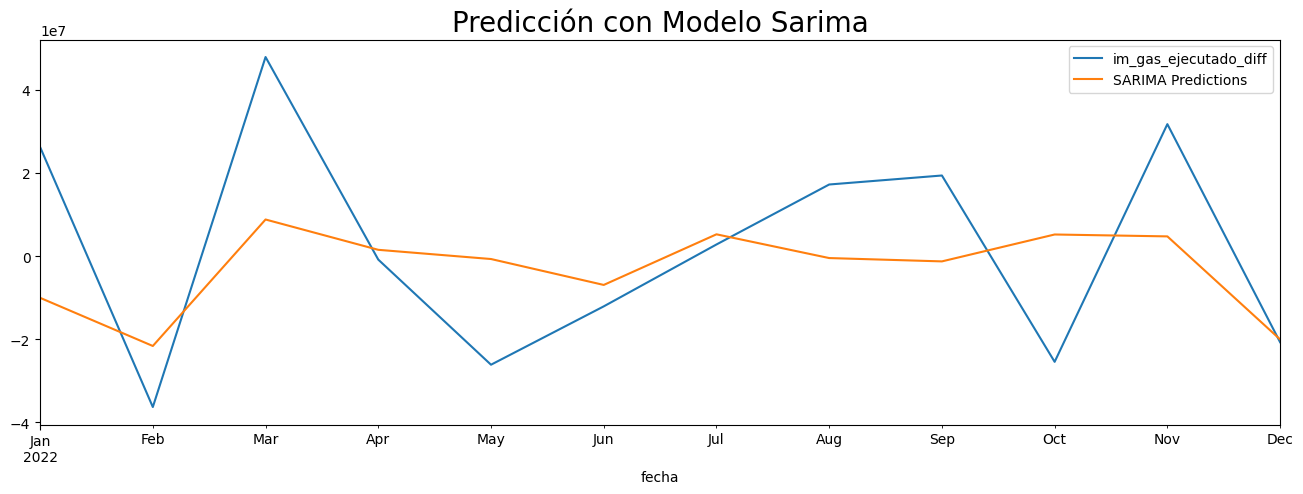

In [157]:
test_data['im_gas_ejecutado_diff'].plot (figsize = (16,
                                                    5), 
                                         legend = True)
sarima_pred.plot (legend = True)
plt.title ("Predicción con Modelo Sarima", 
           fontsize = 20)

*Evaluación del modelo. Métricas*

In [158]:
metricas (test_data, 
          sarima_pred, 
          'SARIMA')

Evaluación del modelo SARIMA: 
	MSE es: 512773961722970.7
	MAE es: 18510137.310906045
	RMSE es: 22644512.839161955
	MAPE es: nan
	R2 es: 0.21600407263243548



In [159]:
test_data ['SARIMA_Predictions'] = sarima_pred

In [160]:
test_data

im_gas_ejecutado_diff  SARIMA_Predictions
fecha                                                
2022-01-31           2.626804e+07       -1.001035e+07
2022-02-28          -3.628219e+07       -2.159723e+07
2022-03-31           4.792532e+07        8.834121e+06
2022-04-30          -8.129230e+05        1.540085e+06
2022-05-31          -2.610489e+07       -6.748936e+05
2022-06-30          -1.206647e+07       -6.909000e+06
2022-07-31           2.824486e+06        5.271548e+06
2022-08-31           1.725519e+07       -4.427217e+05
2022-09-30           1.941996e+07       -1.244996e+06
2022-10-31          -2.541082e+07        5.226477e+06
2022-11-30           3.177515e+07        4.770872e+06
2022-12-31          -2.068463e+07       -2.000951e+07

### 3.4.3 Modelo LSTM (Long Short-Term Memory)

*Preparación de datos*

Modelo que necesita escalar los datos. Los conjuntos de datos de entrenamiento y prueba serán los usados en SARIMA.

In [161]:
try:
    # Creación del scaler
    scaler = MinMaxScaler()
    
    # Escalado de los datos
    scaler.fit (train_data)
    scaled_train_data = scaler.transform (train_data)
    scaled_test_data = scaler.transform (test)
except Exception as e:   
        print (f"Error cod 360. LSTM. Error en el escalado de datos: ", 
               str (e))               

Se crea un objeto Generador de series de tiempo para aplicarlo a la red neuronal. Capa de densidad con salida 1.

In [162]:
try: 
    n_input = 12
    n_features = 1
    
    # Creación del objeto generado de series de tiempo
    generator = TimeseriesGenerator (scaled_train_data, 
                                     scaled_train_data, 
                                     length = n_input, 
                                     batch_size = 1)
except Exception as e:   
        print (f"Error cod 370. LSTM. Error en la creación del generador de series de tiempo: ", 
               str (e))               

*Creación de la red neuronal*

Se crea un modelo bastante sencillo, dada la poca complejidad de los datos. Secuencia con 64 entradas, función de activación relu

In [163]:
try: 
    lstm_model = Sequential ()
    lstm_model.add (LSTM (64, 
                          activation = 'relu', 
                          input_shape = (n_input, 
                                         n_features)))
    
    lstm_model.add (Dense (1))
    lstm_model.compile (optimizer = 'adam',  
                        loss = 'mse')
    
    print(lstm_model.summary())

except Exception as e:   
        print (f"Error cod 380. LSTM. Error en la creación de la red neuronal: ", 
               str (e))              

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [164]:
v_epochs = 20
lstm_model.fit_generator (generator,
                          epochs = v_epochs)

Epoch 1/20
71/71 [==============================] - 2s 5ms/step - loss: 0.0915
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0555
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0544
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0548
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0528
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0512
Epoch 8/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 9/20
71/71 [==============================] - 0s 6ms/step - loss: 0.0543
Epoch 10/20
71/71 [==============================] - 0s 6ms/step - loss: 0.0558
Epoch 11/20
71/71 [==============================] - 0s 6ms/step - loss: 0.0529
Epoch 12/20
71/71 [==============================] - 0s 5ms/step - loss: 0.0567
Epoch 13/20
71/71 [==============================

Gráfica de pérdidas

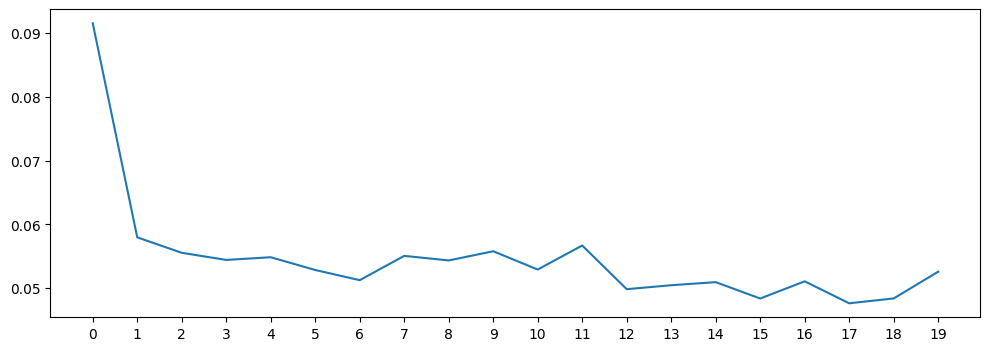

In [165]:
try: 
    losses_lstm = lstm_model.history.history['loss']
    plt.figure (figsize = (12, 
                           4))
    plt.xticks (np.arange (0, 
                           v_epochs + 1 , 
                           1)) #epochs
    plt.plot (range (len (losses_lstm)), 
              losses_lstm)
except Exception as e:   
        print (f"Error cod 390. LSTM. Error en la obtención y visualización de las pérdidas: ", 
               str (e))           


Cantidad de pérdida en función de la métrica. Se estabilizan los valores.

*Predicciones*

In [166]:
try: 
    lstm_predictions_scaled = list ()
    
    batch = scaled_train_data [-n_input:]
    current_batch = batch.reshape ((1, 
                                    n_input, 
                                    n_features))
    for i in range(len (test_data)):
        lstm_pred = lstm_model.predict (current_batch)[0]    
        lstm_predictions_scaled.append (lstm_pred)
        current_batch = np.append (current_batch[:,1:,:],
                                   [[lstm_pred]],
                                   axis = 1)
except Exception as e:   
        print (f"Error cod 400. LSTM. Error en la generación de predicciones: ", 
               str (e))                   

1/1 [==============================] - 0s 26ms/step


 Con datos escalados

In [167]:
lstm_predictions_scaled

[array([0.50905526], dtype=float32),
 array([0.53322077], dtype=float32),
 array([0.54054415], dtype=float32),
 array([0.54459965], dtype=float32),
 array([0.5412554], dtype=float32),
 array([0.54099745], dtype=float32),
 array([0.54026735], dtype=float32),
 array([0.54090315], dtype=float32),
 array([0.53674823], dtype=float32),
 array([0.5369668], dtype=float32),
 array([0.5386679], dtype=float32),
 array([0.5442128], dtype=float32)]

In [168]:
lstm_predictions = scaler.inverse_transform (lstm_predictions_scaled)

In [169]:
lstm_predictions

array([[-3.65360787e+06],
       [-8.48461424e+05],
       [ 1.64124044e+03],
       [ 4.72406019e+05],
       [ 8.42049692e+04],
       [ 5.42597904e+04],
       [-3.04903238e+04],
       [ 4.33140250e+04],
       [-4.38991548e+05],
       [-4.13619790e+05],
       [-2.16153200e+05],
       [ 4.27502089e+05]])

Guardamos las predicciones

In [170]:
test_data ['LSTM_Predictions'] = lstm_predictions

In [171]:
test_data

im_gas_ejecutado_diff  SARIMA_Predictions  LSTM_Predictions
fecha                                                                  
2022-01-31           2.626804e+07       -1.001035e+07     -3.653608e+06
2022-02-28          -3.628219e+07       -2.159723e+07     -8.484614e+05
2022-03-31           4.792532e+07        8.834121e+06      1.641240e+03
2022-04-30          -8.129230e+05        1.540085e+06      4.724060e+05
2022-05-31          -2.610489e+07       -6.748936e+05      8.420497e+04
2022-06-30          -1.206647e+07       -6.909000e+06      5.425979e+04
2022-07-31           2.824486e+06        5.271548e+06     -3.049032e+04
2022-08-31           1.725519e+07       -4.427217e+05      4.331403e+04
2022-09-30           1.941996e+07       -1.244996e+06     -4.389915e+05
2022-10-31          -2.541082e+07        5.226477e+06     -4.136198e+05
2022-11-30           3.177515e+07        4.770872e+06     -2.161532e+05
2022-12-31          -2.068463e+07       -2.000951e+07      4.275021e+05

In [172]:
ai = test_data[['im_gas_ejecutado_diff', 'LSTM_Predictions']]
fig = px.line (ai,
              x = test_data.index,
              y = ai.columns,
              title = 'Predicción con modelo LSTM')
fig.show()

In [173]:
metricas (test_data['im_gas_ejecutado_diff'],
         test_data ['LSTM_Predictions'],
         'LSTM')

Evaluación del modelo LSTM: 
	MSE es: 672897443450341.0
	MAE es: 22575054.66458966
	RMSE es: 25940266.83460178
	MAPE es: 106.22163036598135
	R2 es: -0.02881365783180123



### 3.4.4 Modelo Random Forest Regressor

*Preparación de datos*

Se realiza una copia del dataframe original con la variable a predecir, junto con Anno y Mes para tener en cuenta la estacionalidad y las versiones lags durante la ventana de 12 meses.

In [174]:
df_rf = df_gas.filter(['Anno', 'Mes','im_gas_ejecutado'])

In [175]:
df_rf = df_rf.reset_index() 
df_rf.head()

fecha  Anno  Mes  im_gas_ejecutado
0 2015-01-31  2015    1      5.835217e+08
1 2015-02-28  2015    2      6.083011e+08
2 2015-03-31  2015    3      5.856972e+08
3 2015-04-30  2015    4      5.916807e+08
4 2015-05-31  2015    5      6.312983e+08

In [176]:
df_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             96 non-null     datetime64[ns]
 1   Anno              96 non-null     int64         
 2   Mes               96 non-null     int64         
 3   im_gas_ejecutado  96 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 KB


Uso del método shift para crear variables con lags (retrasos)

In [177]:
# Se añaden 12 meses de lags
df_rf['L1'] = df_rf["im_gas_ejecutado"].shift(1)
df_rf['L2'] = df_rf["im_gas_ejecutado"].shift(2)
df_rf['L3'] = df_rf["im_gas_ejecutado"].shift(3)
df_rf['L4'] = df_rf["im_gas_ejecutado"].shift(4)
df_rf['L5'] = df_rf["im_gas_ejecutado"].shift(5)
df_rf['L6'] = df_rf["im_gas_ejecutado"].shift(6)
df_rf['L7'] = df_rf["im_gas_ejecutado"].shift(7)
df_rf['L8'] = df_rf["im_gas_ejecutado"].shift(8)
df_rf['L9'] = df_rf["im_gas_ejecutado"].shift(9)
df_rf['L10'] = df_rf["im_gas_ejecutado"].shift(10)
df_rf['L11'] = df_rf["im_gas_ejecutado"].shift(11)
df_rf['L12'] = df_rf["im_gas_ejecutado"].shift(12)

In [178]:
df_rf.head(15)

fecha  Anno  Mes  im_gas_ejecutado            L1            L2            L3            L4            L5            L6            L7            L8            L9           L10           L11           L12
0  2015-01-31  2015    1      5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
1  2015-02-28  2015    2      6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
2  2015-03-31  2015    3      5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
3  2015-04-30  2015    4      5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
4  2015-05-31  2015    5      6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
5  2015-06-30  2015    6      6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN           NaN
6  2015-07-31  2015    7      5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN           NaN
7  2015-08-31  2015    8      6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN           NaN
8  2015-09-30  2015    9      6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN           NaN
9  2015-10-31  2015   10      5.999441e+08  6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN           NaN
10 2015-11-30  2015   11      6.374048e+08  5.999441e+08  6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN           NaN
11 2015-12-31  2015   12      6.329379e+08  6.374048e+08  5.999441e+08  6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08           NaN
12 2016-01-31  2016    1      5.701928e+08  6.329379e+08  6.374048e+08  5.999441e+08  6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08  5.835217e+08
13 2016-02-29  2016    2      5.695503e+08  5.701928e+08  6.329379e+08  6.374048e+08  5.999441e+08  6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08  6.083011e+08
14 2016-03-31  2016    3      5.676714e+08  5.695503e+08  5.701928e+08  6.329379e+08  6.374048e+08  5.999441e+08  6.207909e+08  6.045688e+08  5.985416e+08  6.175138e+08  6.312983e+08  5.916807e+08  5.856972e+08

Se eliminan las filas que tienen NaN.

In [179]:
df_rf = df_rf.dropna()

*Conjunto de datos de entrenamiento y prueba*

Variable dependiente y variable independiente. Partición de los datos entrenamiento y prueba (80/20)

In [180]:
try:
    y = df_rf["im_gas_ejecutado"]
    X = df_rf[['Anno', 'Mes', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12']]
    # Partición de los datos
    X_train, X_test, y_train, y_test = train_test_split (X, 
                                                         y, 
                                                         test_size = 0.2, 
                                                         random_state = 12345, 
                                                         shuffle = False)
except Exception as e:   
        print (f"Error cod 410. RF. Error en la generación de conjuntos de datos entrenamiento y prueba: ", 
               str (e))       

*Creación del modelo*

In [181]:
try: 
    # Creación del regresor
    #my_rf = RandomForestRegressor ()
    my_rf = RandomForestRegressor (n_estimators = 50, 
                                   max_depth = 5, 
                                   random_state = 42)
    
    # Con datos escalados
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform (X_train)
    X_test_scaled = scaler.transform (X_test)
    
    # Entrenamiento del modelo
    my_rf.fit (X_train_scaled, 
               y_train)
    
    # Predicción
    fcst = my_rf.predict (X_test_scaled)
    
    # Sin datos escalados
    # Entrenamiento del modelo
    #my_rf.fit (X_train,
    #           y_train)
    
    # Predicción
    #fcst = my_rf.predict (X_test)
    
except Exception as e:   
        print (f"Error cod 420. RF. Error en la creación del modelo: ", 
               str (e))   

In [182]:
b = pd.DataFrame({"im_gas_ejecutado actual":y_test, 
                  "Random Forest":fcst})
b.head (30)

im_gas_ejecutado actual  Random Forest
79             6.453520e+08   6.063898e+08
80             6.567596e+08   6.332279e+08
81             6.659846e+08   6.313116e+08
82             6.219371e+08   6.309530e+08
83             6.688506e+08   6.087209e+08
84             6.951187e+08   6.281747e+08
85             6.588365e+08   6.273774e+08
86             7.067618e+08   6.313690e+08
87             7.059489e+08   6.264696e+08
88             6.798440e+08   6.303206e+08
89             6.677775e+08   6.281493e+08
90             6.706020e+08   6.322661e+08
91             6.878572e+08   6.266433e+08
92             7.072771e+08   6.264701e+08
93             6.818663e+08   6.276161e+08
94             7.136415e+08   6.298506e+08
95             6.929568e+08   6.279374e+08

In [183]:
fig = px.line (b, 
               x = b.index, 
               y = b.columns,
               title = 'Predicción con modelo Random Forest')
fig.show ()

metricas

In [184]:
metricas (y_test, 
          fcst, 
          'Random Forest')

Evaluación del modelo Random Forest: 
	MSE es: 3200242430124458.5
	MAE es: 52479793.622035004
	RMSE es: 56570685.25415313
	MAPE es: 7.643400892079394
	R2 es: -4.561286010218899



### 3.4.4 Modelo GARCH (Generalized AutoRegressive Conditional Heteroskedasticity)

*Preparación de datos*

In [185]:
# Creación del dataframe con la variable a predecir
df_gas_garch = df_gas.filter(['im_gas_ejecutado'])

In [186]:
df_gas_garch.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2015-01-31 to 2022-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   im_gas_ejecutado  96 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


Gráfica de autocorrelación parcial. Al llevar un autoregresivo y un promedio móvil. AR se encuentran los parámetros de nuestro modelo usando la autocorrelación parcial

<function matplotlib.pyplot.show(close=None, block=None)>

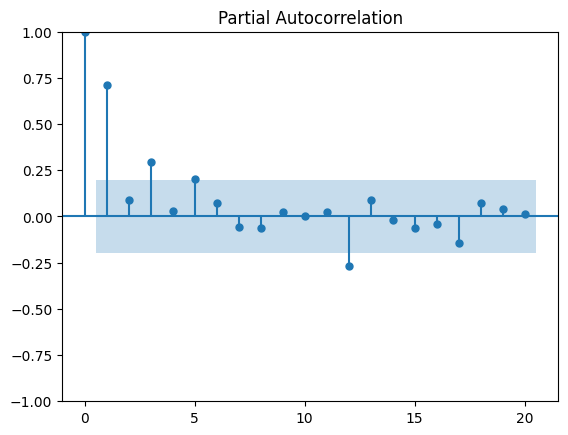

In [187]:
plot_pacf (df_gas_garch['im_gas_ejecutado'], 
           method = 'yw' )
plt.show

Los rezagos más significativos son el 1, 3, 5, y 12.

*Creación del modelo*

Los coeficientes GARCH (p) y ARCH (q) se refieren a los términos autoregresivos y de media móvil en la ecuación de la varianza condicional. Estos términos capturan la relación entre los errores pasados y la varianza actual. Al haberse realizado previamente sobre los mismos datos el método auto_arima, usamos los valores p y q propuestos por el mismo método.

In [188]:
try:
    # Modelo GARCH (2, 1), los recomendados por auto_arima
    # con distribución ged (Generalized Error Distribution)
    model = arch_model (df_gas_garch['im_gas_ejecutado'],
                        dist = "ged", 
                        vol = 'GARCH',
                        p = 2, #términos autorregresivos
                        q = 1 #términos de media móvil
                       )
    
    model_fit = model.fit (disp = 'off')
    print (model_fit.summary())
    
except Exception as e:   
        print (f"Error cod 430. GARCH. Error en la creación del modelo: ", 
               str (e))       

                           Constant Mean - GARCH Model Results                            
Dep. Variable:                   im_gas_ejecutado   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -1790.07
Distribution:      Generalized Error Distribution   AIC:                           3592.14
Method:                        Maximum Likelihood   BIC:                           3607.53
                                                    No. Observations:                   96
Date:                            Tue, Aug 15 2023   Df Residuals:                       95
Time:                                    16:46:01   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------

Creación de un nuevo modelo ajustado a la serie completa de datos sin dividir en entrenamiento y prueba.

In [189]:
try:
    # Se define la serie completa como el modelo previamente definido
    full_serie_garch = arch_model (df_gas_garch['im_gas_ejecutado'],
                                   dist = 'ged', 
                                   vol = 'GARCH', 
                                   p = 2, 
                                   q = 1
                              )
    # Ajuste del modelo para la serie completa
    model_fit_full_serie = full_serie_garch.fit (disp = 'off')
except Exception as e:   
        print (f"Error cod 440. GARCH. Error en la creación del modelo de serie completa: ", 
               str (e))       

El método rolling a la serie temporal crea una ventana móvil de tamaño parametrizable que se desplace a lo largo de la serie para calcular la desviación estándar.

In [190]:
try:
    # Cálculo de la volatilidad rodante para calcular la desviación estándar 
    # durante una ventana de tiempo
    rolling_vol = abs(df_gas_garch['im_gas_ejecutado'].rolling (window = 4, 
                                                                min_periods = 1).std().dropna())
    print(rolling_vol)
except Exception as e:   
        print (f"Error cod 450. GARCH. Error en la creación de la ventana móvil: ", 
               str (e))     

fecha
2015-02-28    1.752166e+07
2015-03-31    1.372155e+07
2015-04-30    1.121121e+07
2015-05-31    2.041419e+07
2015-06-30    2.151449e+07
                  ...     
2022-08-31    9.147577e+06
2022-09-30    1.823763e+07
2022-10-31    1.535260e+07
2022-11-30    1.520342e+07
2022-12-31    1.429394e+07
Name: im_gas_ejecutado, Length: 95, dtype: float64


Se combina la volatilidad condicional estimada por el modelo GARCH y la volatilidad rodante calculada previamente.

In [191]:
garch_and_rolling_std = pd.concat ([pd.DataFrame(model_fit_full_serie.conditional_volatility),
                                   rolling_vol.dropna()],
                                   axis = 1).dropna()
garch_and_rolling_std

cond_vol  im_gas_ejecutado
fecha                                     
2015-02-28  3.237243e+07      1.752166e+07
2015-03-31  2.967463e+07      1.372155e+07
2015-04-30  3.213603e+07      1.121121e+07
2015-05-31  3.229199e+07      2.041419e+07
2015-06-30  2.909788e+07      2.151449e+07
...                  ...               ...
2022-08-31  5.111813e+07      9.147577e+06
2022-09-30  5.352465e+07      1.823763e+07
2022-10-31  6.083225e+07      1.535260e+07
2022-11-30  5.857808e+07      1.520342e+07
2022-12-31  6.587777e+07      1.429394e+07

[95 rows x 2 columns]

Se visualiza la comparación entre la volatilidad estimada por el modelo GARCH y la volatilidad rodante.

In [192]:
# Gráfica
garch_and_rolling_std_plot = px.line (garch_and_rolling_std,
                                      title = 'GARCH',
                                      width = 1000,
                                      height = 500)
garch_and_rolling_std_plot.show()

*Predicciones*

Se establece el tamaño de prueba test_size y se realiza un bucle para generar predicciones utilizando el modelo GARCH en un enfoque de prueba de pronóstico móvil. Para cada iteración, se ajusta el modelo a los datos de entrenamiento disponibles y se generan predicciones para el próximo período. Se integran aquí también la generación de predicciones para XGBoost, que serán usadas más adelante.

In [193]:
try: 
    # Tamaño de test
    test_size = 19 # meses
    test_sizexgb = 12
    rolling_predictions = []
    # se ha encontrado una mejora significativa reduciendo el tamaño de test en XGB
    rolling_predictions_xgb = []
    
    # Generación de predicciones
    for i in range (test_size):
        train = df_gas_garch[:-(test_size-i)]
        model = arch_model(train,
                           dist = 'ged',
                           vol = 'GARCH',
                           p = 2,
                           q = 1)
        # Ajuste del modelo
        model_fit = model.fit (disp = 'off')
        pred = model_fit.forecast (horizon = 1,
                                   reindex = False)
        rolling_predictions.append (np.sqrt (pred.variance.values[-1,:][0]))
        
        rolling_predictions
        
    for j in range (test_sizexgb):
        train_aux = df_gas_garch[:-(test_sizexgb-j)]
        model_aux = arch_model(train_aux,
                               dist = 'ged',
                               vol = 'GARCH',
                               p = 2,
                               q = 1)
        # Ajuste del modelo
        model_fit_aux = model_aux.fit (disp = 'off')
        pred_aux = model_fit.forecast (horizon = 1,
                                       reindex = False)
        rolling_predictions_xgb.append (np.sqrt (pred_aux.variance.values[-1,:][0]))
        
        rolling_predictions_xgb        
        
except Exception as e:   
        print (f"Error cod 450. GARCH. Error en la generación de predicciones: ", 
               str (e))               
    

In [194]:
try:
    # Transformación a una serie de las predicciones rodantes
    rolling_pred = pd.DataFrame (rolling_predictions, 
                                 index = df_gas_garch.index[-test_size:])
    rolling_pred = rolling_pred.rename (columns = {0: 'pred'})
    
    print(rolling_pred)

except Exception as e:   
        print (f"Error cod 460. GARCH. Error en las predicciones: ", 
               str (e))       

                    pred
fecha                   
2021-06-30  3.235793e+07
2021-07-31  3.157807e+07
2021-08-31  2.767858e+07
2021-09-30  2.650893e+07
2021-10-31  2.850583e+07
2021-11-30  3.330725e+07
2021-12-31  2.907149e+07
2022-01-31  3.169207e+07
2022-02-28  4.933259e+07
2022-03-31  4.613097e+07
2022-04-30  6.134186e+07
2022-05-31  6.919534e+07
2022-06-30  6.445807e+07
2022-07-31  5.830712e+07
2022-08-31  5.454868e+07
2022-09-30  5.634767e+07
2022-10-31  6.360987e+07
2022-11-30  6.012061e+07
2022-12-31  6.715486e+07


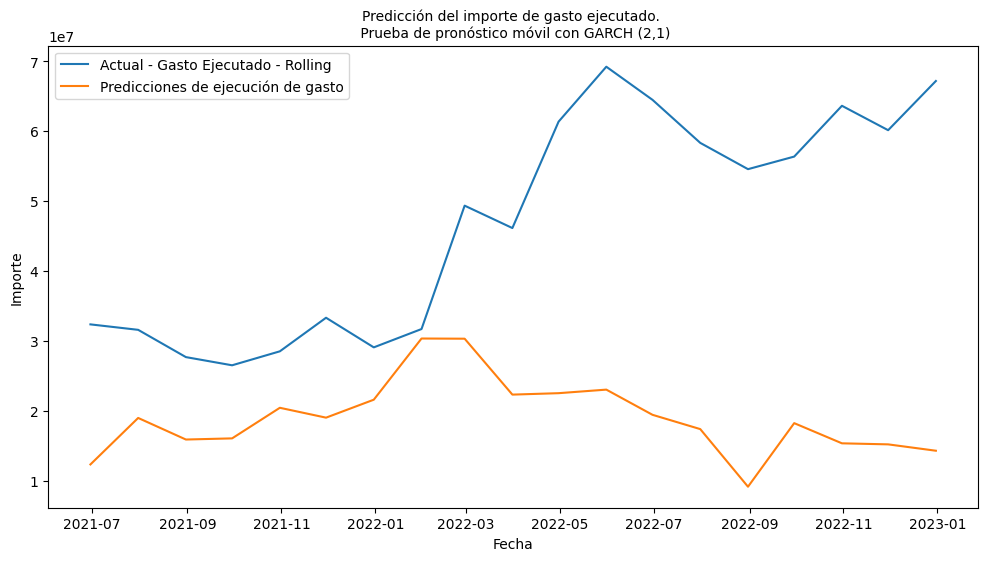

In [195]:
plt.figure (figsize = (12, 
                       6)) 
plt.plot (rolling_pred, label = "Actual - Gasto Ejecutado - Rolling")
plt.plot ((rolling_vol)[-test_size:], label = "Predicciones de ejecución de gasto")
plt.title ('Predicción del importe de gasto ejecutado. \n Prueba de pronóstico móvil con GARCH (2,1)',
           fontsize = 10)
plt.xlabel ("Fecha")
plt.ylabel ("Importe")
plt.legend ()
plt.show ()

In [196]:
metricas (garch_and_rolling_std["im_gas_ejecutado"],
          garch_and_rolling_std["cond_vol"],
          'GARCH')

Evaluación del modelo GARCH: 
	MSE es: 304854884511117.9
	MAE es: 14120484.169670656
	RMSE es: 17460094.05791154
	MAPE es: 103.36839939096478
	R2 es: -5.321822634547306



### 3.4.5 Modelo XGBoost (Extreme Gradient Boosting)

*Preparación de datos*

In [197]:
df_gas_xgb = df_gas.filter(['im_gas_ejecutado'])
df_gas_xgb.head()

im_gas_ejecutado
fecha                       
2015-01-31      5.835217e+08
2015-02-28      6.083011e+08
2015-03-31      5.856972e+08
2015-04-30      5.916807e+08
2015-05-31      6.312983e+08

In [198]:
df_gas_xgb.describe()

im_gas_ejecutado
count      9.600000e+01
mean       6.226875e+08
std        3.528196e+07
min        5.656563e+08
25%        5.980785e+08
50%        6.159399e+08
75%        6.434824e+08
max        7.136415e+08

Cálculo de promedio móvil de 12 meses (win_12)

In [199]:
df_gas_xgb["win_12"] = abs (df_gas_xgb["im_gas_ejecutado"].rolling (window = 12, 
                                                                    min_periods = 12).std().dropna())
df_gas_xgb.head (13)

im_gas_ejecutado        win_12
fecha                                     
2015-01-31      5.835217e+08           NaN
2015-02-28      6.083011e+08           NaN
2015-03-31      5.856972e+08           NaN
2015-04-30      5.916807e+08           NaN
2015-05-31      6.312983e+08           NaN
2015-06-30      6.175138e+08           NaN
2015-07-31      5.985416e+08           NaN
2015-08-31      6.045688e+08           NaN
2015-09-30      6.207909e+08           NaN
2015-10-31      5.999441e+08           NaN
2015-11-30      6.374048e+08           NaN
2015-12-31      6.329379e+08  1.856376e+07
2016-01-31      5.701928e+08  2.054291e+07

Eliminamos el índice

In [200]:
df_gas_xgb.reset_index (inplace = True)

In [201]:
df_gas_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             96 non-null     datetime64[ns]
 1   im_gas_ejecutado  96 non-null     float64       
 2   win_12            85 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.4 KB


*Conjunto de datos de entrenamiento y prueba*

In [202]:
test_size = 12 # meses

# Cojuntos de entrenamiento y test
train_xgb = df_gas_xgb[:-(test_size)].dropna()
test_xgb = df_gas_xgb[-(test_size):].dropna()

In [203]:
train_xgb.head()

fecha  im_gas_ejecutado        win_12
11 2015-12-31      6.329379e+08  1.856376e+07
12 2016-01-31      5.701928e+08  2.054291e+07
13 2016-02-29      5.695503e+08  2.338187e+07
14 2016-03-31      5.676714e+08  2.524055e+07
15 2016-04-30      6.155233e+08  2.516320e+07

In [204]:
train_xgb.shape, test_xgb.shape

((73, 3), (12, 3))

In [205]:
def crea_atributos_fecha (argu_df, label = None):
    # Crea atributos de serie de tiempo para índice de tiempo
    argu_df['dayofweek'] = argu_df['fecha'].dt.dayofweek
    argu_df['quarter'] = argu_df['fecha'].dt.quarter
    argu_df['month'] = argu_df['fecha'].dt.month
    argu_df['year'] = argu_df['fecha'].dt.year
    argu_df['dayofyear'] = argu_df['fecha'].dt.dayofyear
    argu_df['dayofmonth'] = argu_df['fecha'].dt.day
    
    X = argu_df[['dayofweek', 'quarter', 'month', 'year',
                'dayofyear', 'dayofmonth']]
    if label: 
        y = argu_df[label]
        return X, y
    return X

In [206]:
X_train, y_train = crea_atributos_fecha (train_xgb, 
                                         label = "win_12")
X_test, y_test = crea_atributos_fecha (test_xgb, 
                                       label = "win_12")

In [207]:
X_train.head()

dayofweek  quarter  month  year  dayofyear  dayofmonth
11          3        4     12  2015        365          31
12          6        1      1  2016         31          31
13          0        1      2  2016         60          29
14          3        1      3  2016         91          31
15          5        2      4  2016        121          30

In [208]:
try: 
    # Se crean variables lag que usan los 4 meses previo para rolling volatility
    X_train['prev1'] = train_xgb['win_12'].shift(1)
    X_test['prev1'] = test_xgb['win_12'].shift(1)
    X_train['prev2'] = train_xgb['win_12'].shift(1)
    X_test['prev2'] = test_xgb['win_12'].shift(1)
    X_train['prev3'] = train_xgb['win_12'].shift(1)
    X_test['prev3'] = test_xgb['win_12'].shift(1)
    X_train['prev4'] = train_xgb['win_12'].shift(1)
    X_test['prev4'] = test_xgb['win_12'].shift(1)
    
except Exception as e:   
        print (f"Error cod 470. XGBoost. Error en la creación de atributos para rolling volatility: ", 
               str (e))       

In [209]:
X_train

dayofweek  quarter  month  year  dayofyear  dayofmonth         prev1         prev2         prev3         prev4
11          3        4     12  2015        365          31           NaN           NaN           NaN           NaN
12          6        1      1  2016         31          31  1.856376e+07  1.856376e+07  1.856376e+07  1.856376e+07
13          0        1      2  2016         60          29  2.054291e+07  2.054291e+07  2.054291e+07  2.054291e+07
14          3        1      3  2016         91          31  2.338187e+07  2.338187e+07  2.338187e+07  2.338187e+07
15          5        2      4  2016        121          30  2.524055e+07  2.524055e+07  2.524055e+07  2.524055e+07
..        ...      ...    ...   ...        ...         ...           ...           ...           ...           ...
79          1        3      8  2021        243          31  3.047725e+07  3.047725e+07  3.047725e+07  3.047725e+07
80          3        3      9  2021        273          30  3.013135e+07  3.013135e+07  3.013135e+07  3.013135e+07
81          6        4     10  2021        304          31  2.954948e+07  2.954948e+07  2.954948e+07  2.954948e+07
82          1        4     11  2021        334          30  2.258282e+07  2.258282e+07  2.258282e+07  2.258282e+07
83          4        4     12  2021        365          31  1.529774e+07  1.529774e+07  1.529774e+07  1.529774e+07

[73 rows x 10 columns]

*Creación del modelo*

In [210]:
try: 
    reg = xgb.XGBRegressor (n_estimators = 100,
                            early_stopping_rounds = 10)
    
    reg.fit (X_train,
             y_train,
             eval_set = [(X_train, y_train), (X_test, y_test)],
             verbose = False)
except Exception as e:   
        print (f"Error cod 480. XGBoost. Error en la creación del modelo: ", 
               str (e))           

El modelo admite valores NaN. No hay que eliminarlos.    
Se visualizan las variables de más importancia del modelo.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

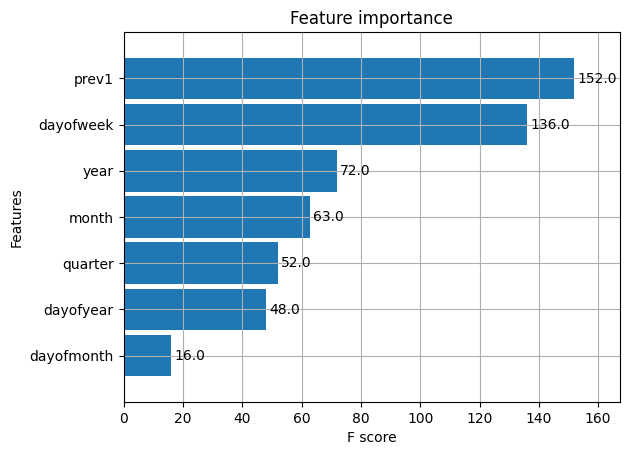

In [211]:
plot_importance (reg, 
                 height = 0.9)

*Predicciones*

In [212]:
# Realizamos las predicciones para train y test
train_xgb["Predictions"] = reg.predict (X_train)
test_xgb["Predictions"] = reg.predict (X_test)

In [213]:
# Dataframe con real y predicho
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_xgb["Predictions"]), 
                                              list(train_xgb["win_12"]))],
                                axis = 1).dropna().reset_index()

# Renombramos columnas
XGBoost_and_rolling.rename (columns = {"index": "Real Volatility", 
                                       0:"Predicted Volatility"}, 
                            inplace = True)
XGBoost_and_rolling.head (3)

Real Volatility  Predicted Volatility
0     1.856376e+07            18620954.0
1     2.054291e+07            20346230.0
2     2.338187e+07            22743784.0

In [214]:
train_xgb.head()

fecha  im_gas_ejecutado        win_12  dayofweek  quarter  month  year  dayofyear  dayofmonth  Predictions
11 2015-12-31      6.329379e+08  1.856376e+07          3        4     12  2015        365          31   18620954.0
12 2016-01-31      5.701928e+08  2.054291e+07          6        1      1  2016         31          31   20346230.0
13 2016-02-29      5.695503e+08  2.338187e+07          0        1      2  2016         60          29   22743784.0
14 2016-03-31      5.676714e+08  2.524055e+07          3        1      3  2016         91          31   25209192.0
15 2016-04-30      6.155233e+08  2.516320e+07          5        2      4  2016        121          30   24900486.0

In [215]:
XGBoost_and_rolling.set_index (train_xgb["fecha"], 
                               inplace = True)

In [216]:
XGBoost_and_rolling = px.line (XGBoost_and_rolling,
                               title = 'XGBoost vs rolling del gasto ejecutado mensualmente. Entrenamiento',
                               width = 1000,
                               height = 500)
XGBoost_and_rolling.show()

In [217]:
test_xgb["Predictions"]

84    19394556.0
85    22136100.0
86    21373136.0
87    24626298.0
88    29253558.0
89    28972978.0
90    23707796.0
91    20982076.0
92    23405860.0
93    19370744.0
94    19166142.0
95    17982446.0
Name: Predictions, dtype: float32

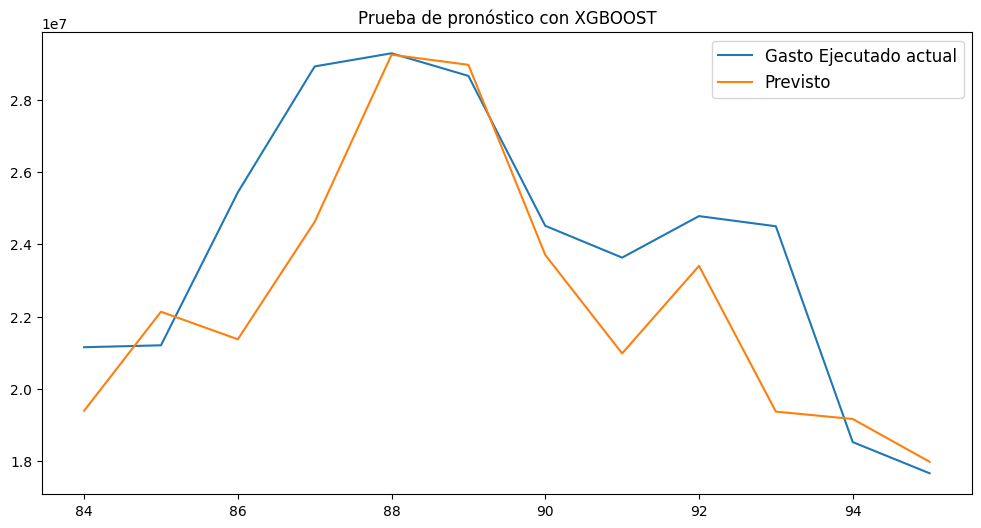

In [218]:
# Gráfica de predicciones
plt.figure (figsize = (12, 
                       6))

true, = plt.plot(test_xgb["win_12"])
preds, = plt.plot(test_xgb["Predictions"])
plt.title ('Prueba de pronóstico con XGBOOST', 
           fontsize = 12)
plt.legend (['Gasto Ejecutado actual', 'Previsto'], 
            fontsize = 12)

In [219]:
metricas (rolling_vol[-test_size:],
          rolling_predictions_xgb,
          'XGBoost')

Evaluación del modelo XGBoost: 
	MSE es: 2279347194701212.5
	MAE es: 47358035.11411163
	RMSE es: 47742509.30461461
	MAPE es: 276.4055926675445
	R2 es: -61.339065616784715



### 3.4.7. Modelo Exponential Smoothing

*Preparación de datos. Conjuntos de entrenamiento y prueba*

In [220]:
# Preparación de datos
df_expsmo = df_gas['im_gas_ejecutado']

In [221]:
# Dividir el conjunto de datos en entrenamiento y prueba (80/20)
train_data = df_expsmo[:77]
test_data = df_expsmo[77:]

*Creación del modelo*

In [222]:
# Crear y ajustar el modelo de suavizado exponencial
model = ExponentialSmoothing (train_data, 
                              seasonal = 'add', 
                              seasonal_periods = 12)

fitted_model = model.fit()

Predicciones

In [223]:
# Realizar predicciones para el conjunto de prueba
predictions = fitted_model.forecast (steps = 19)

In [224]:
predictions 

2021-06-30    6.458693e+08
2021-07-31    6.303039e+08
2021-08-31    6.444124e+08
2021-09-30    6.405361e+08
2021-10-31    6.449161e+08
2021-11-30    6.544092e+08
2021-12-31    6.454666e+08
2022-01-31    6.271754e+08
2022-02-28    6.262965e+08
2022-03-31    6.336817e+08
2022-04-30    6.453252e+08
2022-05-31    6.516391e+08
2022-06-30    6.458693e+08
2022-07-31    6.303039e+08
2022-08-31    6.444124e+08
2022-09-30    6.405361e+08
2022-10-31    6.449161e+08
2022-11-30    6.544092e+08
2022-12-31    6.454666e+08
Freq: M, dtype: float64

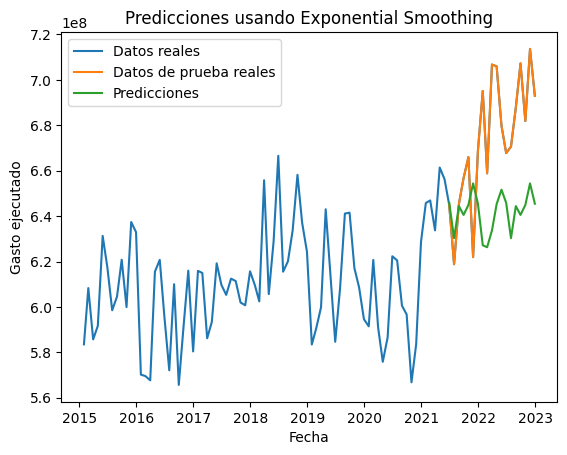

In [225]:
# Visualizar los resultados
plt.plot (df_expsmo, 
          label = 'Datos reales')
plt.plot (test_data.index, 
          test_data.values, 
          label = 'Datos de prueba reales')
plt.plot (test_data.index, 
          predictions, 
          label = 'Predicciones')
plt.title ('Predicciones usando Exponential Smoothing')
plt.xlabel ('Fecha')
plt.ylabel ('Gasto ejecutado')
plt.legend ()
plt.show ()

In [226]:
metricas (test_data.values, 
          predictions, 
          'Suavizado exponencial')

Evaluación del modelo Suavizado exponencial: 
	MSE es: 1763348787156859.2
	MAE es: 36054111.03153817
	RMSE es: 41992246.75052359
	MAPE es: 5.258514982194865
	R2 es: -1.402088415306559



### 3.4.8. Análisis comparativo de resultados (memoria)

# 4. Conclusiones (memoria)

# 5. Glosario (memoria)

# 6. Bibliografía (memoria)

# 7. Anexos (memoria)